In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

from scipy import interpolate

In [107]:
def convert_to_cylindrical(coordinate,velocity,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0]):
    #convert a 3 element matrix into a matrix of spherical coordinates
    #I could calculate V_tan and then project it into the new xy plane

    #it also could just be cylindrical and just use V_theta
    #just do cylindrical

    #the basic formula for converting velocities from cartesian to cylindrical is
    #
    # v = (x*dx/dt+y*dy/dt)/r rhat + (x*dy/dt-y*dx/dt)/r thetahat + dz/dt zhat

    import numpy as np
    
    halo_center = np.asarray(halo_center)
    halo_vel = np.asarray(halo_vel)

    X = coordinate[:,0]-halo_center[0]
    Y = coordinate[:,1]-halo_center[1]
    Z = coordinate[:,2]-halo_center[2]

    VX = velocity[:,0]-halo_vel[0]
    VY = velocity[:,1]-halo_vel[1]
    VZ = velocity[:,2]-halo_vel[2]
    
    R = np.sqrt(X**2.0+Y**2.0)
    theta = np.arctan2(Y,X)

    D_cylindrical = np.zeros((len(R),3))
    D_cylindrical[:,0] = R
    D_cylindrical[:,1] = theta
    D_cylindrical[:,2] = Z

    Vr = (X*VX+Y*VY)/R
    Vtheta = (X*VY-Y*VX)/R
    Vz = VZ

    V_cylindrical = np.zeros((len(Vr),3))
    V_cylindrical[:,0] = Vr
    V_cylindrical[:,1] = Vtheta
    V_cylindrical[:,2] = Vz

    return D_cylindrical, V_cylindrical

def Calc_average_L_shift(coordinates,masses,velocities):
    #For already shifted and cut cordinates
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    coord_mod = coordinates
    mass_mod = masses
    vel_mod = velocities

    coord_shift = coord_mod
    vel_shift = vel_mod

    rcrossv = np.cross(coord_shift,vel_shift)
    L_vec = [mass_mod[ii]*rcrossv[ii] for ii in range(len(rcrossv))]

    L_avg = np.mean(L_vec,axis=0)
    den = np.sqrt(L_avg[0]**2.0+L_avg[1]**2.0+L_avg[2]**2.0)
    return L_avg/den

def Rotate_to_z_axis(coordinates,velocities,rotation_axis):
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance
    #Okay I want to take in a "z" axis, and then rotate the
    #coordinates so that that is the z axis
    #then calculate velocity vectors in that frame and
    #then decompose it into spherical coordinates IN THAT FRAME

    L = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0+rotation_axis[2]**2.0) #total length
    R = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0) #length in xy plane
    
    ####OLD ROTATION MATRICIES#####
    R1 = np.asarray([[rotation_axis[0]/R,rotation_axis[1]/R,0.0],[-rotation_axis[1]/R,rotation_axis[0]/R,0.0],[0.0,0.0,1.0]]) #rotation about z axis to project into xz plane
    R2 = np.asarray([[rotation_axis[2]/L,0.0,-R/L],[0.0,1.0,0.0],[R/L,0.0,rotation_axis[2]/L]]) #rotation about y axis to make given axis the z axis
    
    coord_rotate = np.array([R2.dot(R1.dot(xx)) for xx in coordinates])
    vel_rotate = np.array([R2.dot(R1.dot(xx)) for xx in velocities])
    
    return coord_rotate, vel_rotate

def principle_axes(coordinates,masses,rad,center=None):
    #This code calculates principle axes of a given star particle
    #This is basically a modified version of Andrew Wetzel's code
    #to do the same thing
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    if center == None:
        dm_dist_val = np.linalg.norm(coordinates,axis=1)
    else:    
        dm_dist_val = get_distance(coordinates, center)

    dist_mask = (dm_dist_val<=rad)
    coord_mod = coordinates[dist_mask]
    mass_mod = masses[dist_mask]
    
    if center == None:
        dm_dist = coord_mod
    else:
        dm_dist = get_distance_vector(coord_mod, center)
    
    weights = mass_mod/np.median(mass_mod)

    xx = np.sum(weights * dm_dist[:,0]**2.0)
    yy = np.sum(weights * dm_dist[:,1]**2.0)
    zz = np.sum(weights * dm_dist[:,2]**2.0)
    
    xy = yx = np.sum(weights * dm_dist[:,0] * dm_dist[:,1])
    xz = zx = np.sum(weights * dm_dist[:,0] * dm_dist[:,2])
    yz = zy = np.sum(weights * dm_dist[:,1] * dm_dist[:,2])
    
    I_tensor = [[xx, xy, xz],[yx, yy, yz],[zx, zy, zz]]

    eigen_values, eigen_vectors = np.linalg.eig(I_tensor)

    # order eigen-vectors by eigen-values, from largest to smallest                                  
    eigen_indices_sorted = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[eigen_indices_sorted]
    eigen_values /= eigen_values.max()  # renormalize to 1                                           
    # make eigen_vectors[0] corresponds to vector of eigen_values[0]                                 
    eigen_vectors = eigen_vectors.transpose()[eigen_indices_sorted]

    axis_ratios = np.sqrt(
        [eigen_values[2] / eigen_values[0],
         eigen_values[2] / eigen_values[1],
         eigen_values[1] / eigen_values[0]]
    )

    return eigen_values, eigen_vectors, axis_ratios

def v_circ_theory(f_parts,center=[0.0,0.0,0.0],r_max=20.0):
    G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1
    f_stars = f_parts['PartType4']

    star_coords = f_stars['Coordinates'][:]/h
    star_mass = f_stars['Masses'][:]*1.0e10/h

    f_gas = f_parts['PartType0']
    gas_coords = f_gas['Coordinates'][:]/h
    gas_mass = f_gas['Masses'][:]*1.0e10/h

    f_dm = f_parts['PartType1']
    dm_coords = f_dm['Coordinates'][:]/h
    dm_mass = f_dm['Masses'][:]*1.0e10/h
    
    dist = np.linalg.norm(star_coords-center,axis=1)
    dist_gas = np.linalg.norm(gas_coords-center,axis=1)
    dist_dm = np.linalg.norm(dm_coords-center,axis=1)
    print('calculating total mass profile')
    m_prof_bins = np.logspace(-4.0,np.log10(r_max),5000)
    
    mass_profile_c, mpbins = np.histogram(dist,weights=star_mass,bins=m_prof_bins)
    mass_profile_gas_c, mpbins  = np.histogram(dist_gas,weights=gas_mass,bins=m_prof_bins)
    mass_profile_dm_c, mpbins  = np.histogram(dist_dm,weights=dm_mass,bins=m_prof_bins)

    mass_profile_total_c = np.sum([np.cumsum(mass_profile_c),
                                   np.cumsum(mass_profile_gas_c),
                                   np.cumsum(mass_profile_dm_c)],axis=0)

    m_prof_bins_plot = np.array([(m_prof_bins[ii]+m_prof_bins[ii+1])/2.0 for ii in 
                                 range(len(m_prof_bins)-1)])
    
    v_c = np.sqrt(np.divide(G*mass_profile_total_c,m_prof_bins_plot))
    return m_prof_bins_plot, v_c

In [49]:
#The correlation program is busted for reason that I don't quite understand
#as far as I can tell it has to be one of 3 things
#
# 1) a problem with the input particles either stars or dm
# 2) a problem with the NN algorithms
# 3) a problem with the sorting algorithms
#
# 1 is easy to check I just need to load up the particle data and plot it to see if it
# looks okay:

#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

h = 0.702

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

f_part = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.hdf5')

f_stars = f_parts['PartType4']

star_ids = f_stars['ParticleIDs'][:]
star_coords = f_stars['Coordinates'][:]/h
star_vel = f_stars['Velocities'][:]
star_mass = f_stars['Masses'][:]*1.0e10/h

f_gas = f_parts['PartType0']

gas_coords = f_gas['Coordinates'][:]/h
gas_vel = f_gas['Velocities'][:]
gas_mass = f_gas['Masses'][:]*1.0e10/h

f_dm = f_parts['PartType1']

dm_coords = f_dm['Coordinates'][:]/h
dm_mass = f_dm['Masses'][:]*1.0e10/h

calculating total mass profile


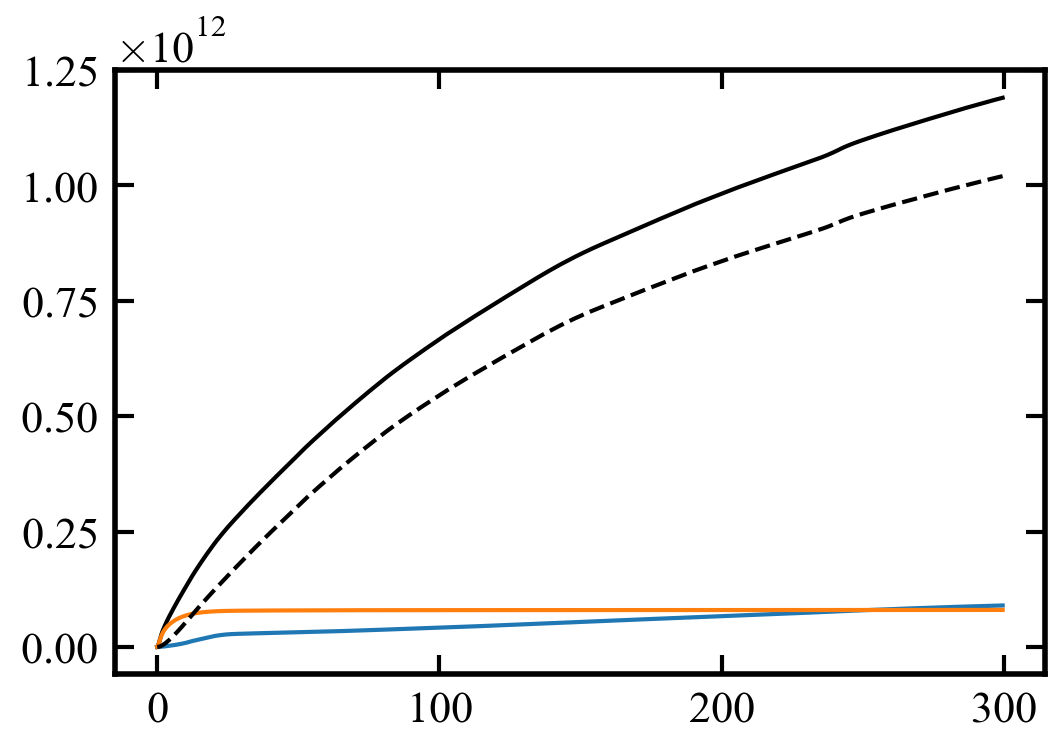

In [60]:
dist = np.linalg.norm(star_coords-host_pos_train,axis=1)
dist_gas = np.linalg.norm(gas_coords-host_pos_train,axis=1)
dist_dm = np.linalg.norm(dm_coords-host_pos_train,axis=1)
print('calculating total mass profile')
m_prof_bins = np.logspace(-4.0,np.log10(300.0),5000)

mass_profile_c, mpbins = np.histogram(dist,weights=star_mass,bins=m_prof_bins)
mass_profile_gas_c, mpbins  = np.histogram(dist_gas,weights=gas_mass,bins=m_prof_bins)
mass_profile_dm_c, mpbins  = np.histogram(dist_dm,weights=dm_mass,bins=m_prof_bins)

mass_profile_total_c = np.sum([np.cumsum(mass_profile_c),
                               np.cumsum(mass_profile_gas_c),
                               np.cumsum(mass_profile_dm_c)],axis=0)

m_prof_bins_plot = np.array([(m_prof_bins[ii]+m_prof_bins[ii+1])/2.0 for ii in 
                             range(len(m_prof_bins)-1)])

plt.plot(m_prof_bins_plot,mass_profile_total_c,color='k')
plt.plot(m_prof_bins_plot,np.cumsum(mass_profile_gas_c),color='C0')
plt.plot(m_prof_bins_plot,np.cumsum(mass_profile_c),color='C1')
plt.plot(m_prof_bins_plot,np.cumsum(mass_profile_dm_c),color='k',linestyle='--')
plt.show()

279.0850492577728


<function matplotlib.pyplot.show>

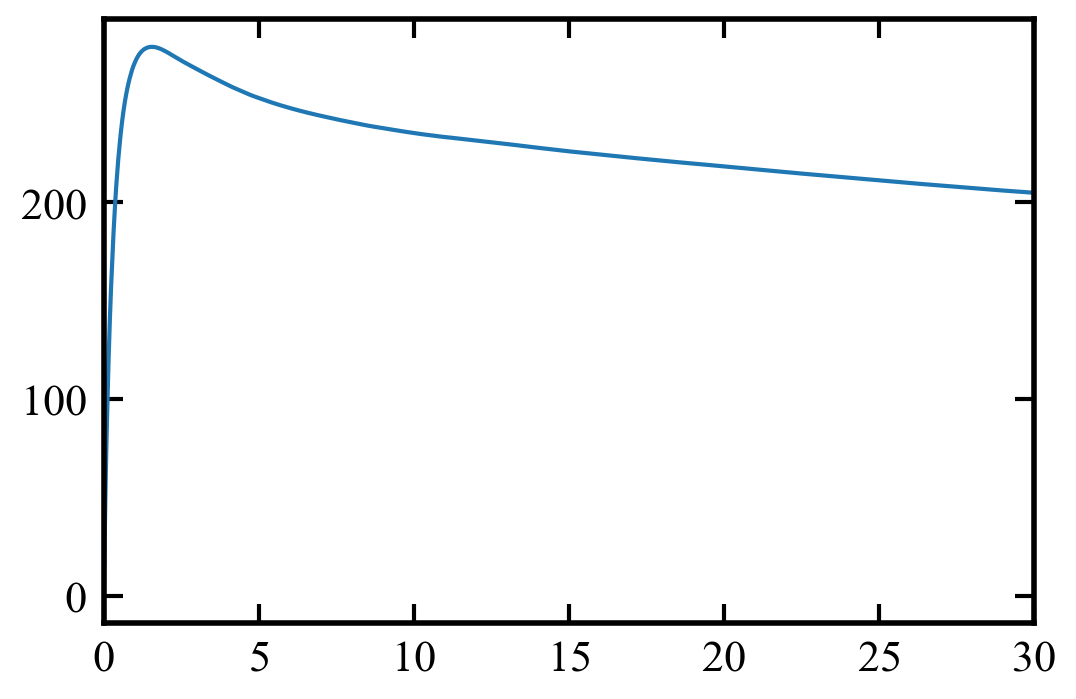

In [65]:
G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

v_c = np.sqrt(G*mass_profile_total_c/m_prof_bins_plot)
print np.max(v_c)

plt.plot(m_prof_bins_plot,v_c)
plt.xlim([0.0,30.0])
plt.show

calculating total mass profile


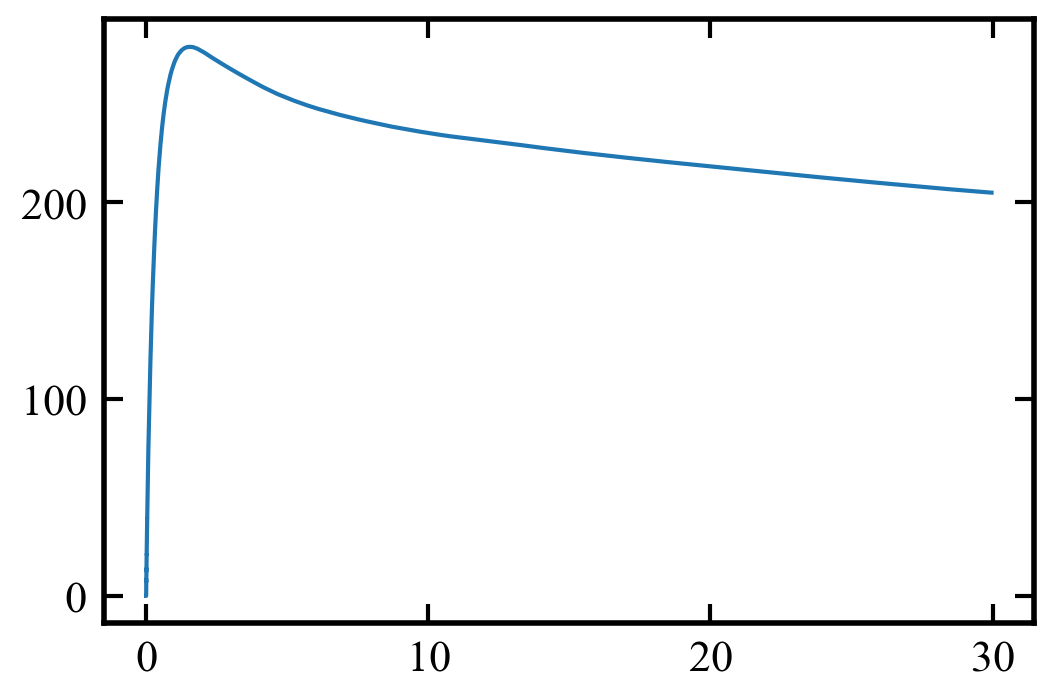

In [68]:
v_c_bins, v_c_val = v_circ_theory(f_parts,center=host_pos_train,r_max=30.0)

plt.plot(v_c_bins,v_c_val)
plt.show()

In [118]:
eig_vec

array([[ 0.90772308,  0.02871032,  0.41858634],
       [ 0.04346617, -0.99872282, -0.02575715],
       [ 0.41731223,  0.0415747 , -0.90781168]])

calculating total mass profile
[-0.41419683 -0.30651207  0.8570247 ]


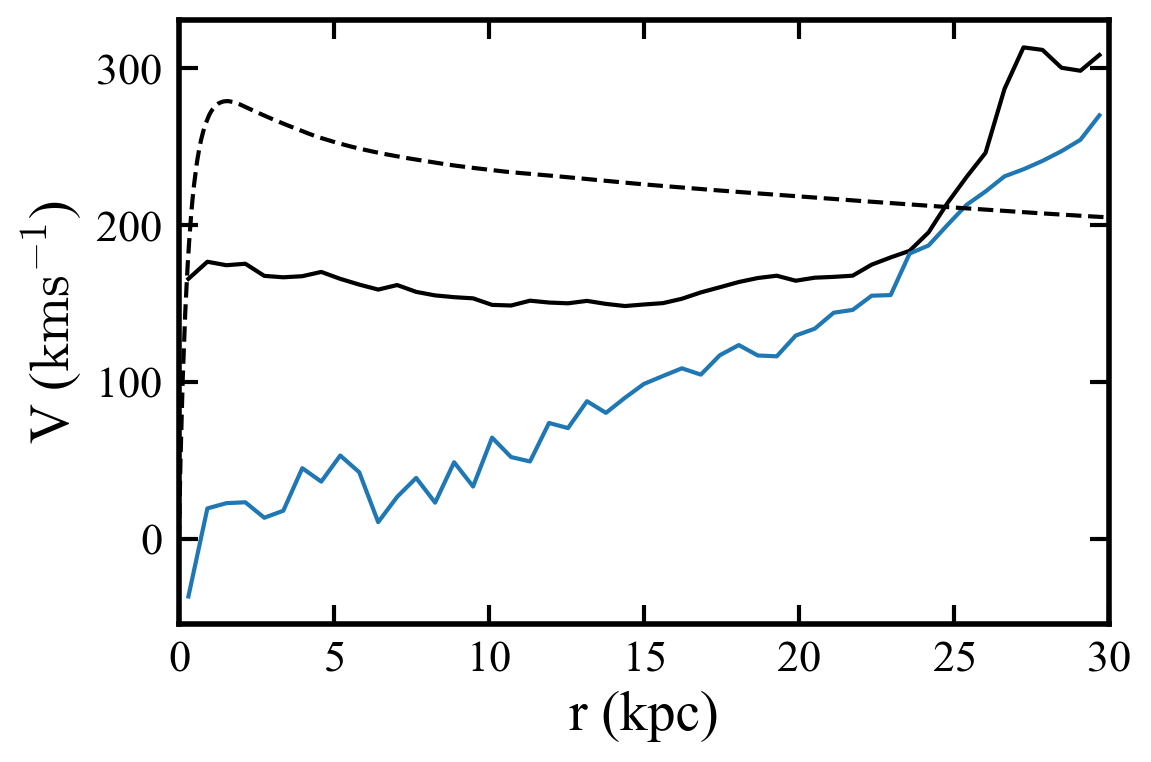

In [131]:
pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

v_c_bins, v_c = v_circ_theory(f_part,center=host_pos_train,r_max=30.0)

gas_diff = gas_coords - host_cen
star_diff = star_coords - host_cen

gas_vel_diff = gas_vel - host_vel
star_vel_diff = star_vel - host_vel

gas_dist = np.linalg.norm(gas_diff,axis=1)
star_dist = np.linalg.norm(star_diff,axis=1)
star_mask = (star_dist<30.0)
gas_mask = (gas_dist<30.0)
'''
for jj in range(100):
    vector = np.array([np.random.random(),np.random.random(),np.random.random()])
    norm = np.sqrt(vector[0]**2.0+vector[1]**2.0+vector[2]**2.0)
    unit_vector = vector/norm
    
    coord_rotate, vel_rotate = Rotate_to_z_axis(gas_diff[gas_mask],
                                                gas_vel_diff[gas_mask],
                                                unit_vector)
    
    coord_rot_cyl, vel_rot_cyl = convert_to_cylindrical(coord_rotate,vel_rotate)
    
    #print vel_rotate
    
    dist_bins = np.linspace(0.0,30.0,25)
    gas_disp_profile, gas_v_rot  = [], []
    bin_center = []
    
    dist_yz = np.sqrt(coord_rotate[:,0]**2.0+coord_rotate[:,1]**2.0)
    v_theta = vel_rot_cyl[:,1]
    
    for ii in range(len(dist_bins)-1):
        
        gas_bin_mask = (dist_yz>dist_bins[ii])&(dist_yz<dist_bins[ii+1])
        
        gas_vel_disp = np.std(np.sqrt(vel_rotate[:,0][gas_bin_mask]**2.0+
                                      vel_rotate[:,1][gas_bin_mask]**2.0+
                                      vel_rotate[:,2][gas_bin_mask]**2.0))
        
        gas_v_rot.append(np.mean(v_theta[gas_bin_mask]))
        gas_disp_profile.append(np.mean(gas_vel_disp))
        bin_center.append((dist_bins[ii]+dist_bins[ii+1])/2.0)
    
    
    
    #plt.plot(bin_center,gas_disp_profile)
    plt.plot(bin_center,gas_v_rot,linestyle='-',color='k',alpha=0.4,lw=0.5)
'''
#eig_val, eig_vec, axis_ratios = principle_axes(gas_diff,gas_mass,30.0)
L_vec = Calc_average_L_shift(star_diff[star_mask],star_mass[star_mask],star_vel_diff[star_mask])

print L_vec

coord_rotate, vel_rotate = Rotate_to_z_axis(gas_diff[gas_mask],
                                                gas_vel_diff[gas_mask],
                                                L_vec)

coord_rotate_star, vel_rotate_star = Rotate_to_z_axis(star_diff[star_mask],
                                                star_vel_diff[star_mask],
                                                L_vec)

coord_rot_cyl, vel_rot_cyl = convert_to_cylindrical(coord_rotate,vel_rotate)
coord_rot_cyl_star, vel_rot_cyl_star = convert_to_cylindrical(coord_rotate_star,vel_rotate_star)

dist_bins = np.linspace(0.0,30.0,50)
gas_disp_profile, gas_v_rot  = [], []
bin_center = []

star_disp_profile, star_v_rot  = [], []
bin_center_star = []

v_theta = vel_rot_cyl[:,1]
v_theta_star = vel_rot_cyl_star[:,1]

for ii in range(len(dist_bins)-1):
    gas_bin_mask = (coord_rot_cyl[:,0]>dist_bins[ii])&(coord_rot_cyl[:,0]<dist_bins[ii+1])&(coord_rot_cyl[:,2]<2.0)
    gas_v_rot.append(np.mean(np.abs(v_theta[gas_bin_mask])))
    bin_center.append((dist_bins[ii]+dist_bins[ii+1])/2.0)

for ii in range(len(dist_bins)-1):
    star_bin_mask = (coord_rot_cyl_star[:,0]>dist_bins[ii])&(coord_rot_cyl_star[:,0]<dist_bins[ii+1])&(coord_rot_cyl_star[:,2]<2.0)
    star_v_rot.append(np.mean(v_theta_star[star_bin_mask]))
    bin_center_star.append((dist_bins[ii]+dist_bins[ii+1])/2.0)

plt.plot(bin_center,gas_v_rot,color='k')
plt.plot(bin_center_star,star_v_rot,color='C0')
plt.plot(v_c_bins,v_c,color='k',linestyle='--')
plt.xlim([0.0,30.0])
#plt.ylim([0.0,41.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel(r'V ($\rm kms^{-1}$)',fontsize=20)
plt.savefig('./v_c_m12i.png',bbox_inches='tight')
plt.show()

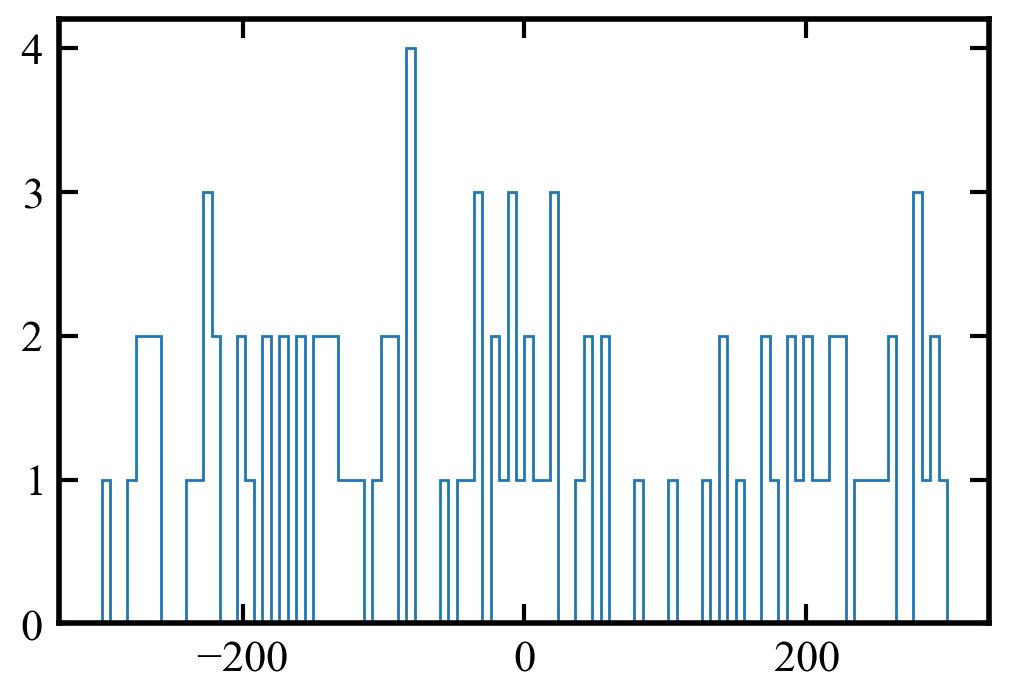

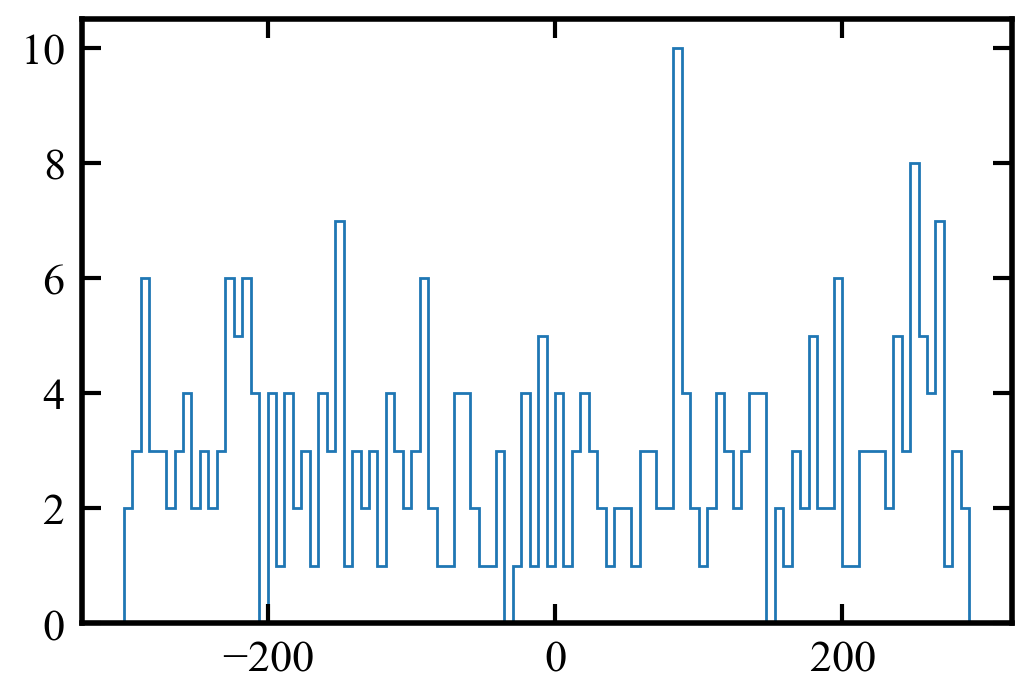

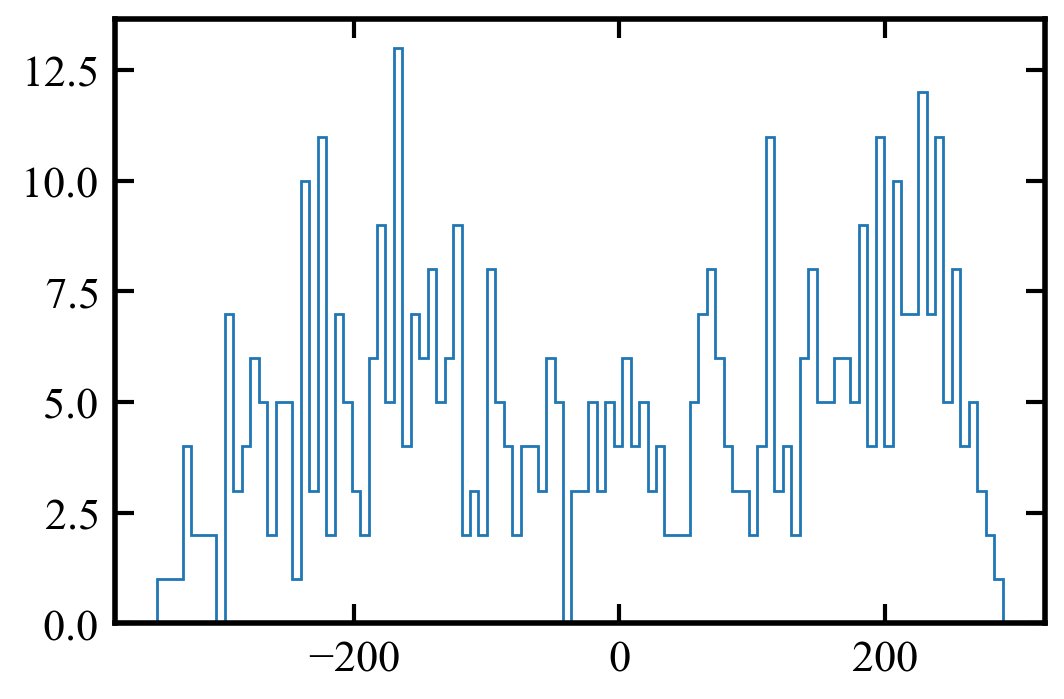

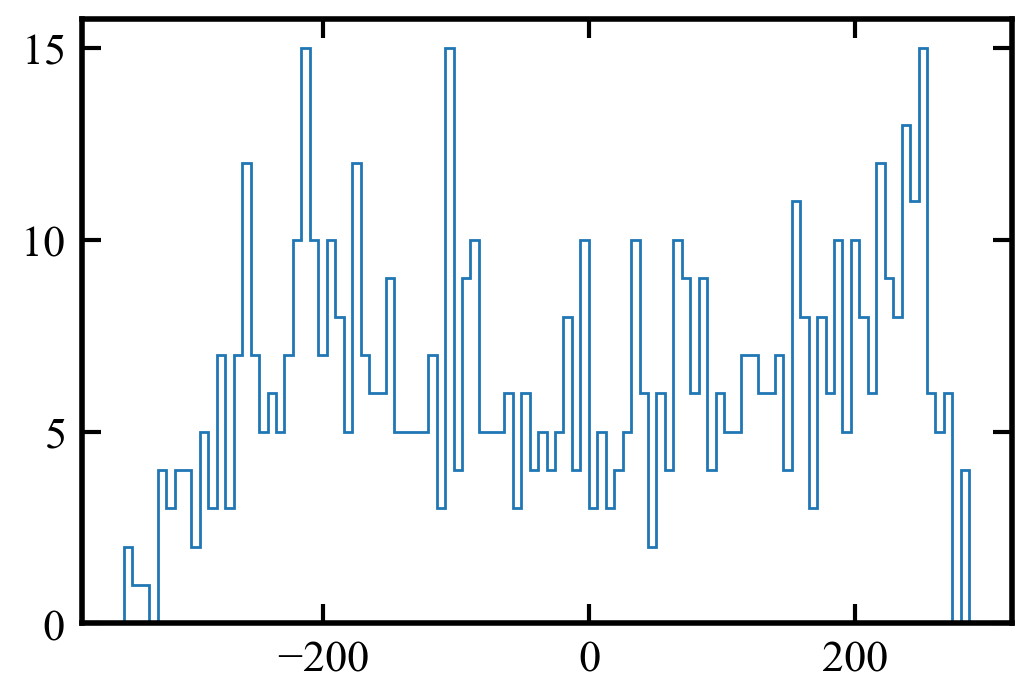

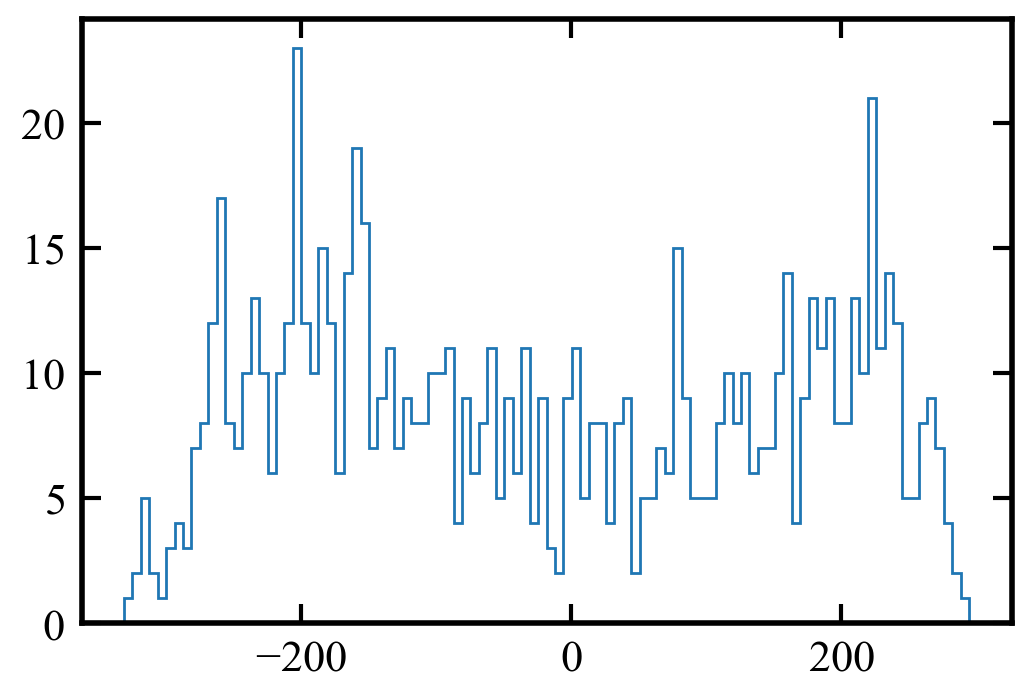

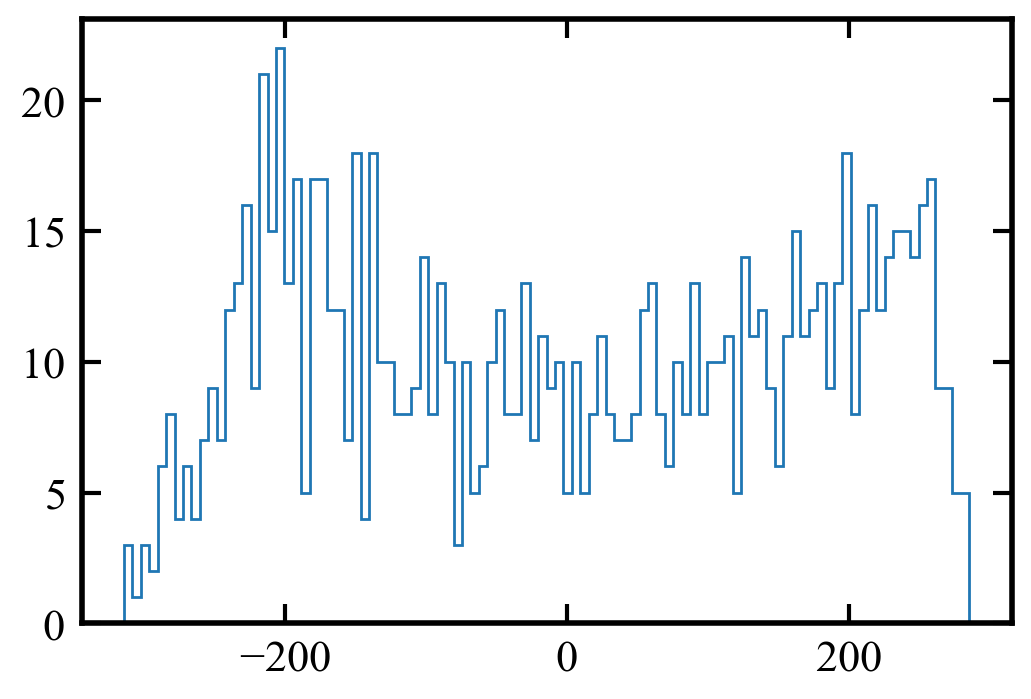

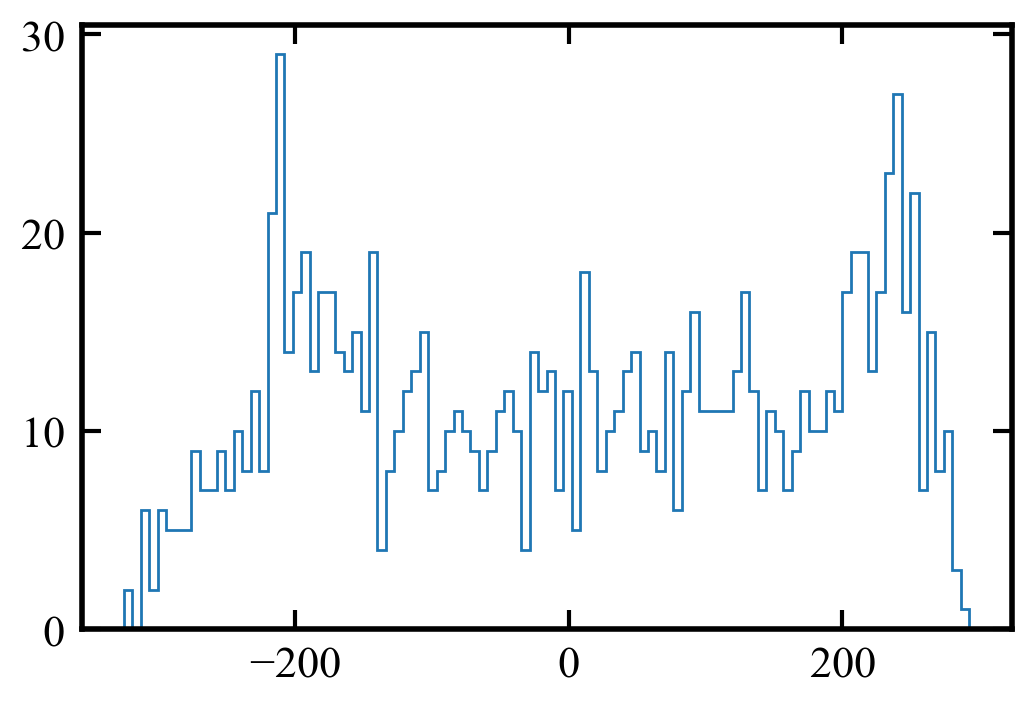

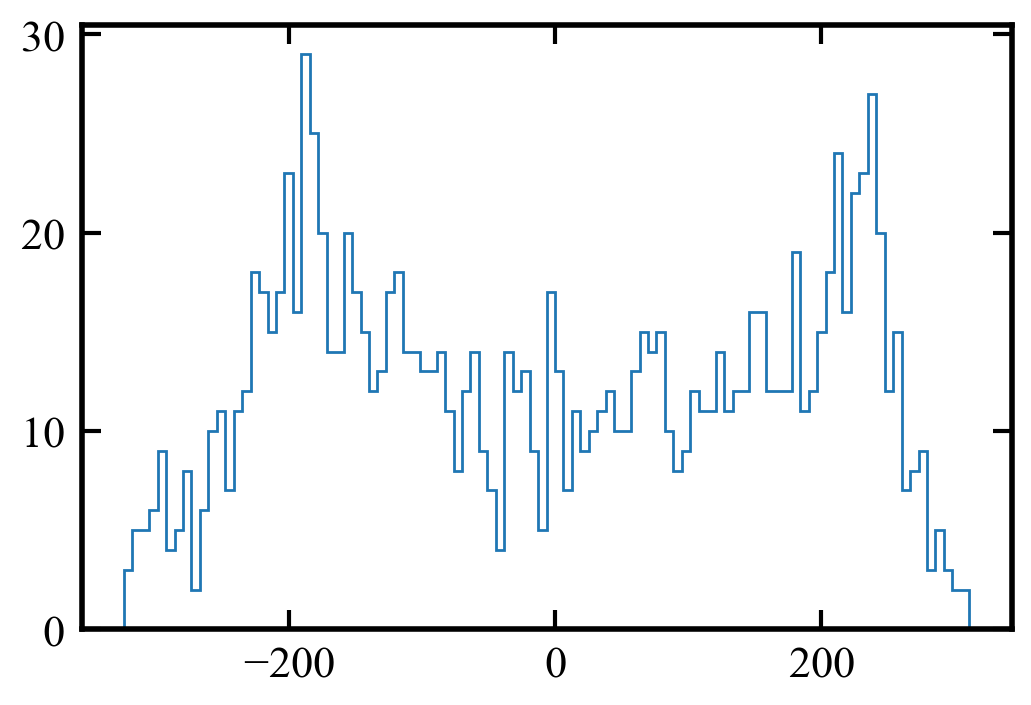

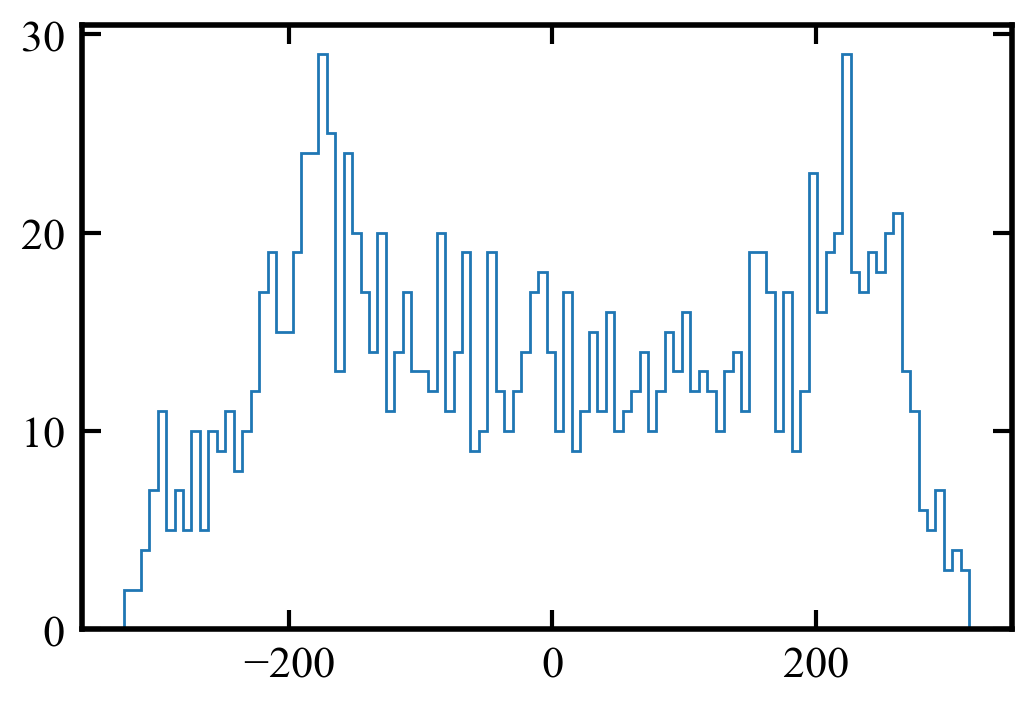

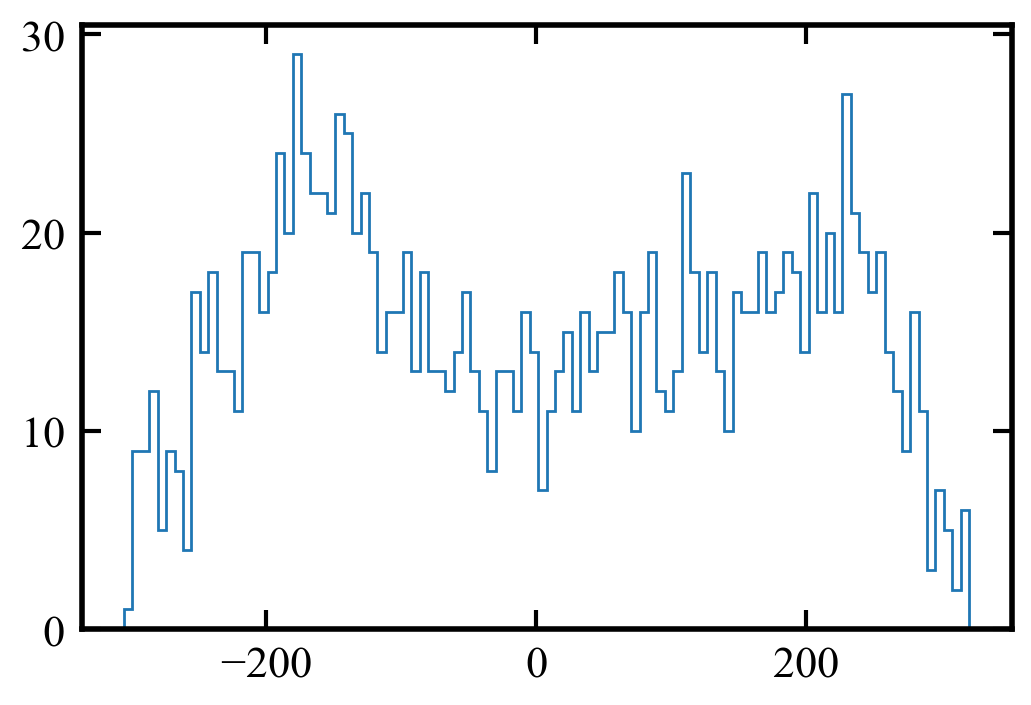

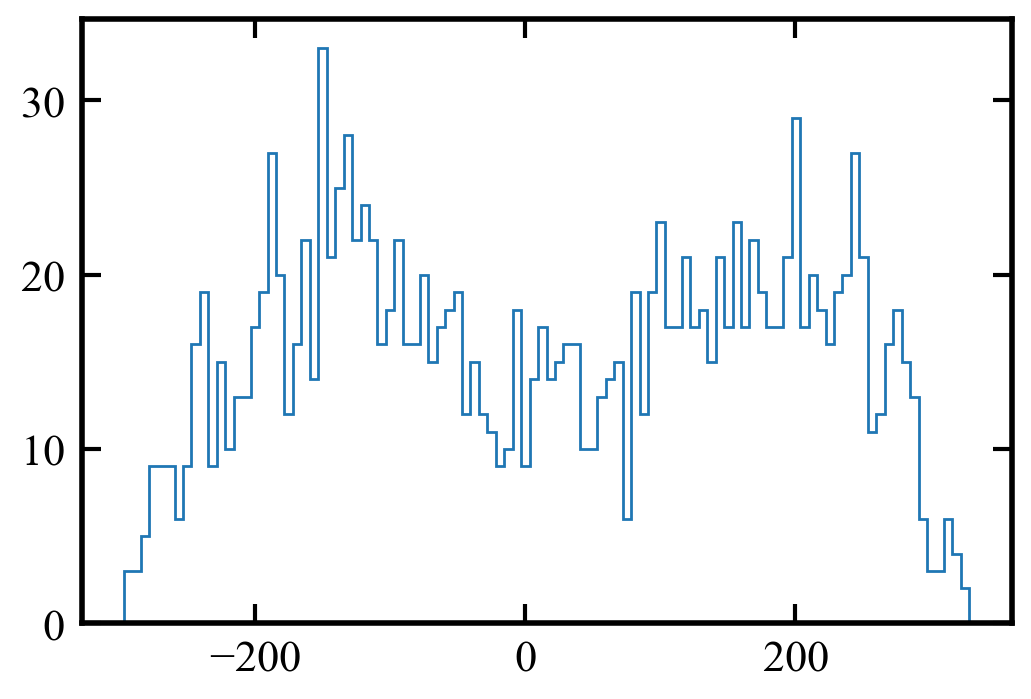

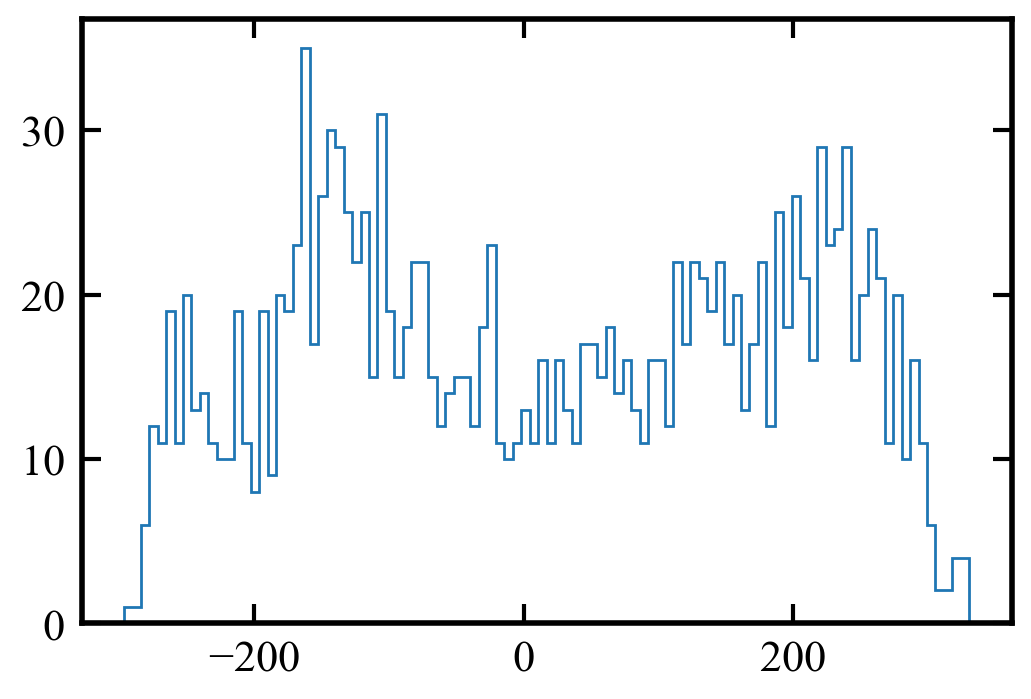

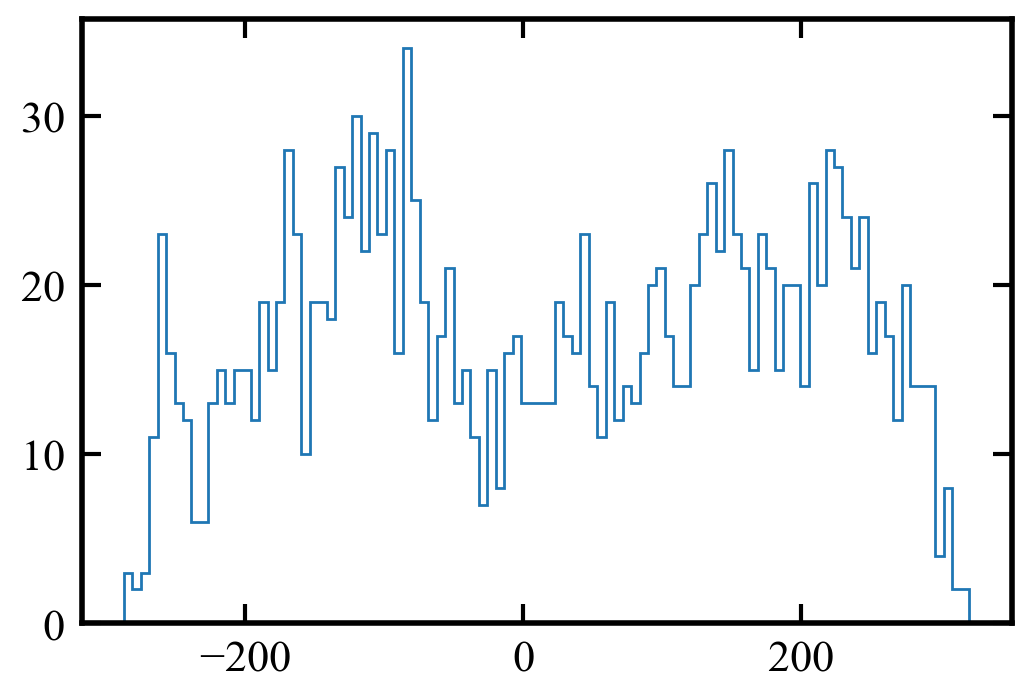

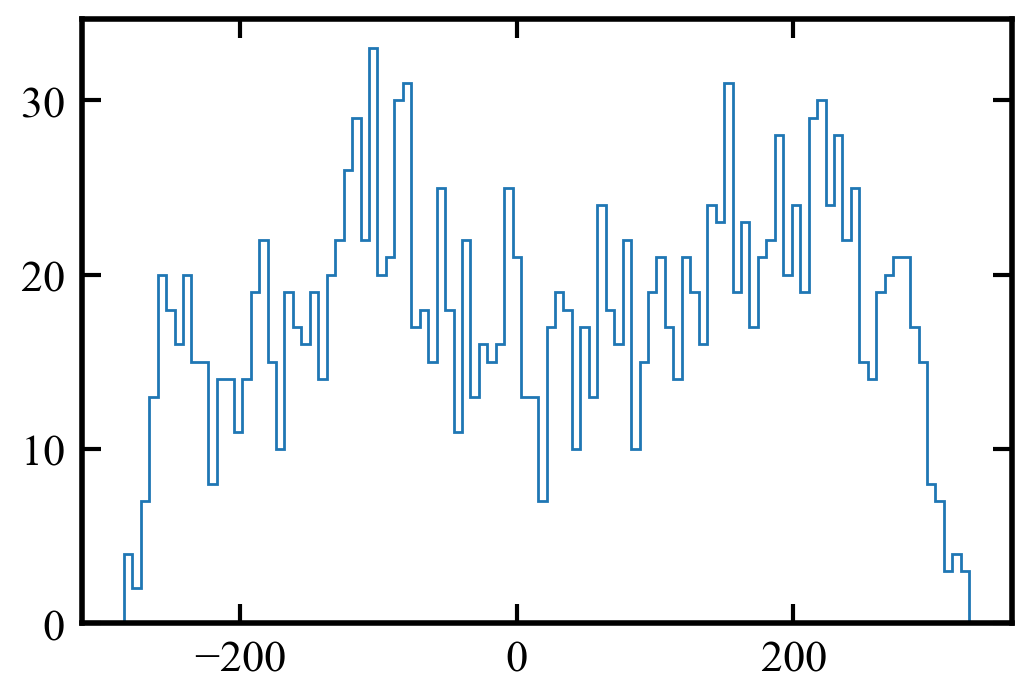

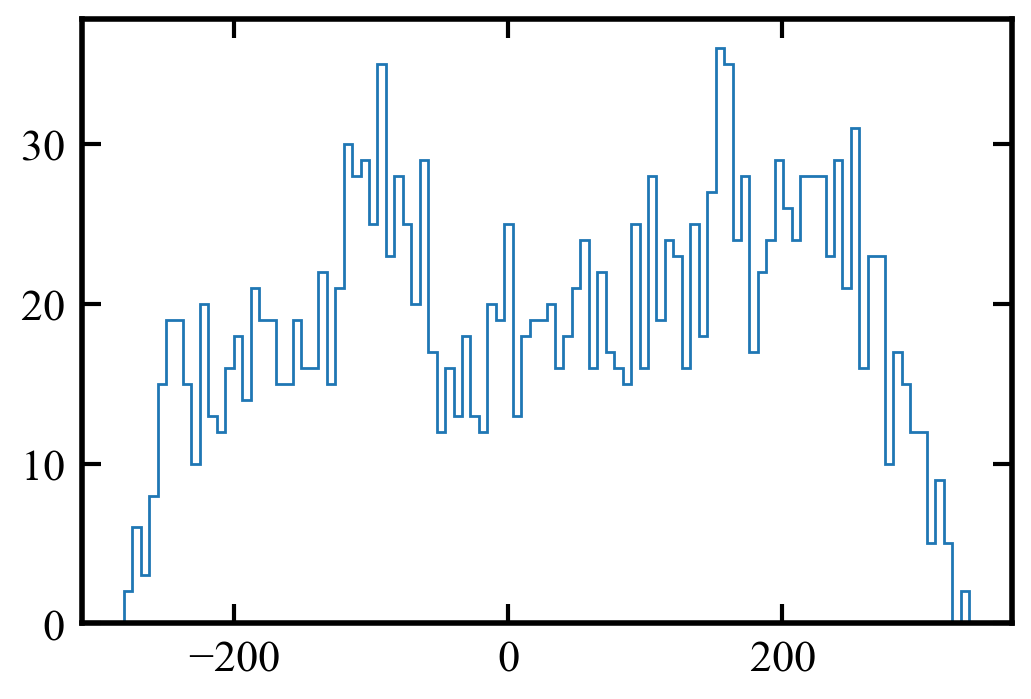

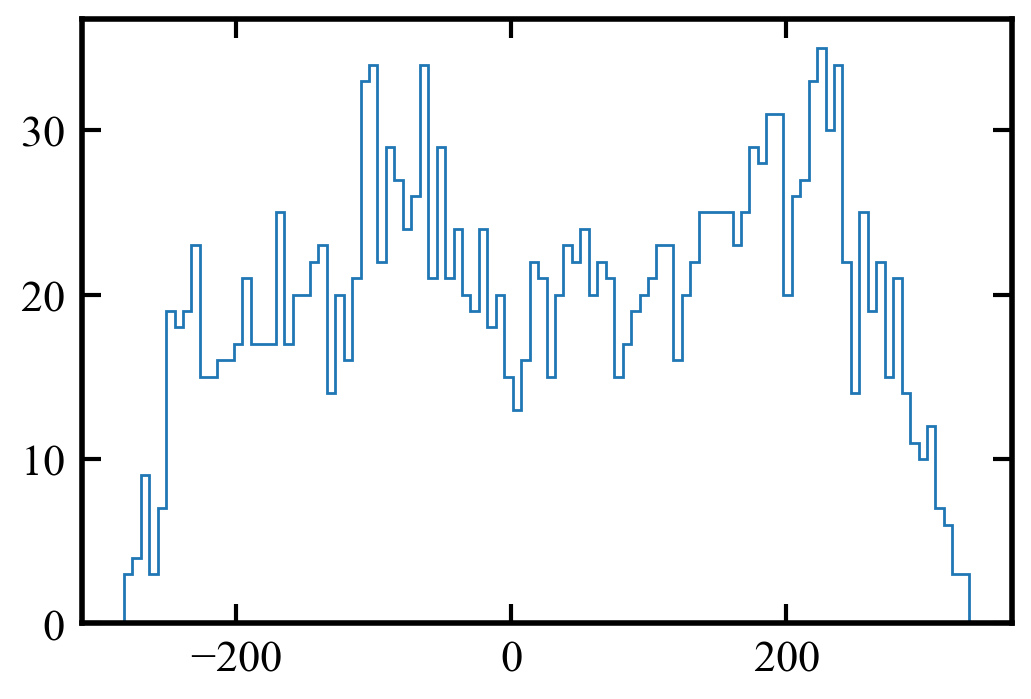

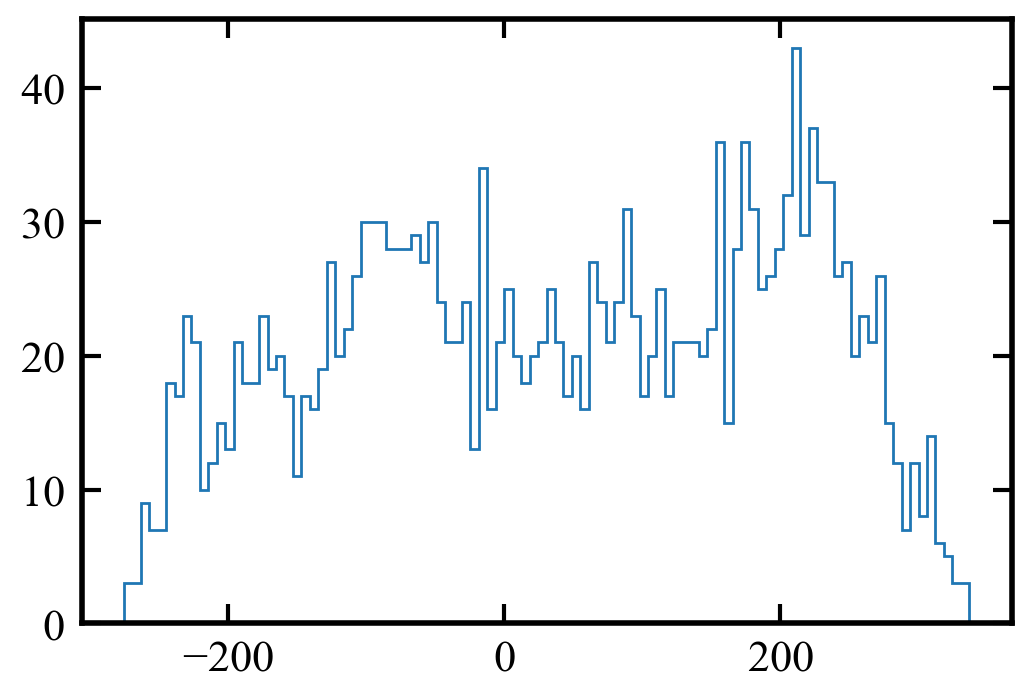

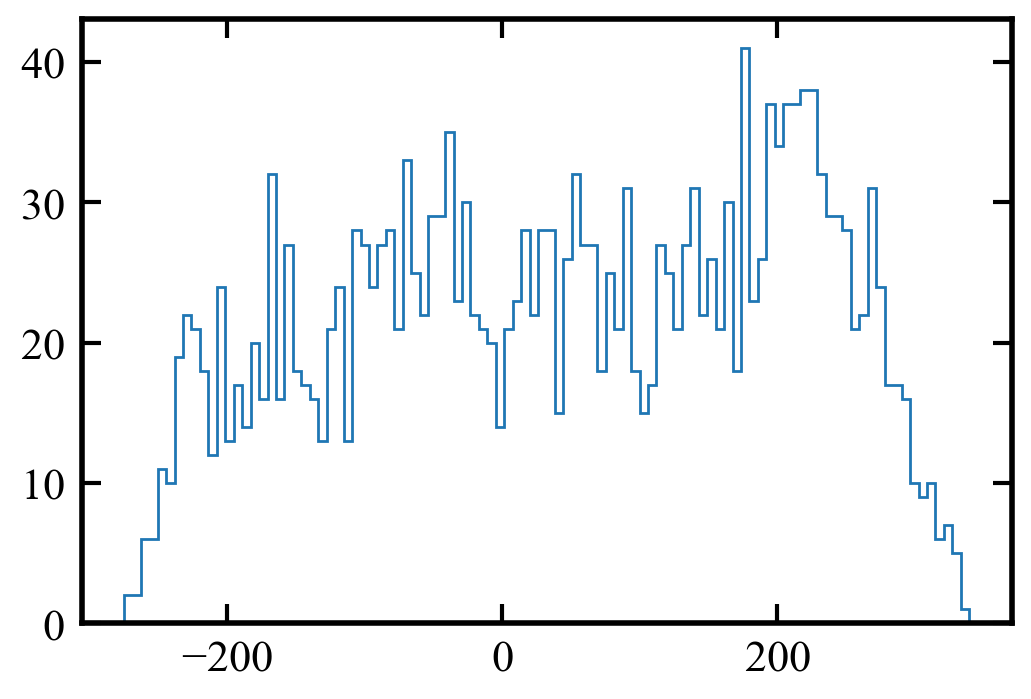

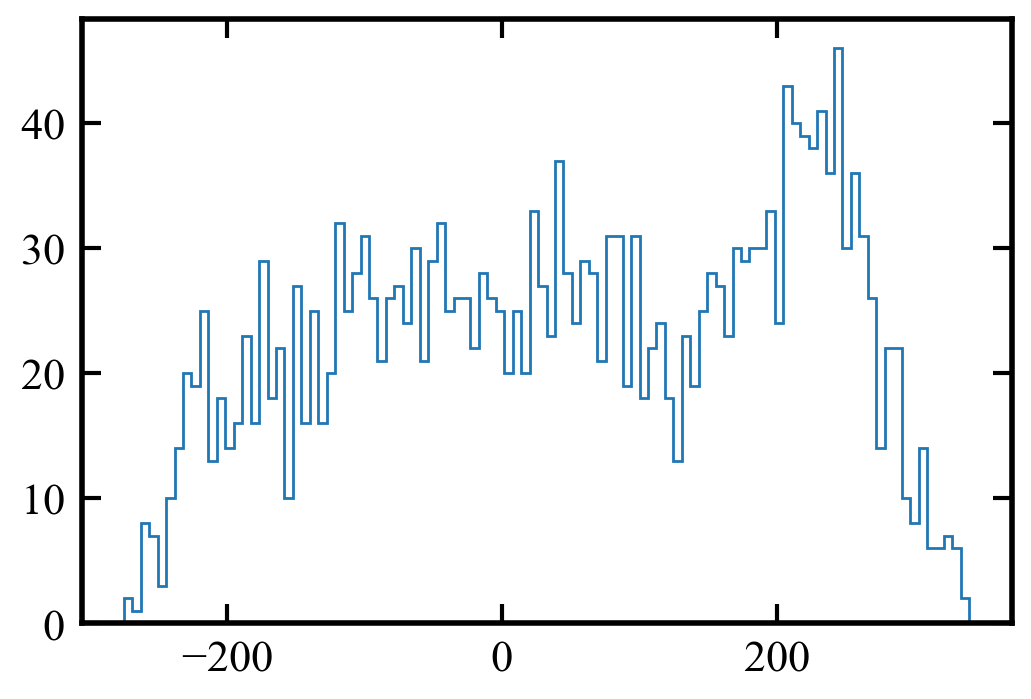

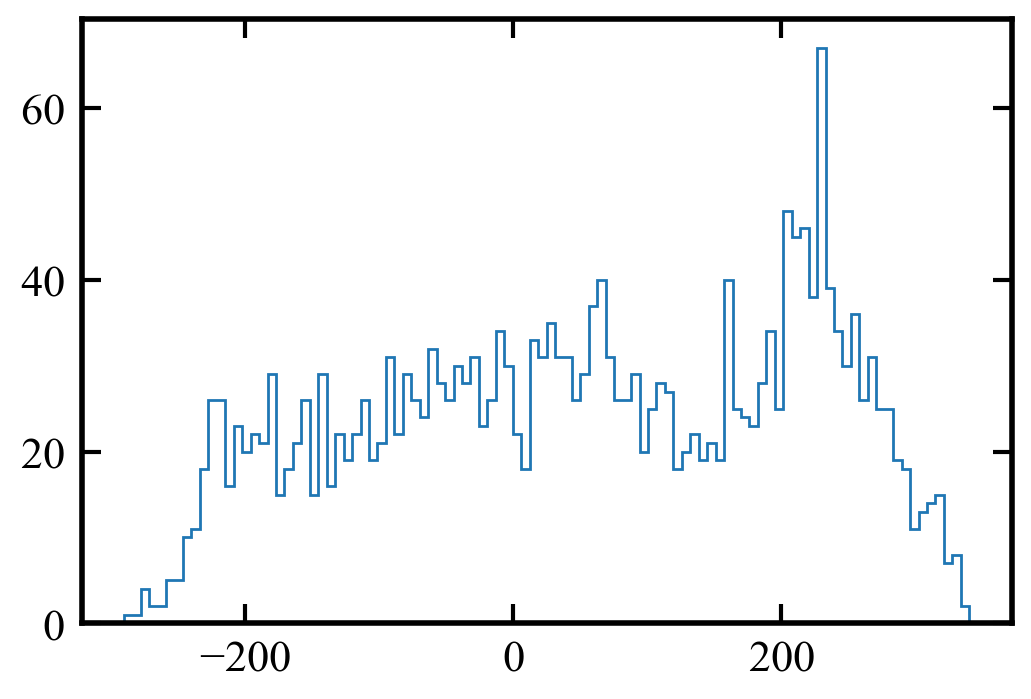

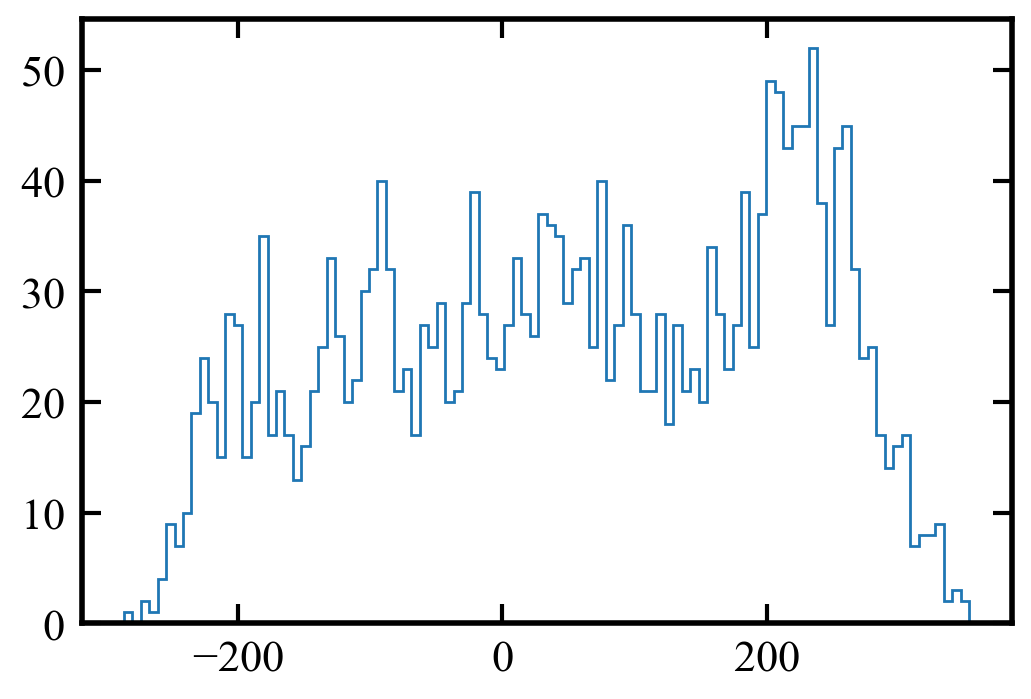

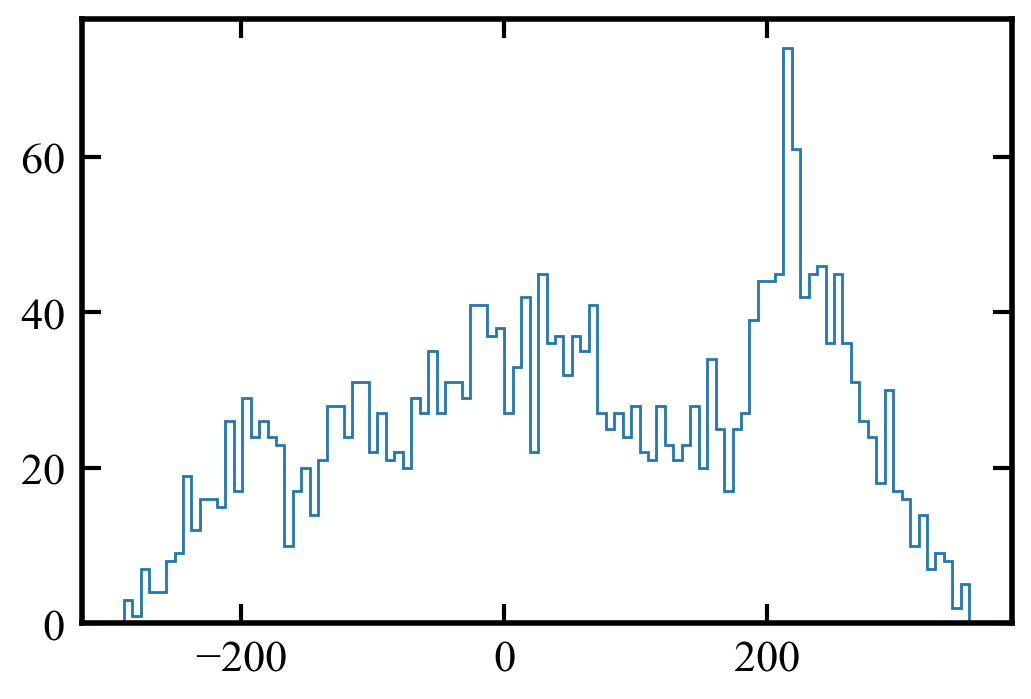

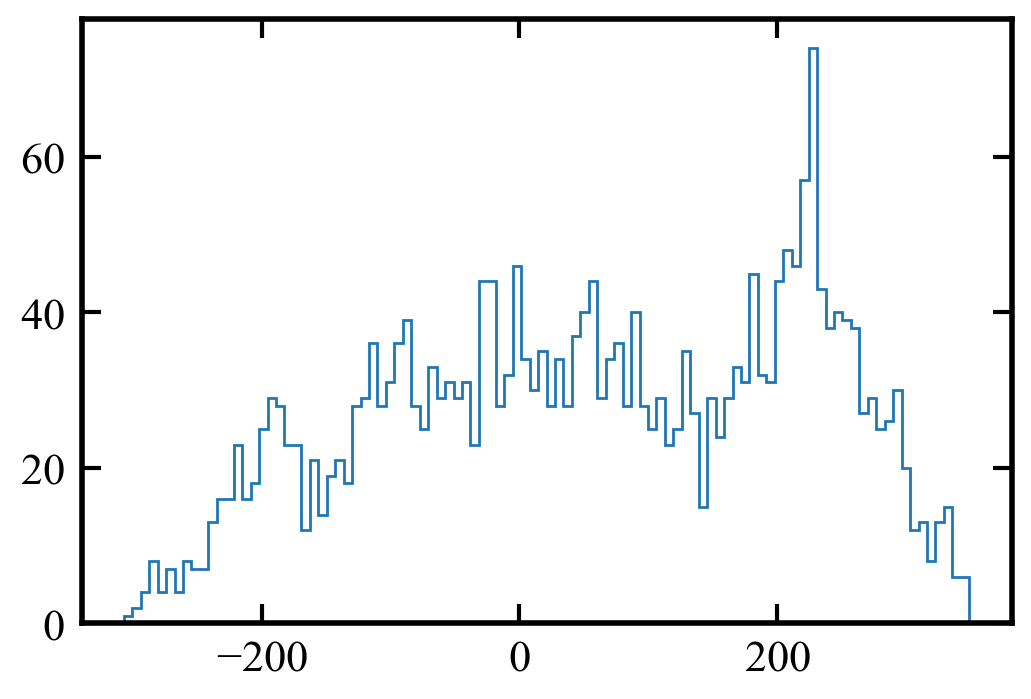

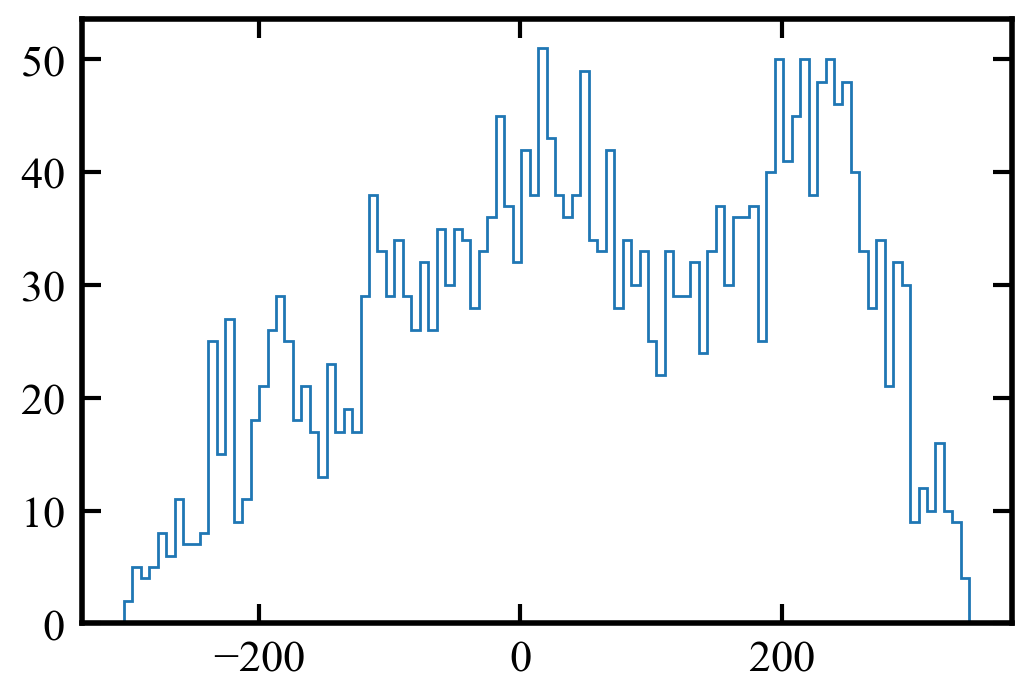

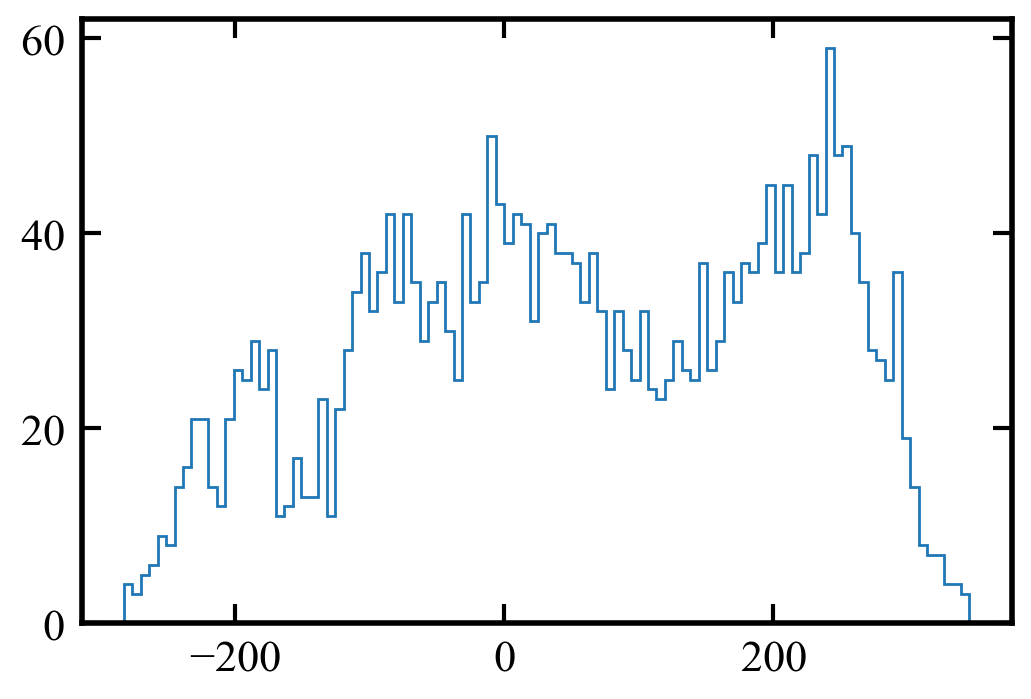

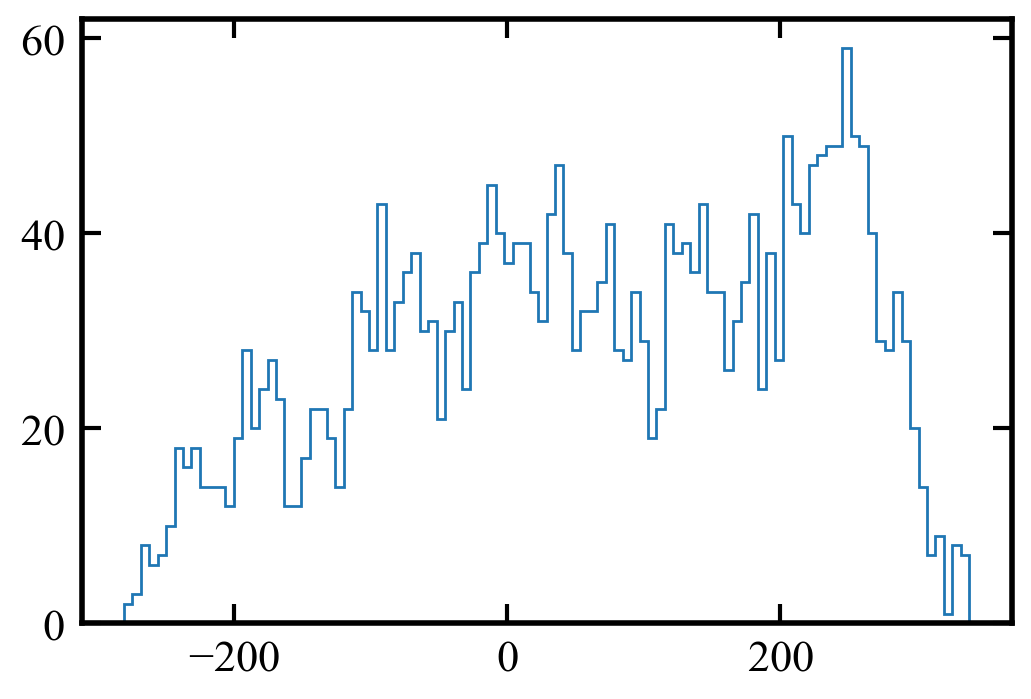

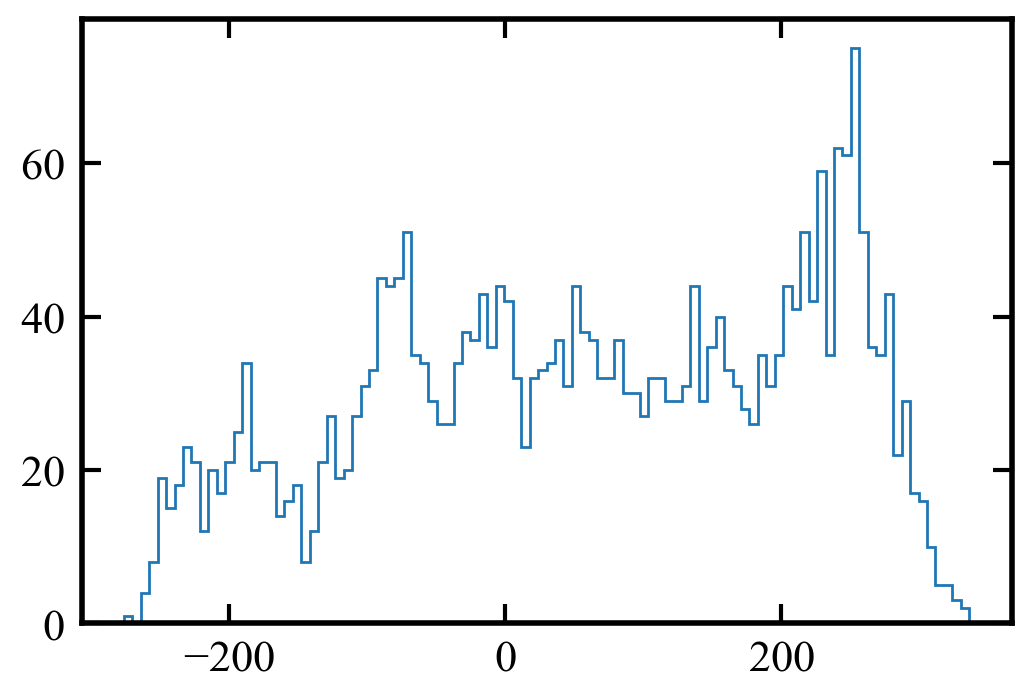

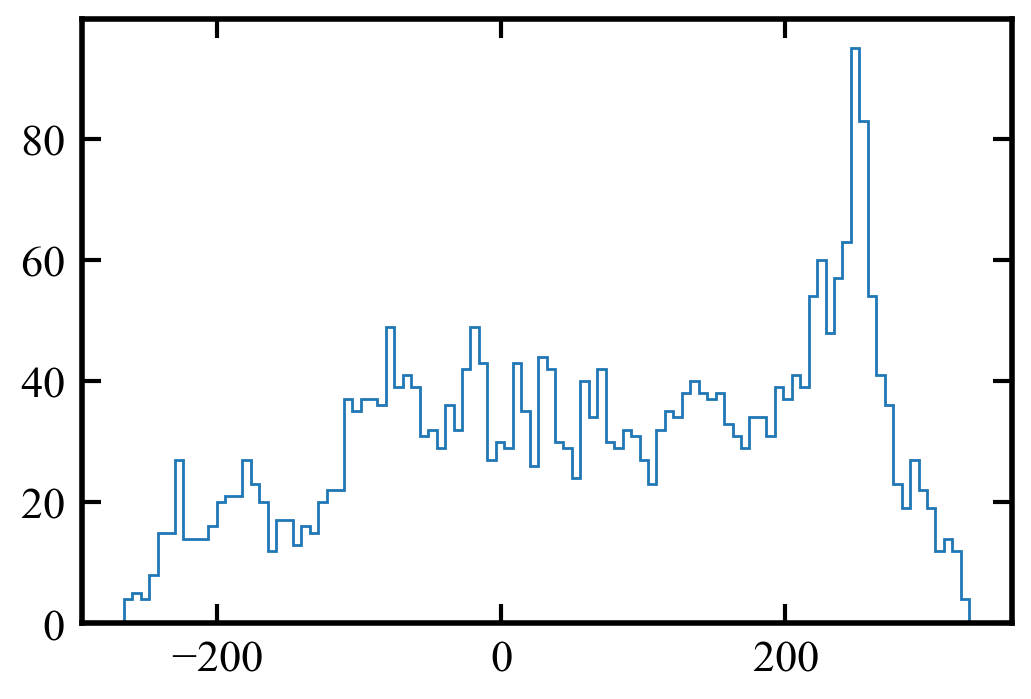

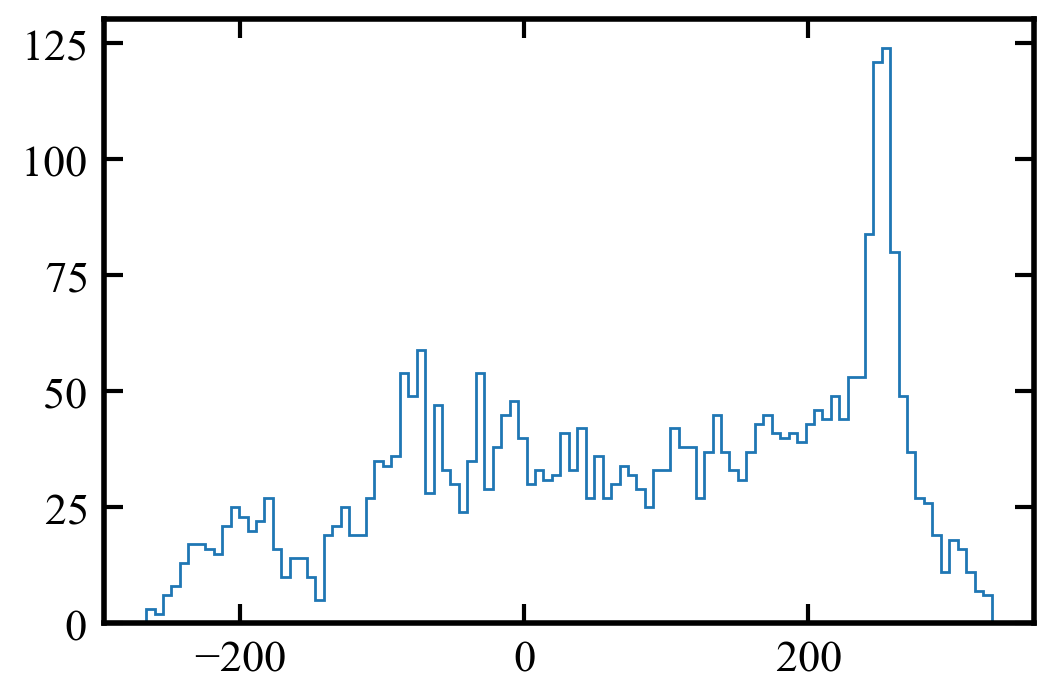

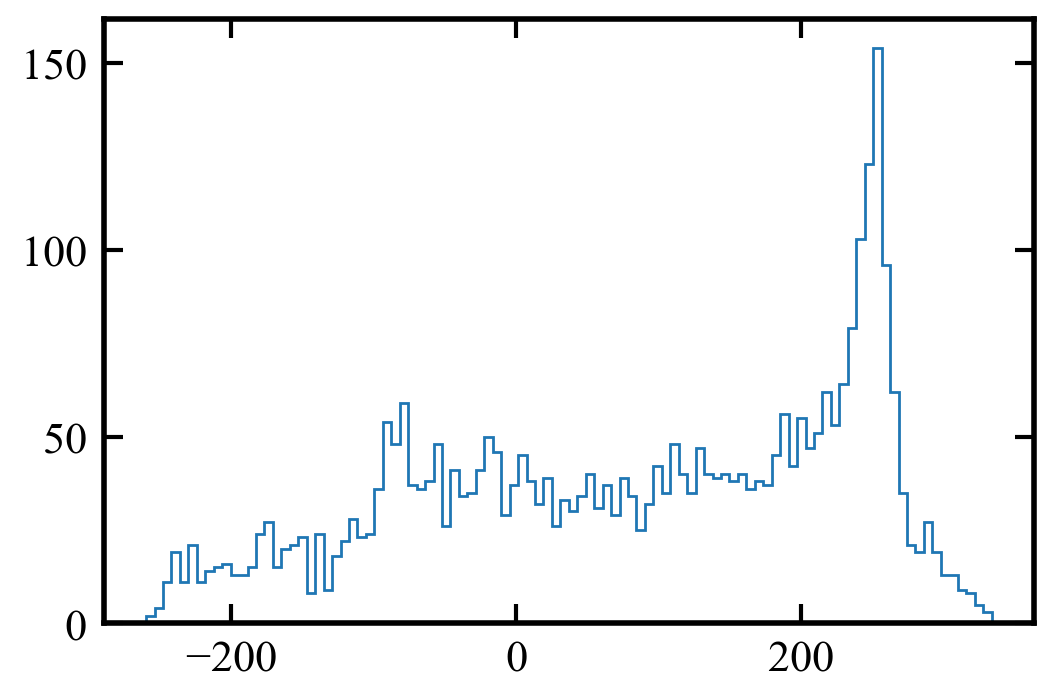

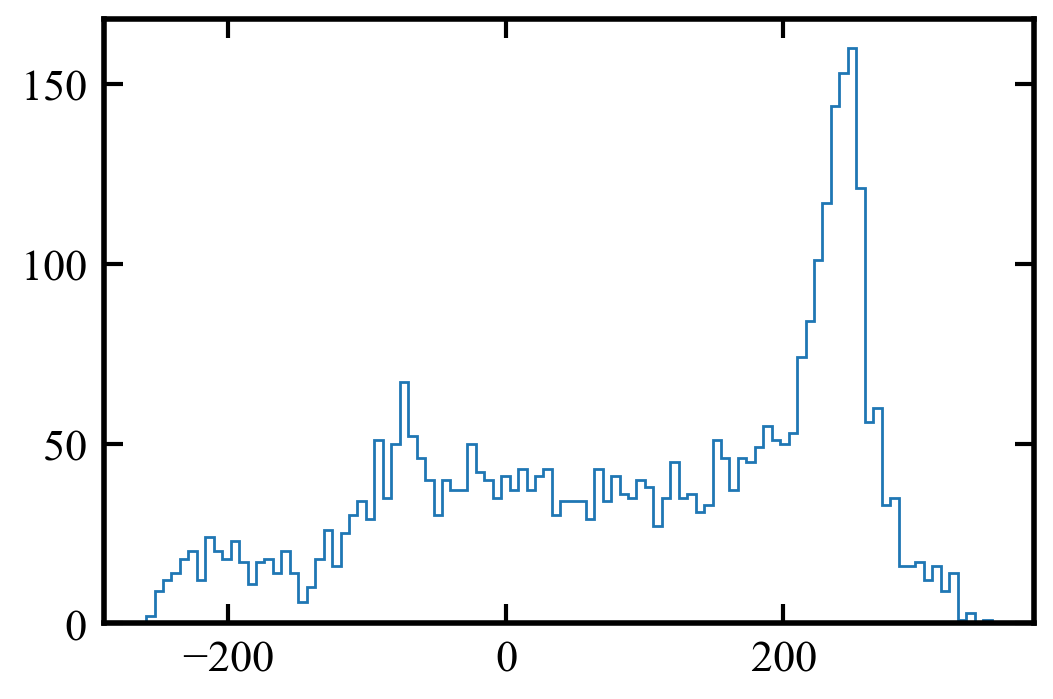

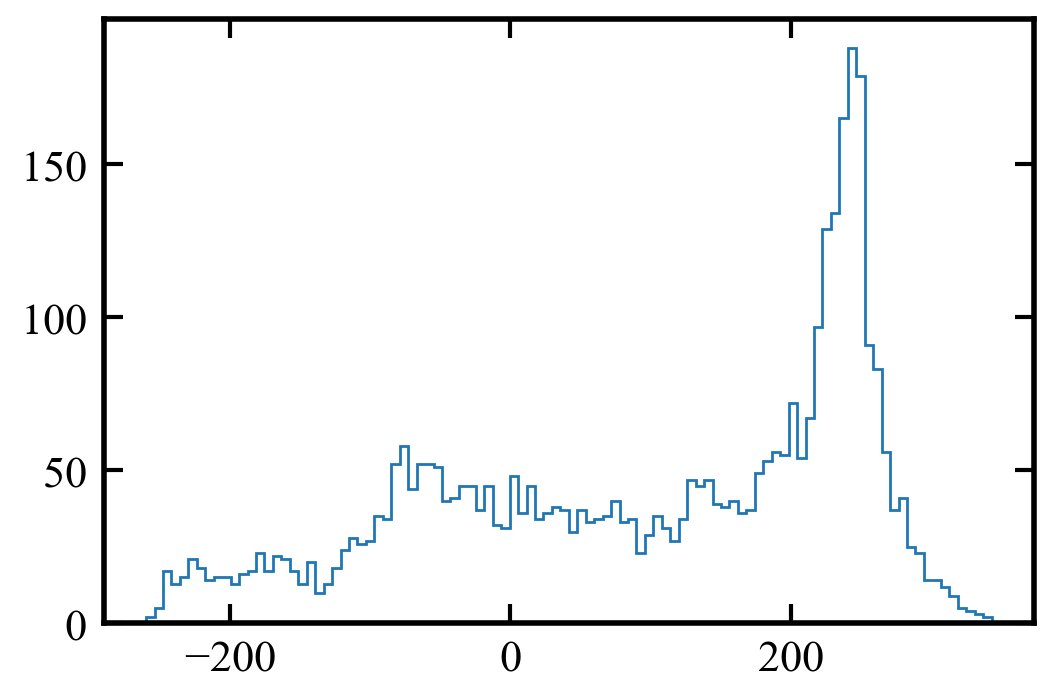

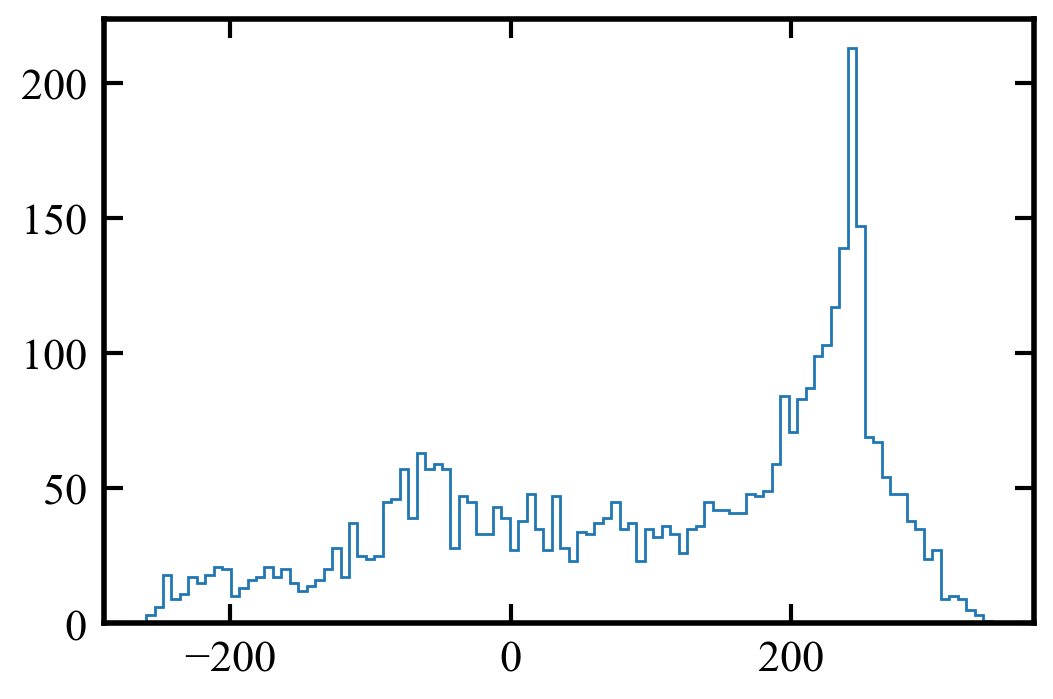

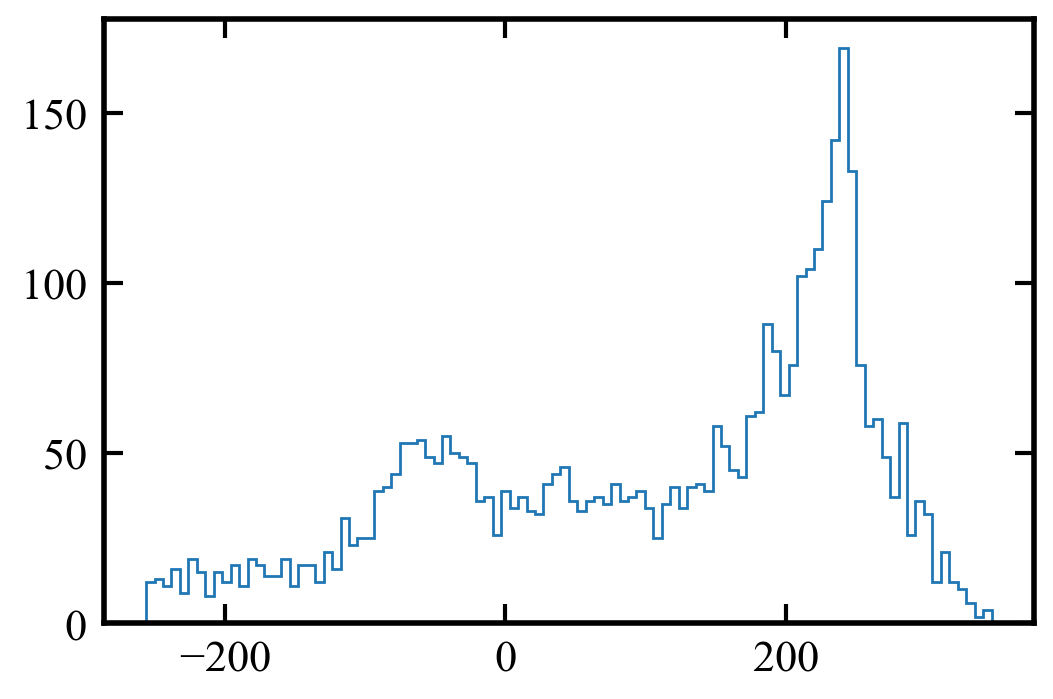

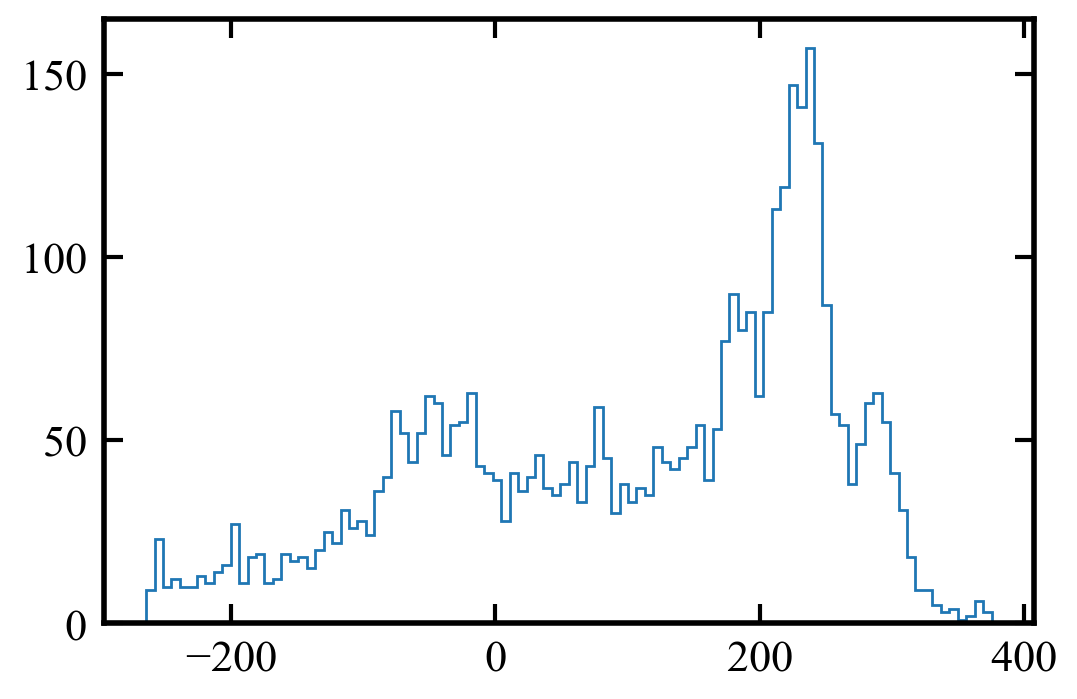

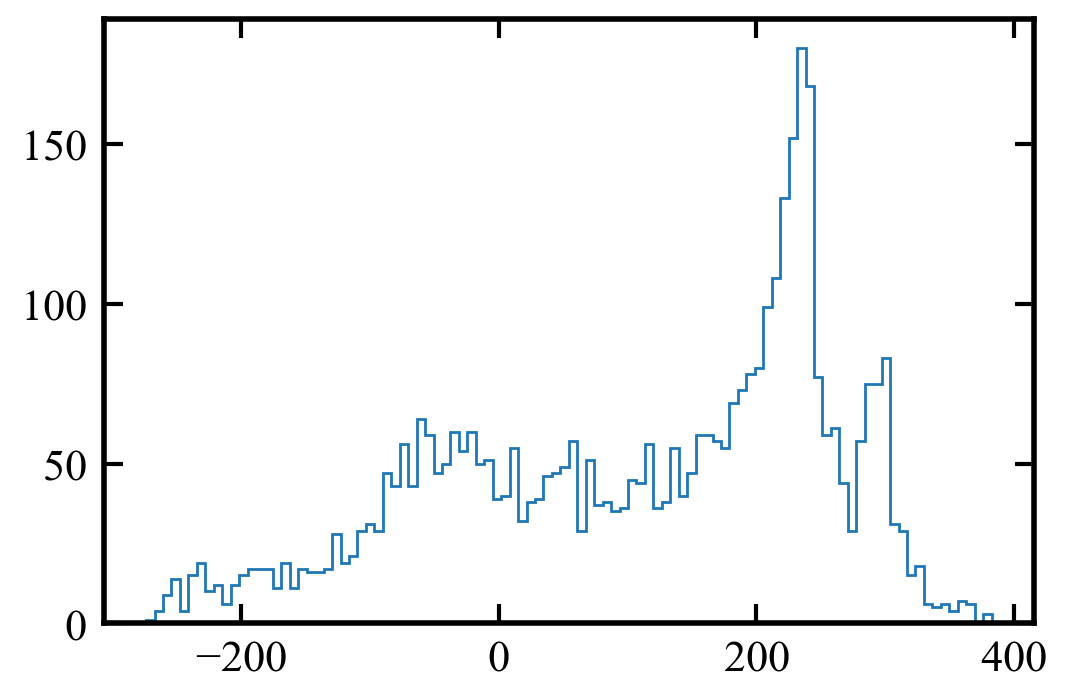

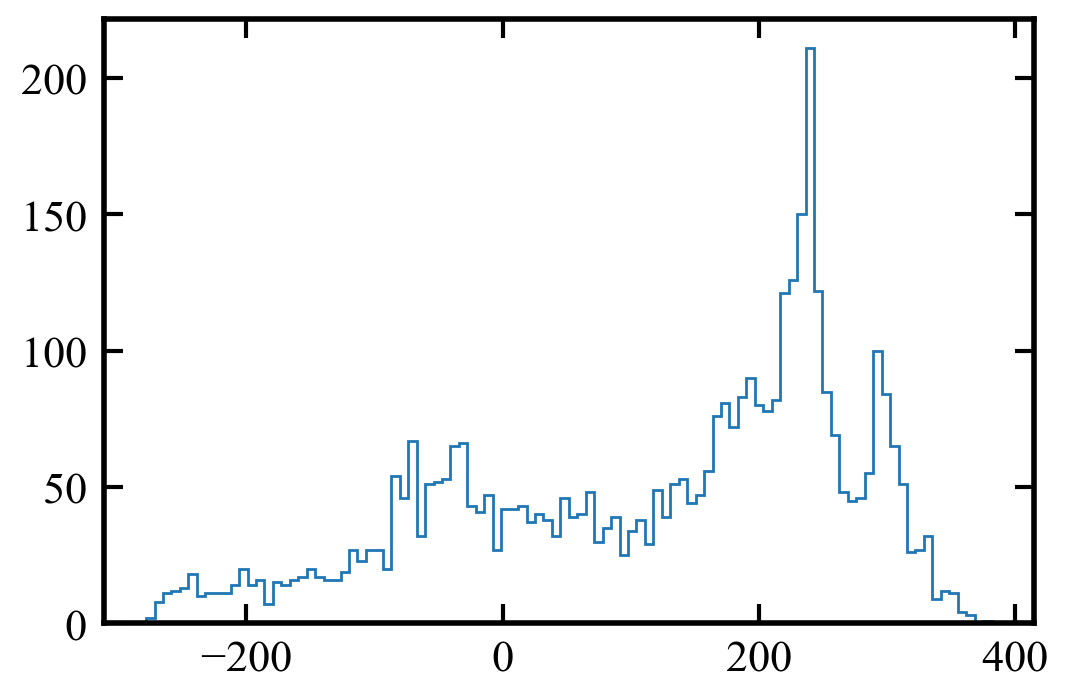

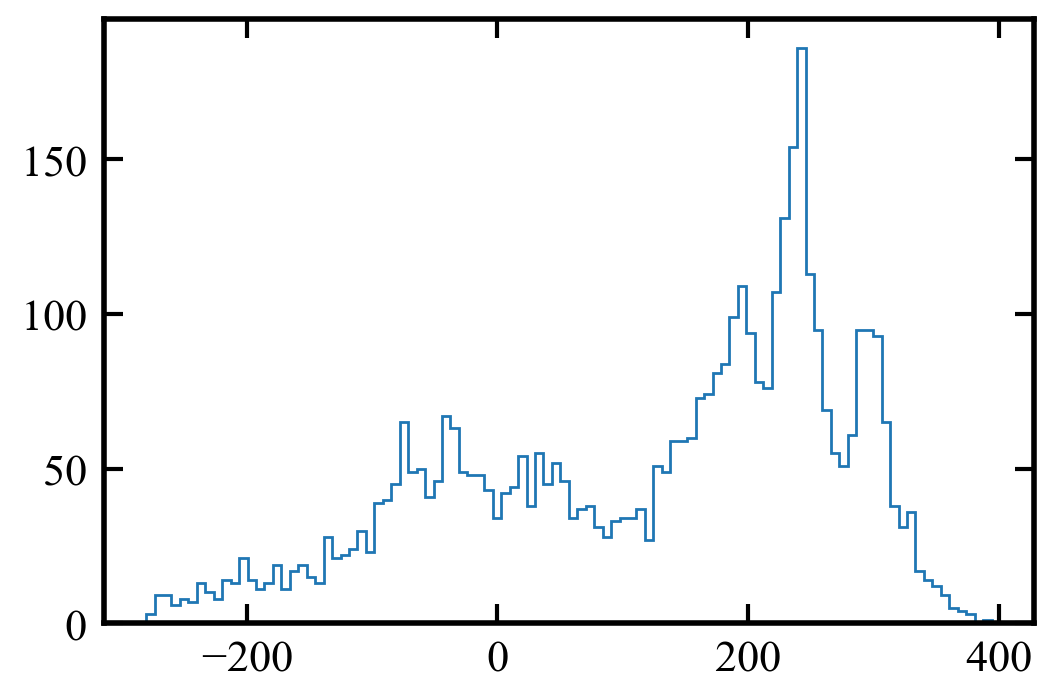

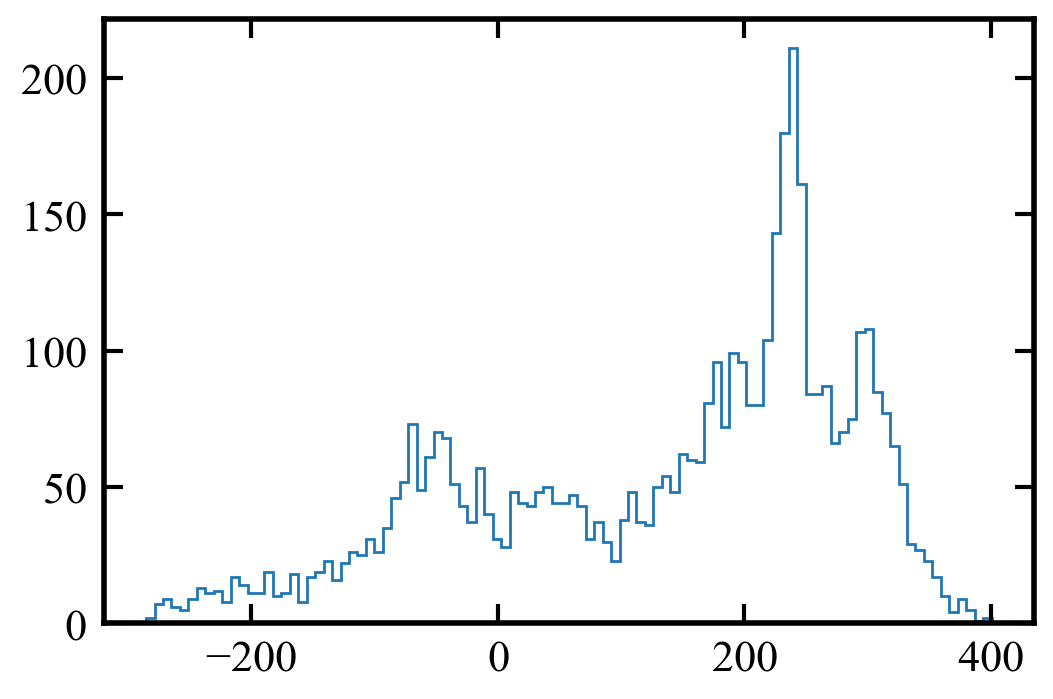

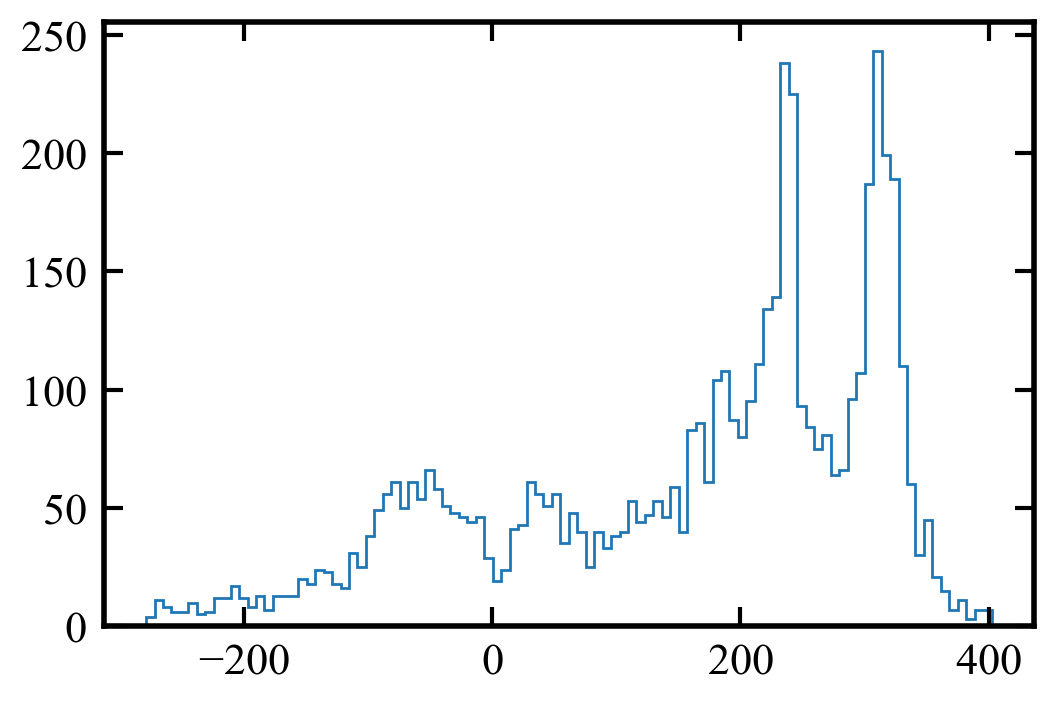

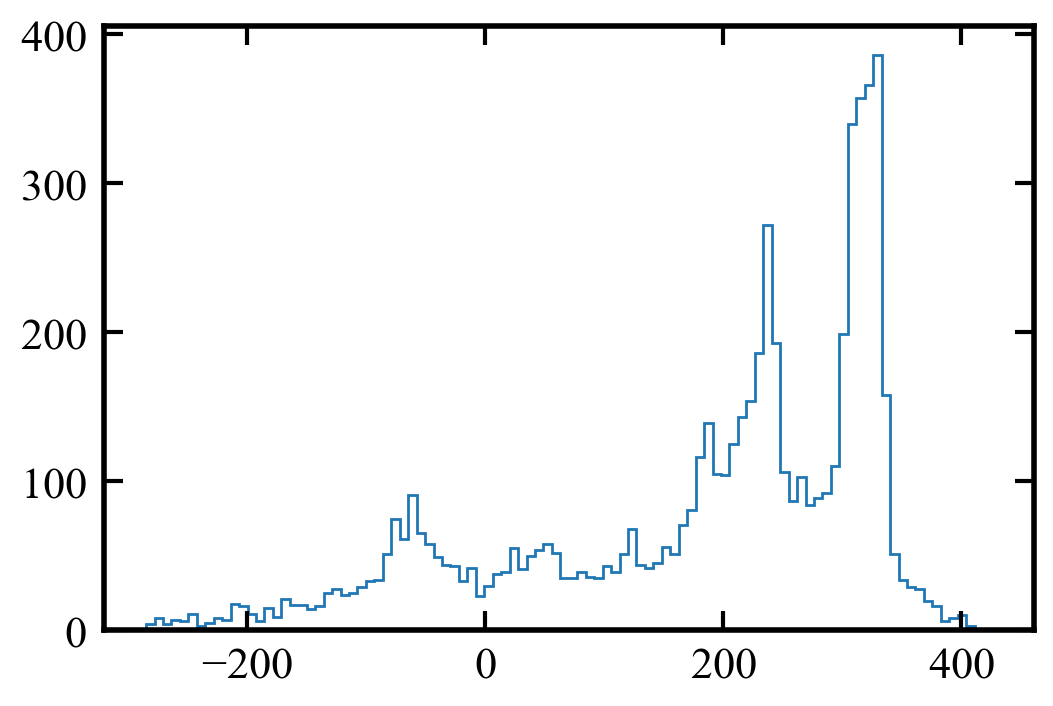

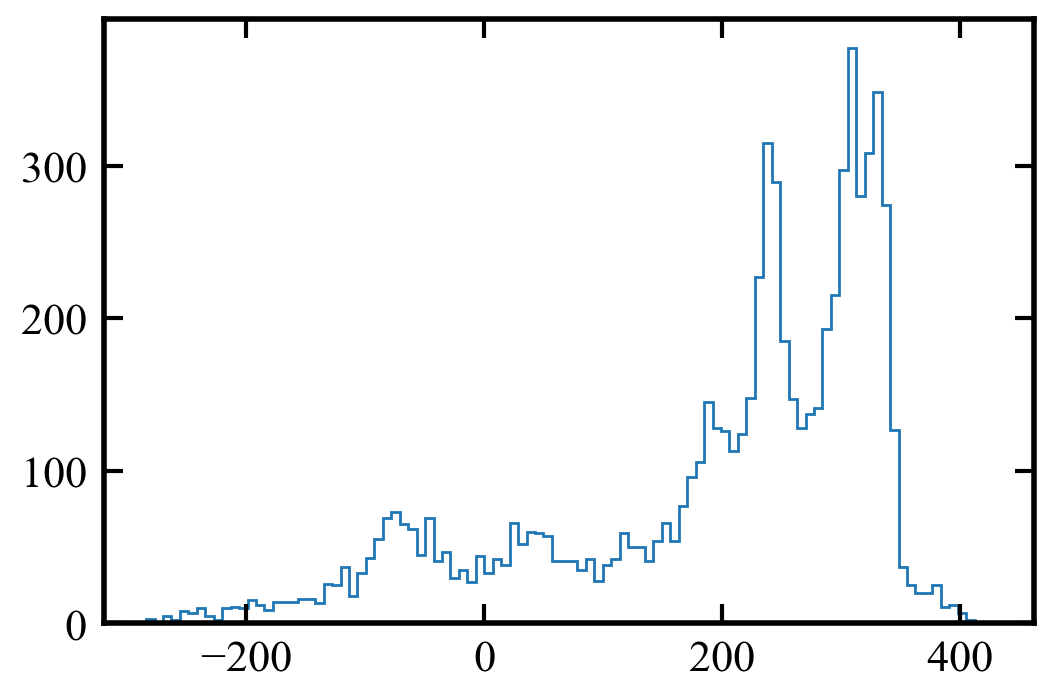

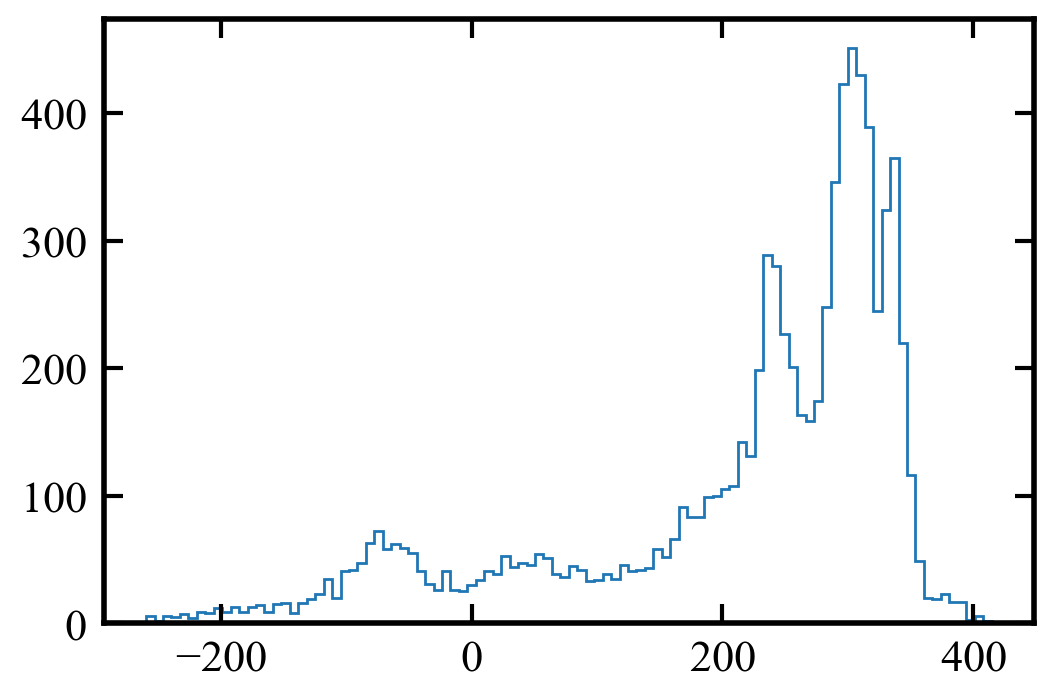

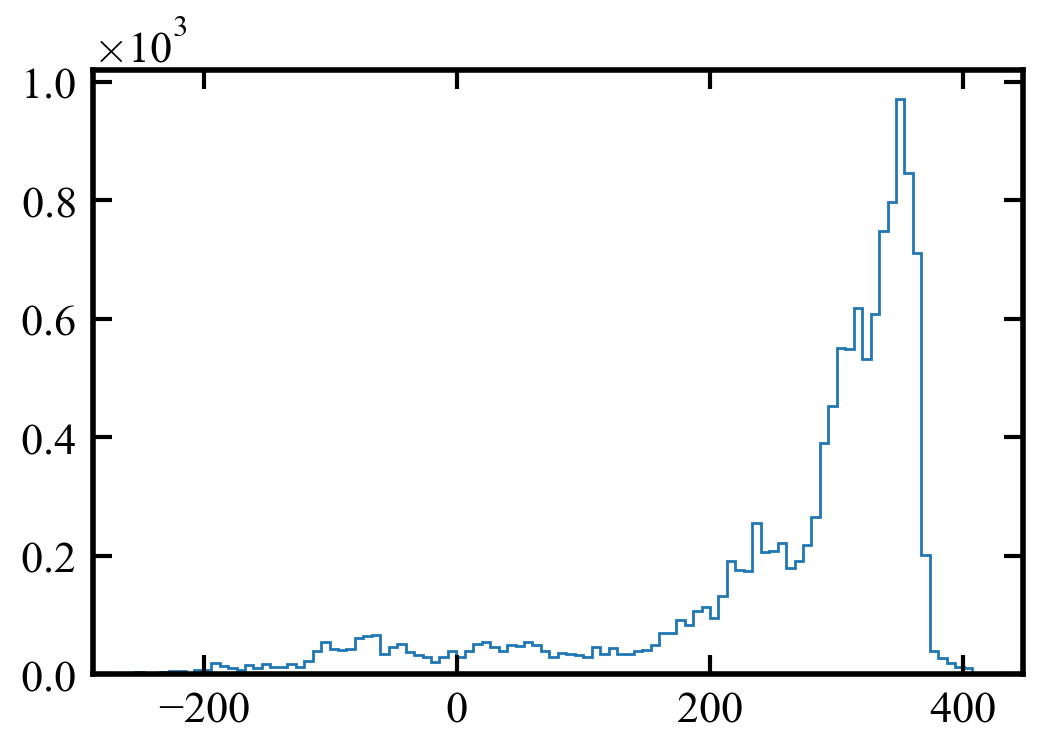

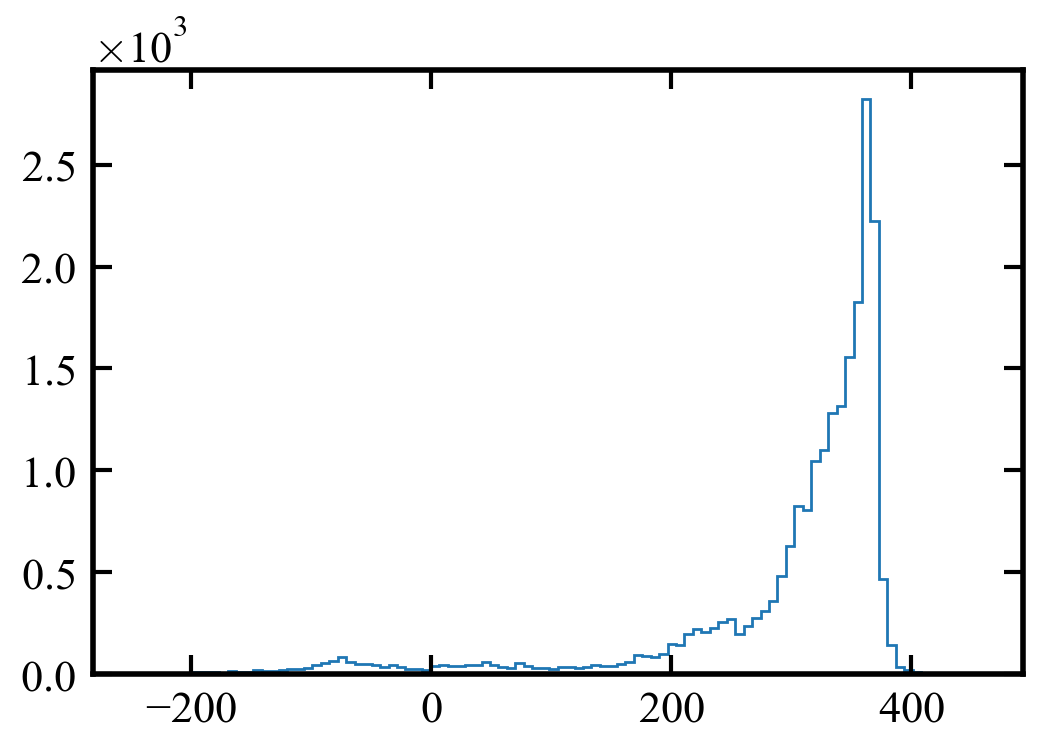

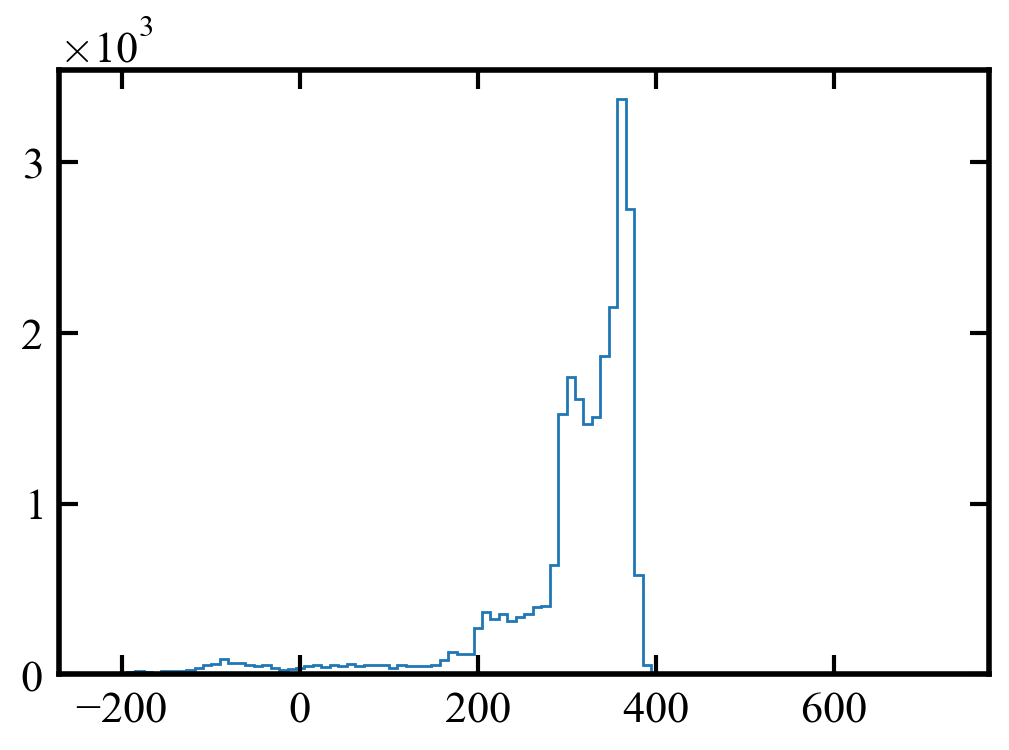

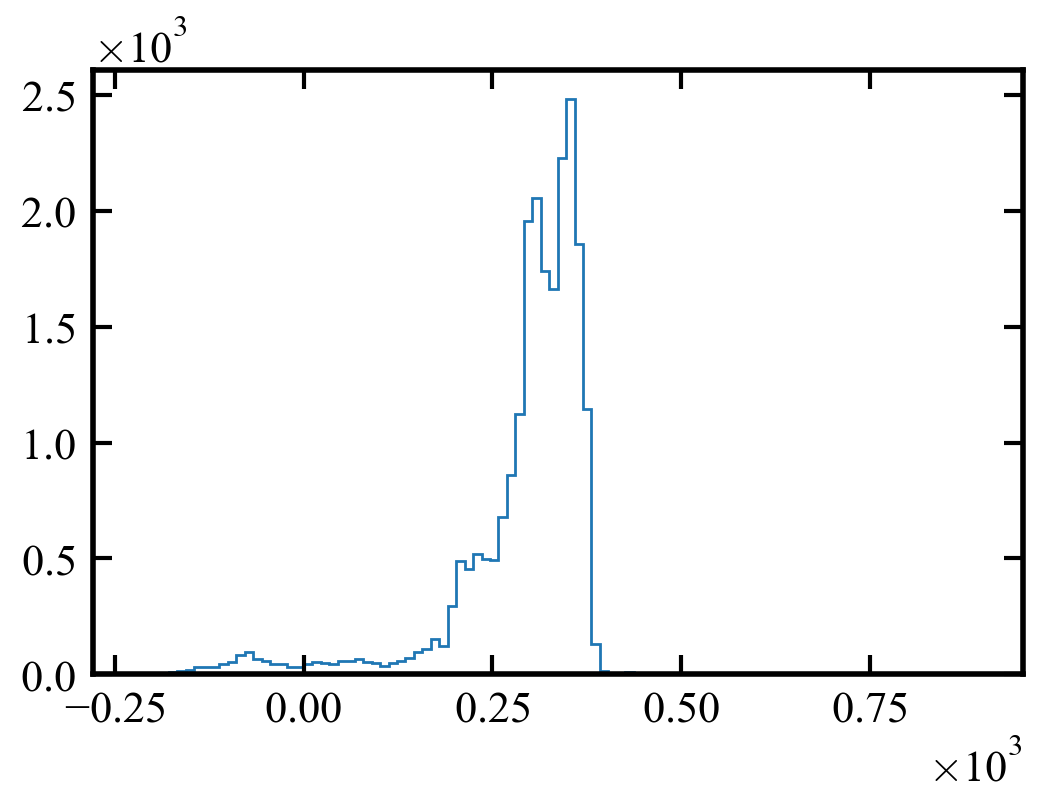

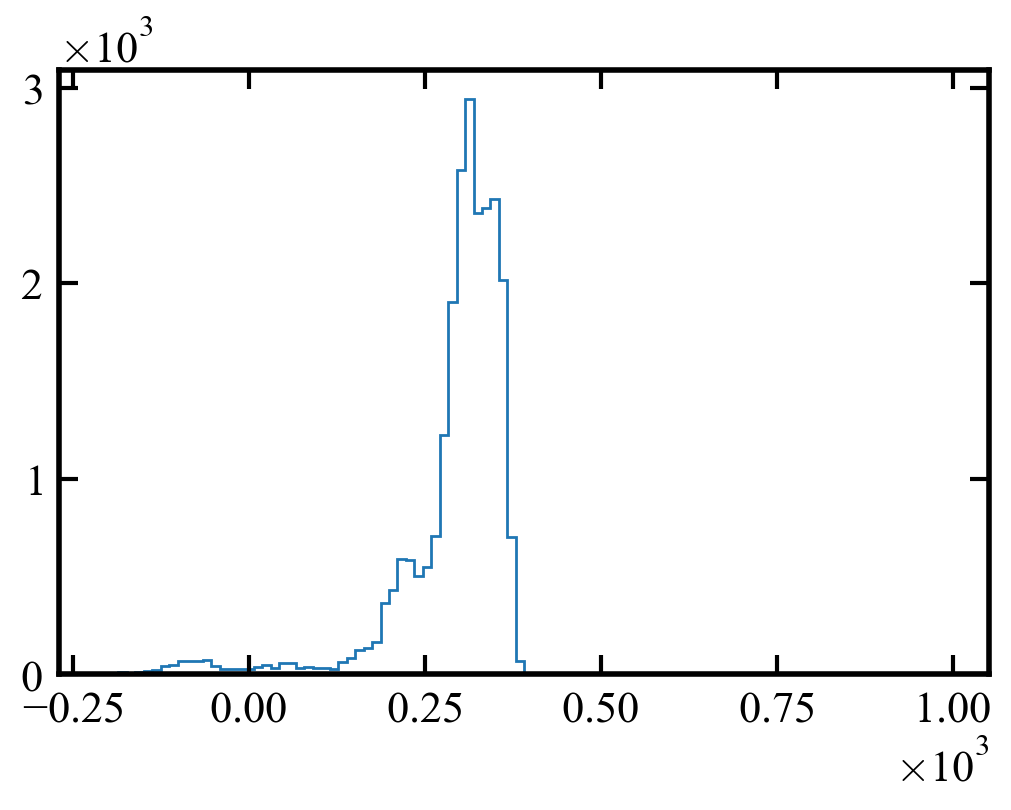

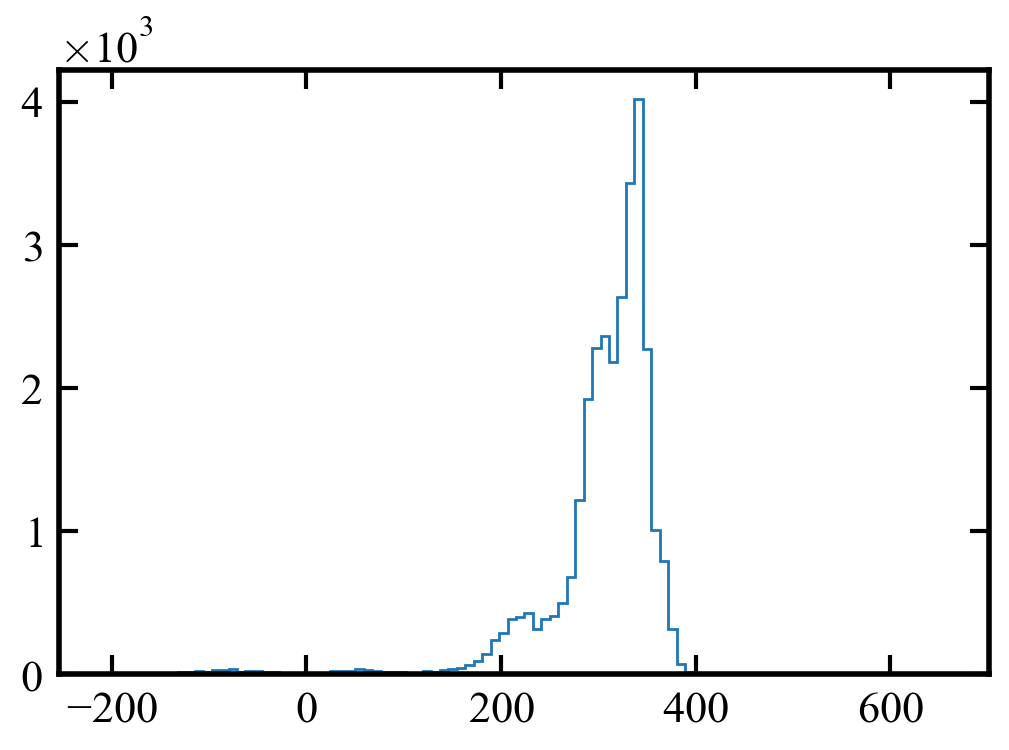

In [122]:
for ii in range(len(dist_bins)-1):
    gas_bin_mask = (coord_rot_cyl[:,0]>dist_bins[ii])&(coord_rot_cyl[:,0]<dist_bins[ii+1])

    plt.hist(v_theta[gas_bin_mask],bins=100,histtype='step')
    plt.show()

In [45]:
print np.sum(gas_mask)

0


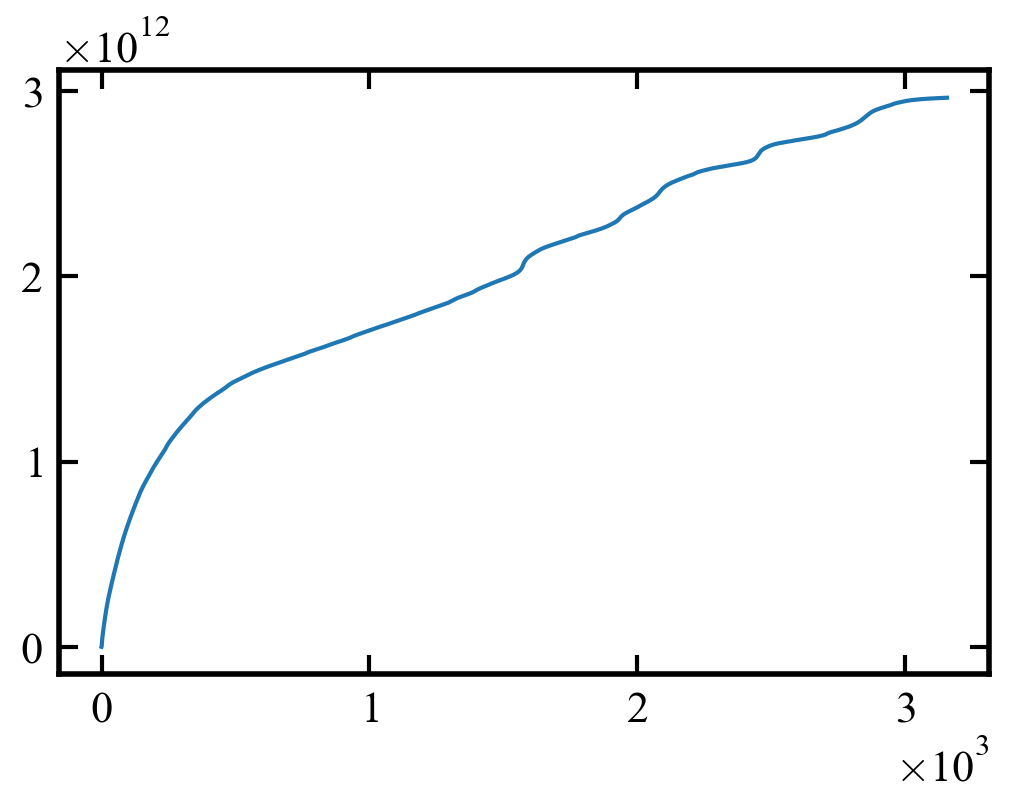

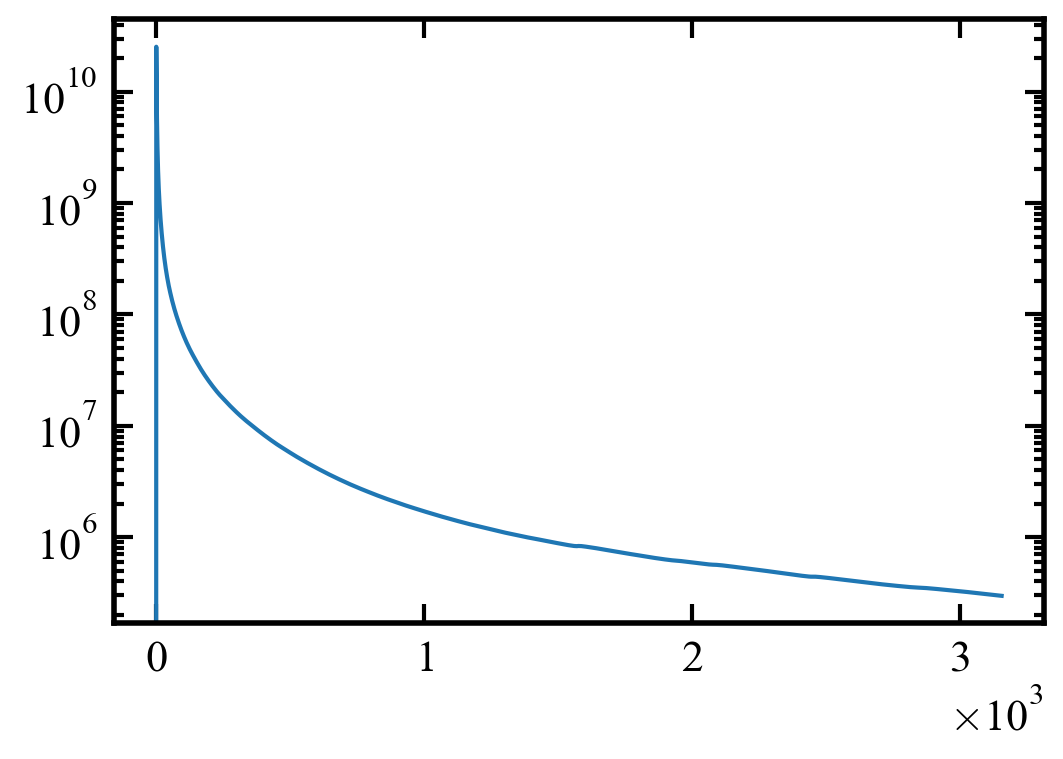

In [14]:
#first center coordinates 
coord_diff = star_coords-host_pos_train
coord_diff_gas = gas_coords-host_pos_train
coord_diff_dm = dm_coords-host_pos_train

vel_diff = star_vel - host_vel_train

dist = np.linalg.norm(coord_diff,axis=1)
dist_gas =np.linalg.norm(coord_diff_gas,axis=1)
dist_dm =np.linalg.norm(coord_diff_dm,axis=1)

#m_prof_bins = np.linspace(0.0,1000.0,5000)
m_prof_bins = np.logspace(-4.0,3.5,5000)

mass_profile_c, mpbins = np.histogram(dist,weights=star_mass,bins=m_prof_bins)
mass_profile_gas_c, mpbins  = np.histogram(dist_gas,weights=gas_mass,bins=m_prof_bins)
mass_profile_dm_c, mpbins  = np.histogram(dist_dm,weights=dm_mass,bins=m_prof_bins)

mass_profile_total_c = np.sum([np.cumsum(mass_profile_c),
                               np.cumsum(mass_profile_gas_c),
                               np.cumsum(mass_profile_dm_c)],axis=0)

m_prof_bins_plot = np.array([(m_prof_bins[ii]+m_prof_bins[ii+1])/2.0 for ii in 
                             range(len(m_prof_bins)-1)])

force_grav = np.divide(mass_profile_total_c,m_prof_bins_plot*m_prof_bins_plot)

plt.plot(m_prof_bins_plot,mass_profile_total_c)
plt.show()

plt.plot(m_prof_bins_plot,force_grav)
plt.yscale('log')
plt.show()

In [15]:
#do the interpolation

mass_profile_interp = interpolate.interp1d(m_prof_bins_plot,mass_profile_total_c)

In [16]:
import scipy.integrate as integrate
from scipy.optimize import fsolve


#solve for the energy of a particle
coord_test = np.linalg.norm(coord_diff[0])
vel_test = np.linalg.norm(vel_diff[0])

KE = 0.5*vel_test**2.0 #in km^2/s^2

G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

PE = G * integrate.quad(lambda x: mass_profile_interp(x)/x**2.0, coord_test, 999.0, limit=250)[0]

E_i = KE+PE

func = lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) - 
                             integrate.quad(lambda k: mass_profile_interp(k)/k**2.0, x, 999.0, 
                                            limit=250)[0])

r_c = fsolve(func,coord_test)

print coord_test
print r_c

j_c = np.sqrt(G * mass_profile_interp(r_c)/r_c)

print np.linalg.norm(np.cross(coord_diff[0],vel_diff[0]))
print j_c

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


9.571645574156491
[11.00370591]
1861.2601760980715
[233.23691957]


In [18]:
print m_prof_bins_plot[0]
mass_profile_interp(0.0+1.0e-3)

0.00010017302712261232


array(0.)

In [19]:
galaxy_mask = (dist<50.0)
print np.sum(galaxy_mask)

12490729


[-0.25230393 -0.00831013 -0.96761235]


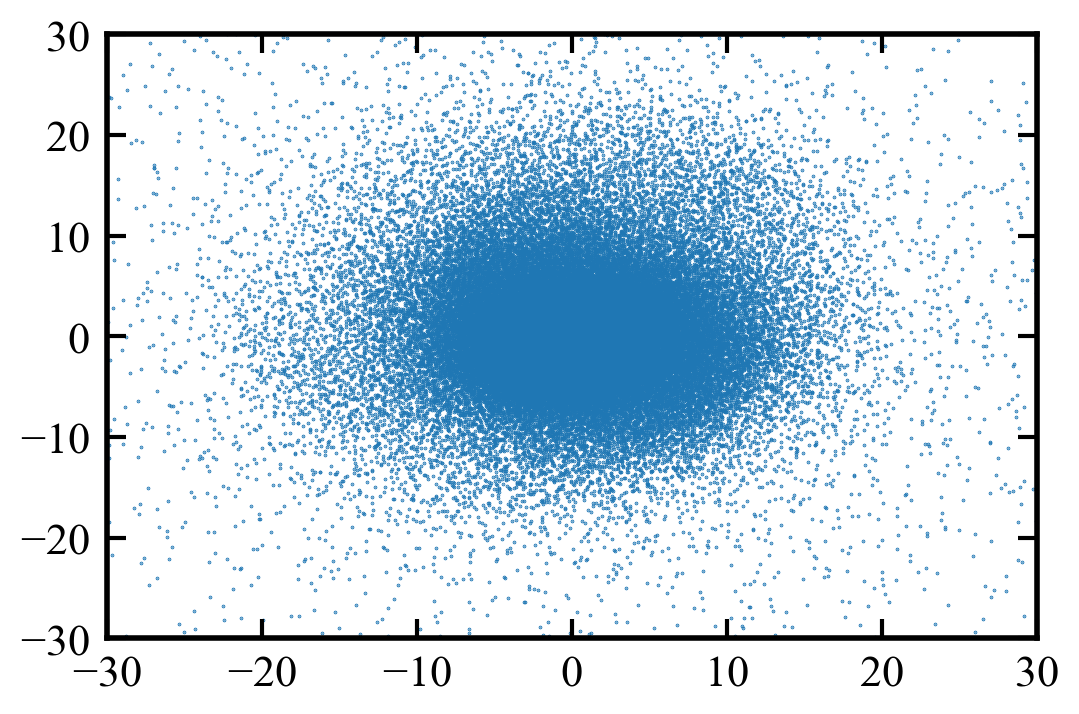

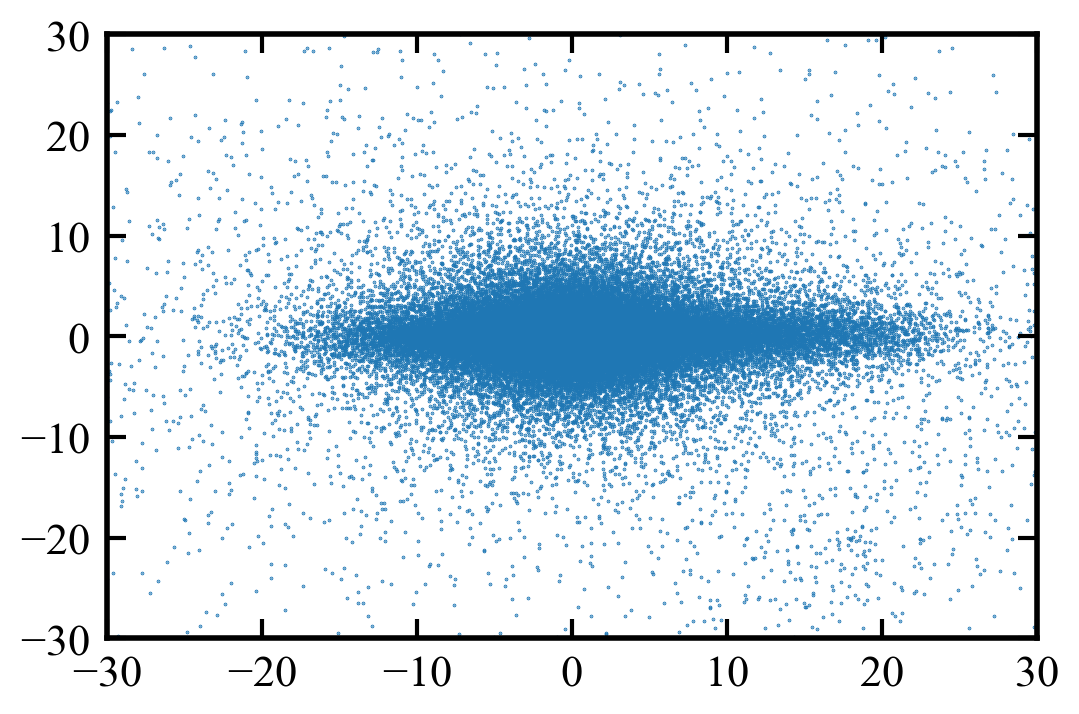

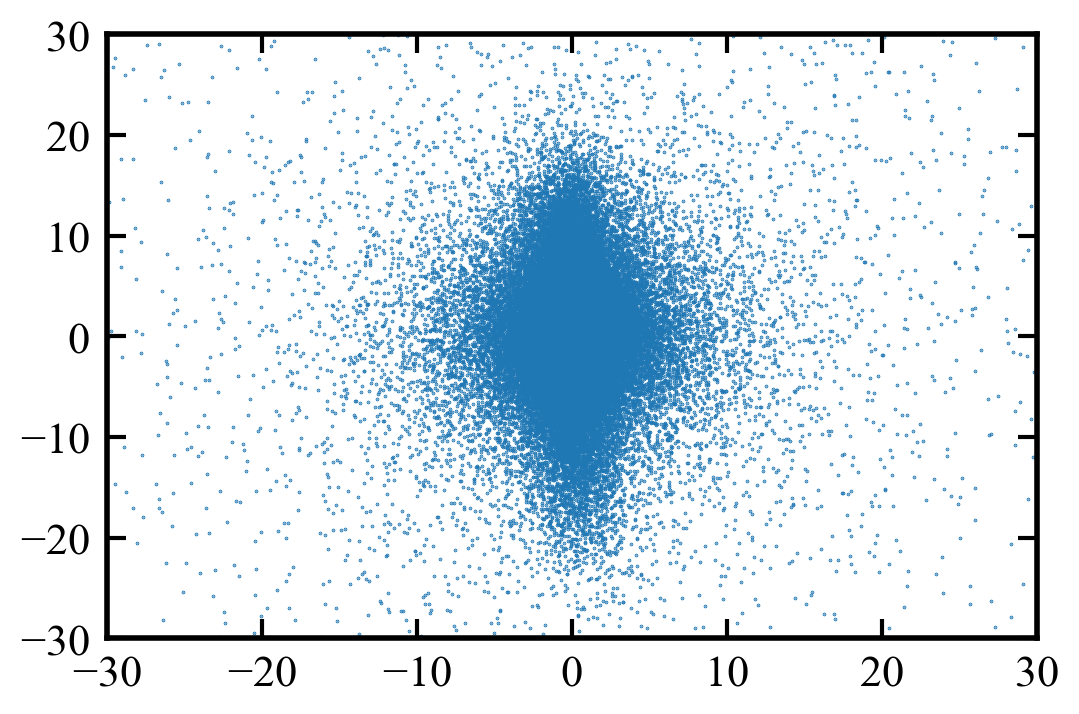

In [21]:
#Find the angular momentum vector and then rotate to that vector

#first center coordinates 
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist = np.linalg.norm(coord_diff,axis=1)
galaxy_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[galaxy_mask],star_mass[galaxy_mask],vel_diff[galaxy_mask])

part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

print L_vec

plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


In [67]:
coord_select = 1.0

print E_i

print m_prof_bins

r_c = fsolve(func,coord_select)

-91570.40311752298
[1.00000000e-04 1.00346054e-04 1.00693306e-04 ... 3.14050435e+03
 3.15137220e+03 3.16227766e+03]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


ValueError: A value in x_new is above the interpolation range.

In [68]:
#now it should be relatively easy to calculate the z component of the angular momentum
#just calculate r x v for the rotated particles and then take the z component

galaxy_mask = (dist<50.0)

coord_diff_gal = coord_diff[galaxy_mask]
vel_diff_gal = vel_diff[galaxy_mask]


ang_mom_rotated = np.cross(part_rotate,vel_rotate,axis=1) #kpc*km/s

ang_mom_rotated_gal = ang_mom_rotated[galaxy_mask]

G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

j_c_list, ang_mom_list = [], []

print('beginning loop')

for ii in range(len(coord_diff_gal))[::10000]:
    coord_select = np.linalg.norm(coord_diff_gal[ii])
    vel_select = np.linalg.norm(vel_diff_gal[ii])
    j_z = ang_mom_rotated_gal[ii]
    
    KE = 0.5*vel_select**2.0 #in km^2/s^2
    PE = -1.0 * G * integrate.quad(lambda x: mass_profile_interp(x+1.0e-3)/x**2.0,
                                   coord_select, 999.0, limit=250)[0]
    
    E_i = KE+PE
    
    if coord_select<0.0:
        print('There is a problem here, distance is {}'.format(coord_select))
        
    func = lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) -
                             integrate.quad(lambda k: mass_profile_interp(abs(k)+1.0e-3)/(k+1.0e-3)**2.0, x, 999.0, 
                                            limit=250)[0])
    
    try:
        r_c = fsolve(func,coord_select)
        j_c = np.sqrt(G * mass_profile_interp(r_c)*r_c) #km/s??
        j_c_list.append(j_c)
        ang_mom_list.append(j_z)
        
    except ValueError:
        print(coord_select,vel_select)
        continue
    
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

print len(ang_mom_rotated_gal[2]), len(j_c_list)

epsilon = np.divide(ang_mom_list,j_c_list)

beginning loop


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


3 1250


In [94]:
#now it should be relatively easy to calculate the z component of the angular momentum
#just calculate r x v for the rotated particles and then take the z component

galaxy_mask = (dist<50.0)

coord_diff_gal = coord_diff[galaxy_mask][::10000]
vel_diff_gal = vel_diff[galaxy_mask][::10000]

ang_mom_rotated = np.cross(part_rotate,vel_rotate,axis=1) #kpc*km/s

ang_mom_rotated_gal = ang_mom_rotated[galaxy_mask]

G = 4.30091e-6 #kpc (km/s)^2 M_sun^-1

print('beginning loop')

#Here is my attempt to vectorize most of this

#first create the coordinates and velocities outside the loop

dist_gal = np.linalg.norm(coord_diff_gal,axis=1)
vel_tot_gal = np.linalg.norm(vel_diff_gal,axis=1)

KE = 0.5*vel_tot_gal**2.0

#Now vectorize the PE integral and apply it

print('vectorizing PE integral')

def PE_integral(r):
    return -1.0 * G * integrate.quad(lambda x: mass_profile_interp(x+1.0e-3)/x**2.0,
                                   r, 999.0, limit=250)[0]

PE_int_vec = np.vectorize(PE_integral)
PE = PE_int_vec(dist_gal)

assert KE.shape==PE.shape

E_vec = KE+PE

print('vectorizing r_c solver')

#is this correct??
def r_c_solver(E_i,r):
    return fsolve(lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) -
                             integrate.quad(lambda k: mass_profile_interp(abs(k)+1.0e-3)/(k+1.0e-3)**2.0, x, 999.0, 
                                          limit=250)[0]),r)
r_c_vectorize = np.vectorize(r_c_solver)
r_c_vec = r_c_vectorize(E_vec,dist_gal)

print('calculating j_c')

j_c = np.sqrt(G * mass_profile_interp(r_c_vec)*r_c_vec)

epsilon = np.divide(ang_mom_list[:,2],j_c)

'''
for ii in range(len(coord_diff_gal))[::10000]:
    coord_select = np.linalg.norm(coord_diff_gal[ii])
    vel_select = np.linalg.norm(vel_diff_gal[ii])
    j_z = ang_mom_rotated_gal[ii]
    
    KE = 0.5*vel_select**2.0 #in km^2/s^2
    PE = -1.0 * G * integrate.quad(lambda x: mass_profile_interp(x+1.0e-3)/x**2.0,
                                   coord_select, 999.0, limit=250)[0]
    
    E_i = KE+PE
    
    if coord_select<0.0:
        print('There is a problem here, distance is {}'.format(coord_select))
        
    func = lambda x : E_i - G * (mass_profile_interp(x)/(2.0*x) -
                             integrate.quad(lambda k: mass_profile_interp(abs(k)+1.0e-3)/(k+1.0e-3)**2.0, x, 999.0, 
                                            limit=250)[0])
    
    try:
        r_c = fsolve(func,coord_select)
        j_c = np.sqrt(G * mass_profile_interp(r_c)*r_c) #km/s??
        j_c_list.append(j_c)
        ang_mom_list.append(j_z)
        
    except ValueError:
        print(coord_select,vel_select)
        continue
    
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)'''

#print len(ang_mom_rotated_gal[2]), len(j_c_list)

beginning loop
vectorizing PE integral


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


vectorizing r_c solver


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


calculating j_c


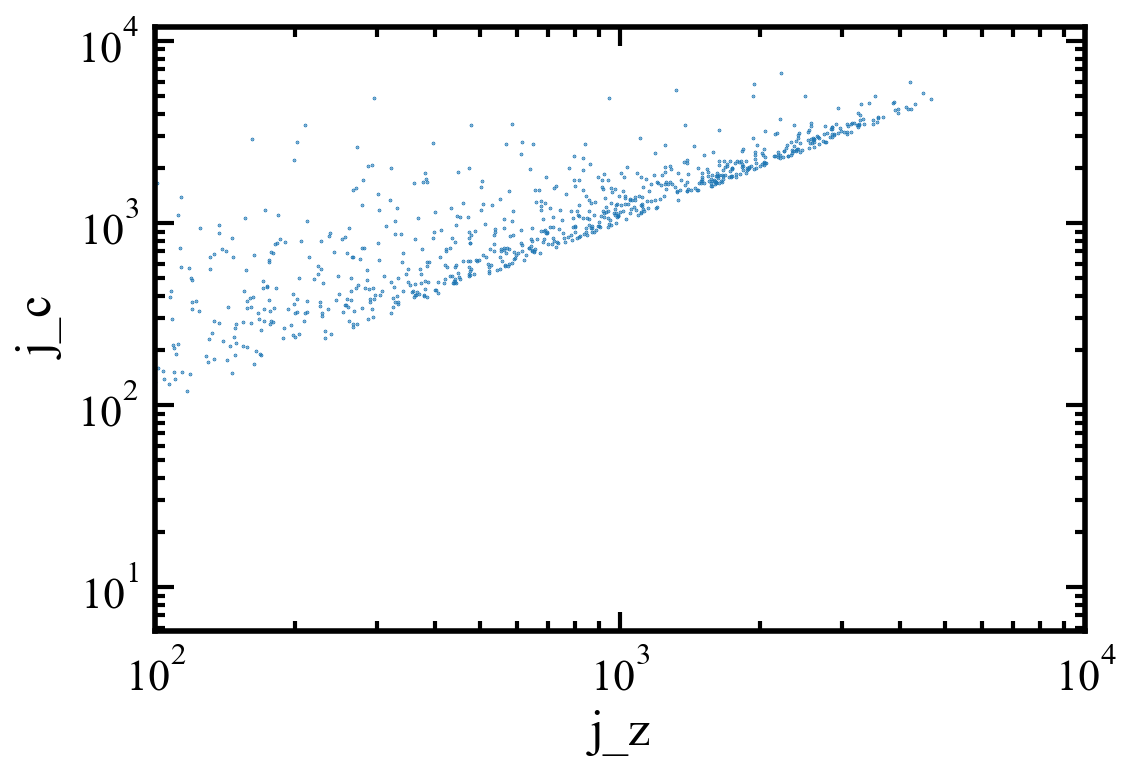

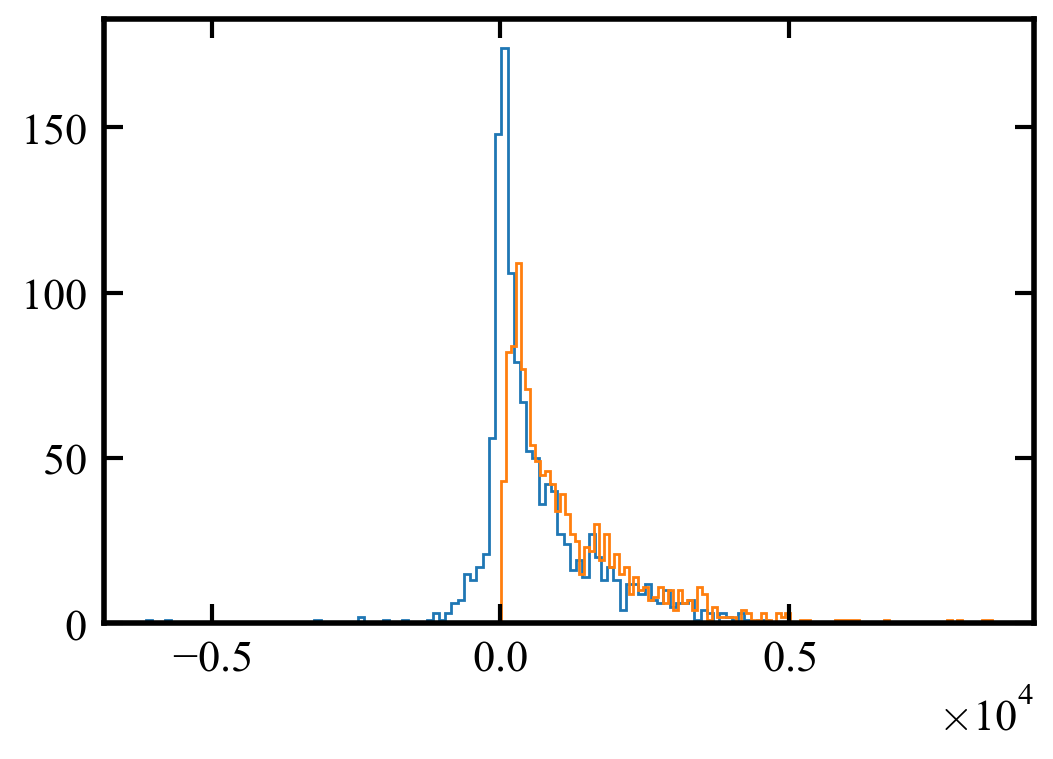

In [69]:
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

plt.scatter(ang_mom_list[:,2],np.ndarray.flatten(j_c_list),s = 0.1)
plt.xlabel('j_z')
plt.ylabel('j_c')
plt.xscale('log')
plt.yscale('log')
plt.xlim([100.0,1.0e4])
plt.show()

plt.hist(ang_mom_list[:,2],bins=100,histtype='step')
plt.hist(np.ndarray.flatten(j_c_list),bins=100,histtype='step')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim([100.0,1.0e4])
plt.show()

(1250,) (1250,)
[ 0.93876735  0.92290015  0.59911183 ... -0.51498845  0.61553028
  0.79853484]
[ 0.93876735  0.92290015  0.59911183 ... -0.51498845  0.61553028
  0.79853484]


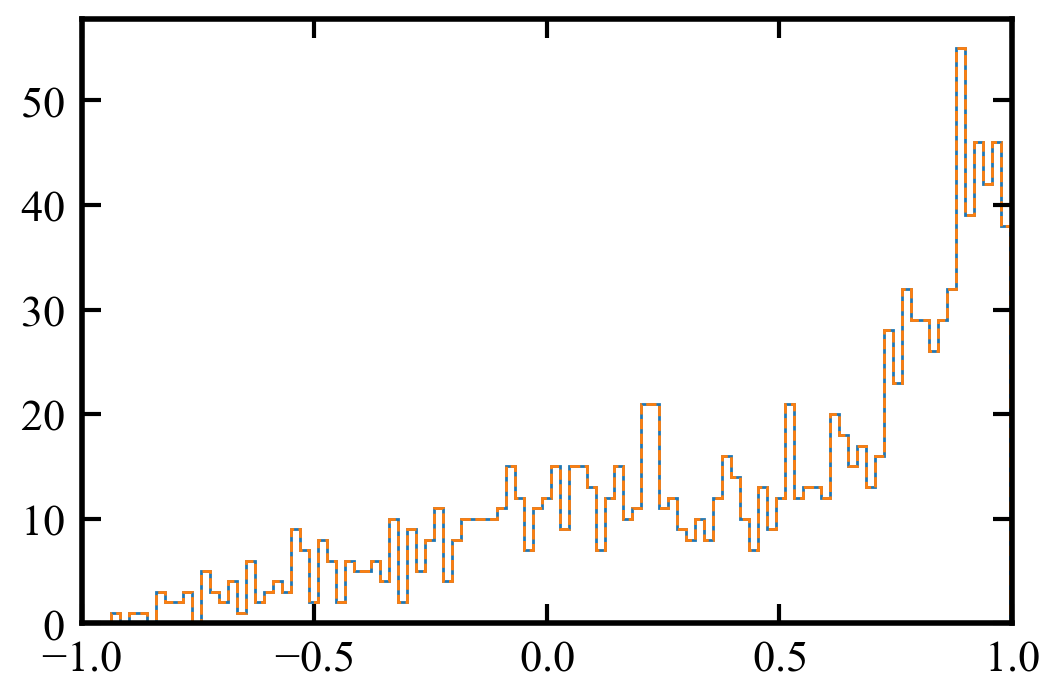

In [105]:
j_c_list = np.array(j_c_list)
ang_mom_list = np.array(ang_mom_list)

print np.ndarray.flatten(j_c_list).shape, ang_mom_list[:,2].shape

epsilon = np.divide(ang_mom_list[:,2],j_c)
epsilon_list = np.divide(ang_mom_list[:,2],np.ndarray.flatten(j_c_list))

print epsilon
print epsilon_list

#epsilon_list = np.divide(ang_mom_list[:,2],np.ndarray.flatten(j_c_list))

plt.hist(epsilon,bins=100,histtype='step')
plt.hist(epsilon_list,bins=100,histtype='step',linestyle='--')
plt.xlim([-1.0,1.0])
plt.show()

[-0.25230393 -0.00831013 -0.96761235]


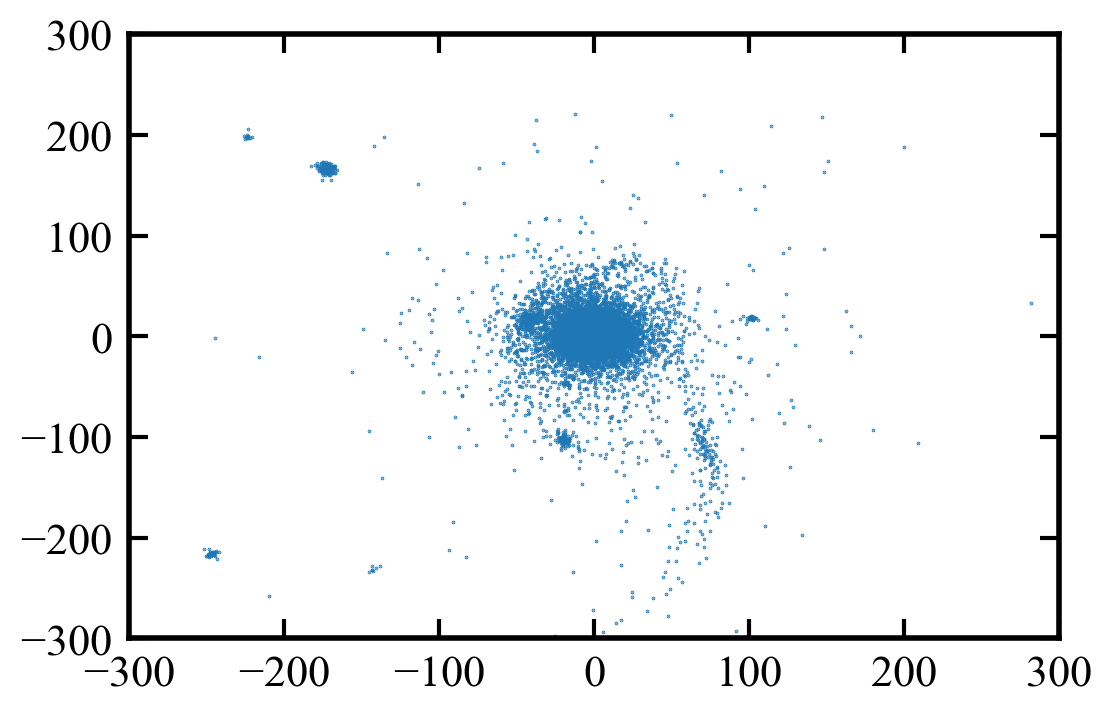

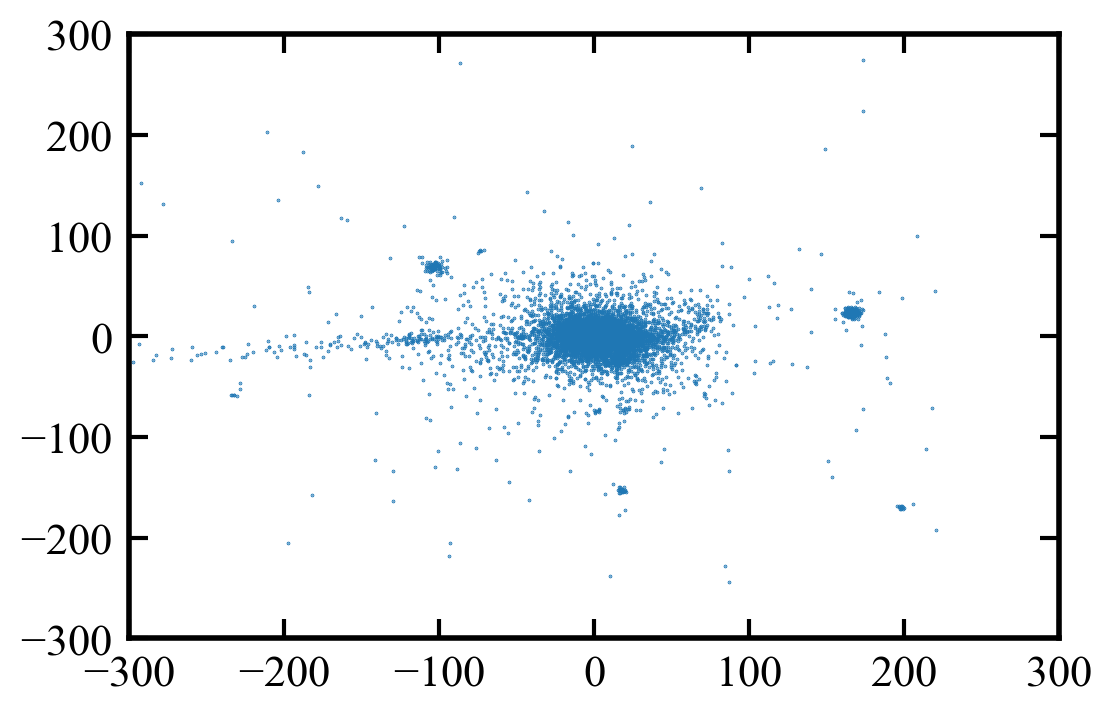

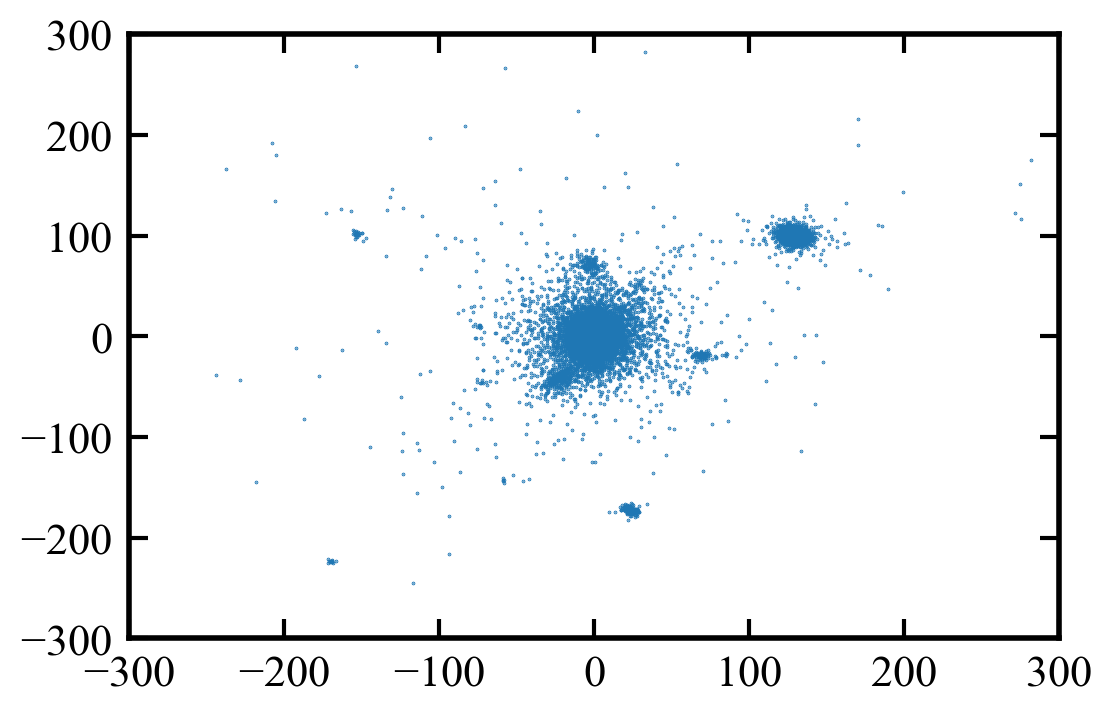

In [58]:
#Find the angular momentum vector and then rotate to that vector

#first center coordinates 
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist = np.linalg.norm(coord_diff,axis=1)
galaxy_mask = (dist<20.0)

L_vec =  Calc_average_L_shift(coord_diff[galaxy_mask],star_mass[galaxy_mask],vel_diff[galaxy_mask])

part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

print L_vec

plt.scatter(part_rotate[:,0][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::100],part_rotate[:,2][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


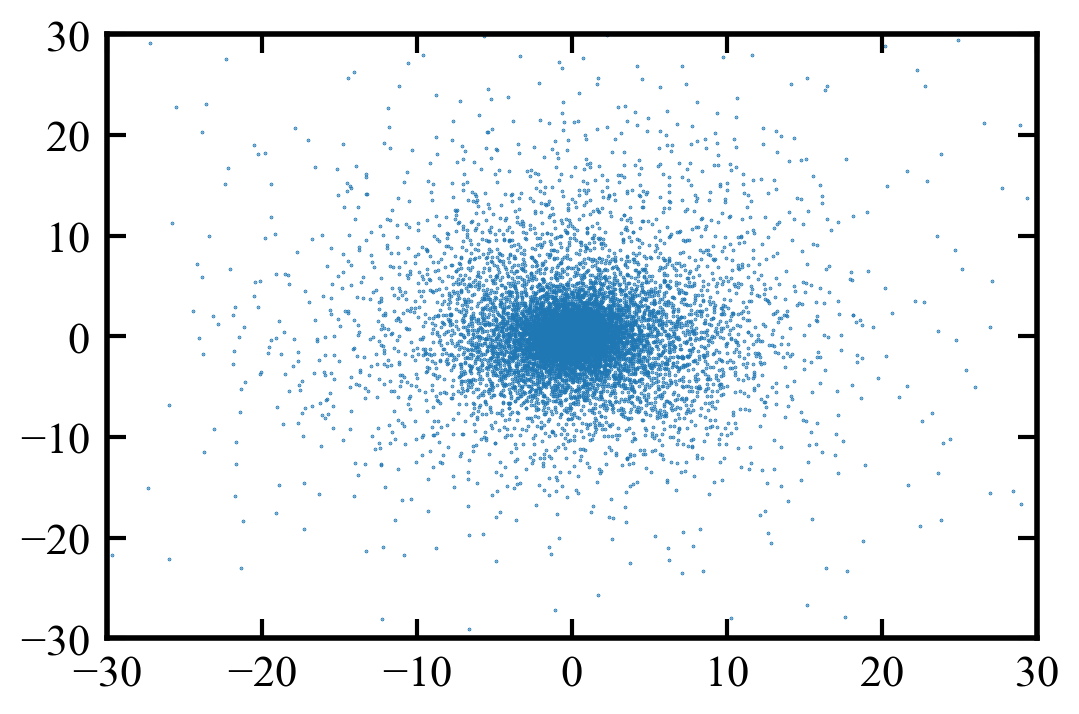

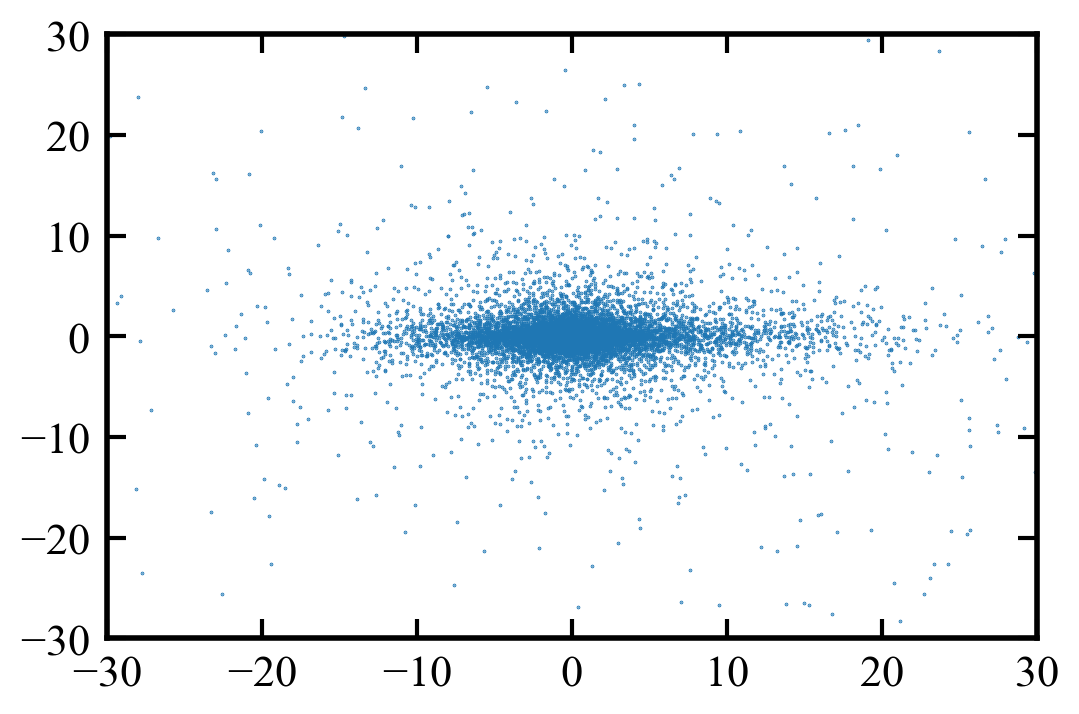

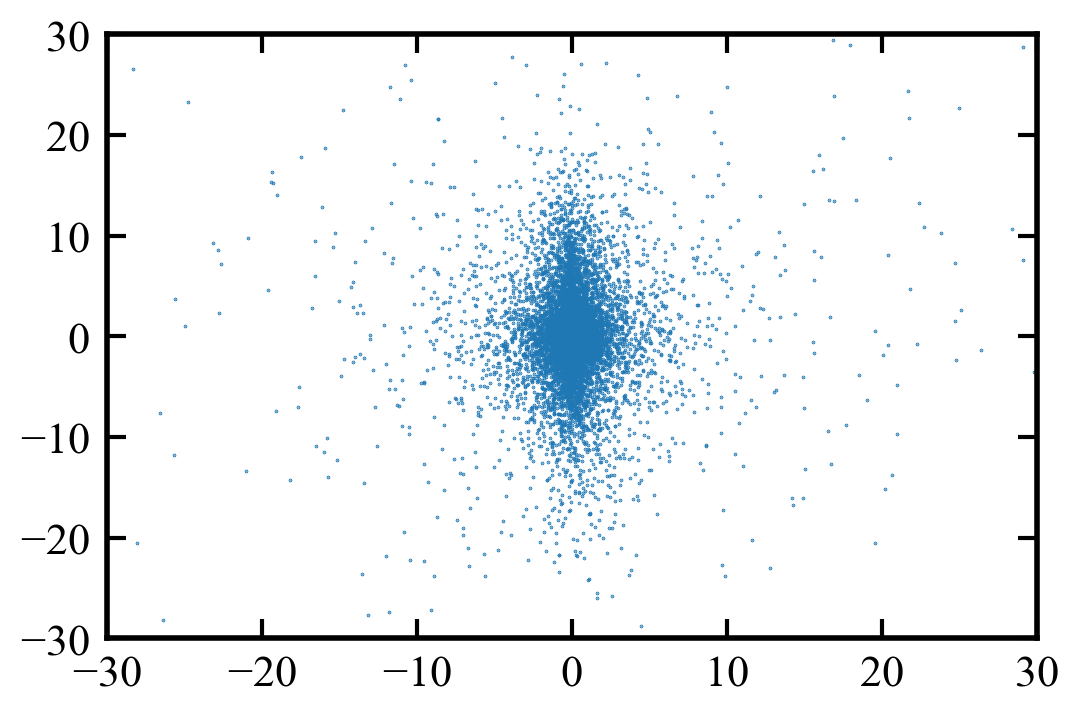

In [61]:
plt.scatter(part_rotate[:,0][::1000],part_rotate[:,1][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,1][::1000],part_rotate[:,2][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate[:,2][::1000],part_rotate[:,0][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

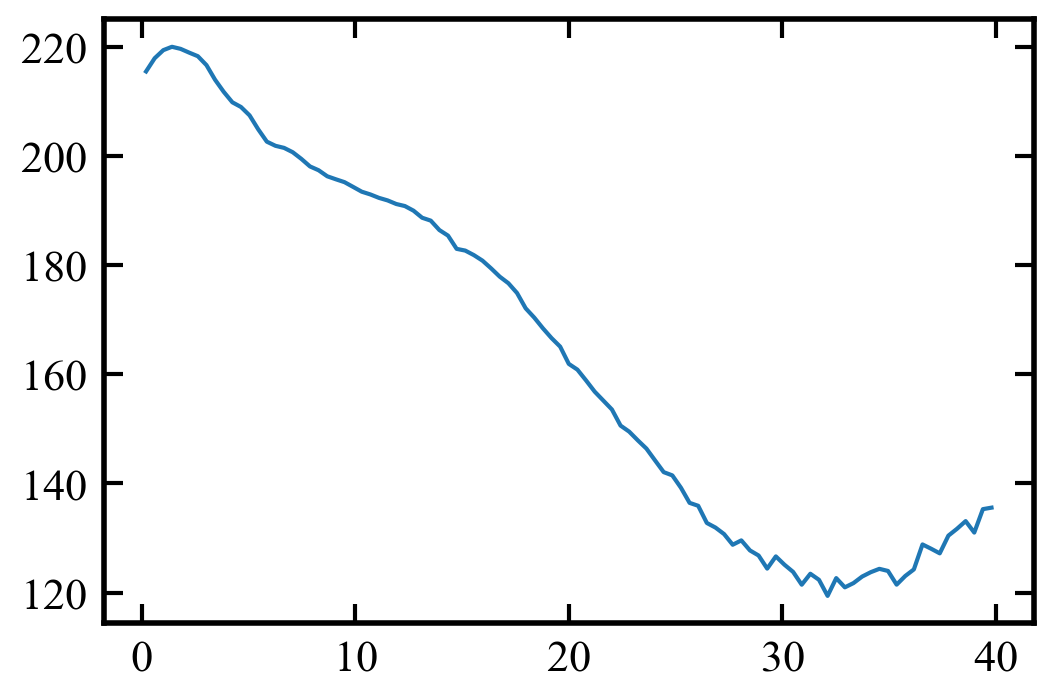

In [68]:
R_xy = coord_cyl_disk[:,0]
v_phi = np.sqrt(vel_rotate[:,0]**2.0+vel_rotate[:,1]**2.0)

r_bins = np.linspace(0.0,40.0,100)

R_list,v_list = [],[]

for ii in range(len(r_bins)-1):
    bin_mask = (R_xy>=r_bins[ii])&(R_xy<r_bins[ii+1])
    R_list.append((r_bins[ii]+r_bins[ii+1])/2.0)
    v_list.append(np.mean(v_phi[bin_mask]))
    
plt.plot(R_list,v_list)
plt.show()


In [ ]:
#for a given particle I need to do the integral over the interpolation function to get M(<r)



In [ ]:
#now it should be relatively easy to calculate the z component of the angular momentum
#just calculate r x v for the rotated particles and then take the z component

ang_mom_rotated = np.cross(part_rotate,vel_rotate,axis=1)



[-0.24233836  0.01721632 -0.97003903]


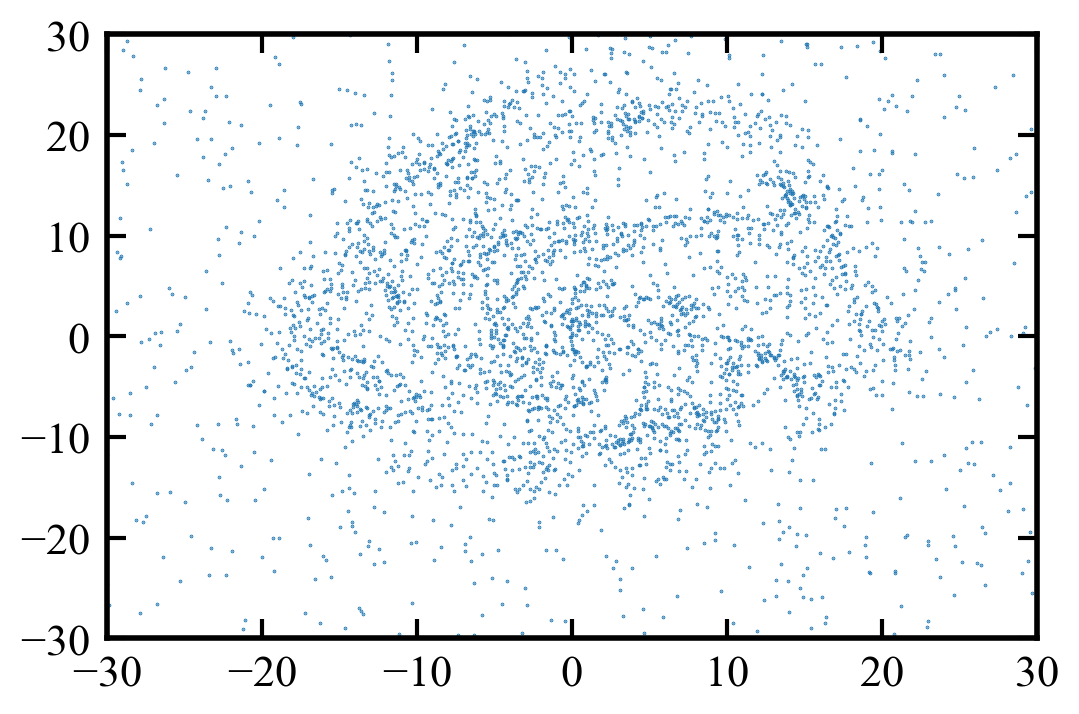

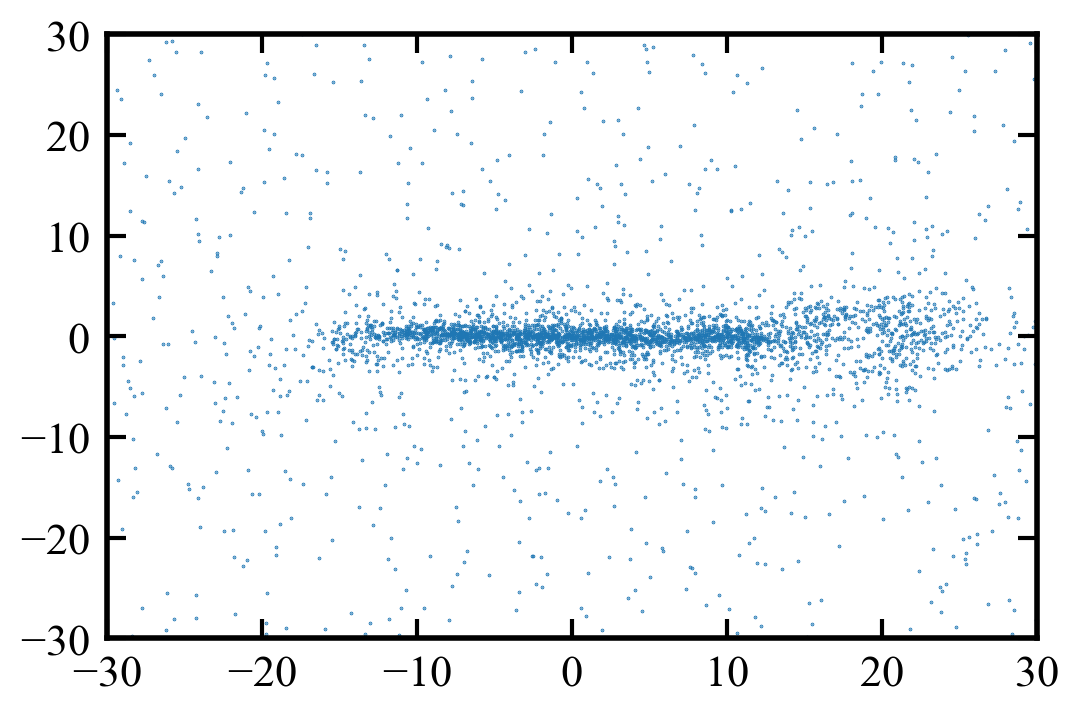

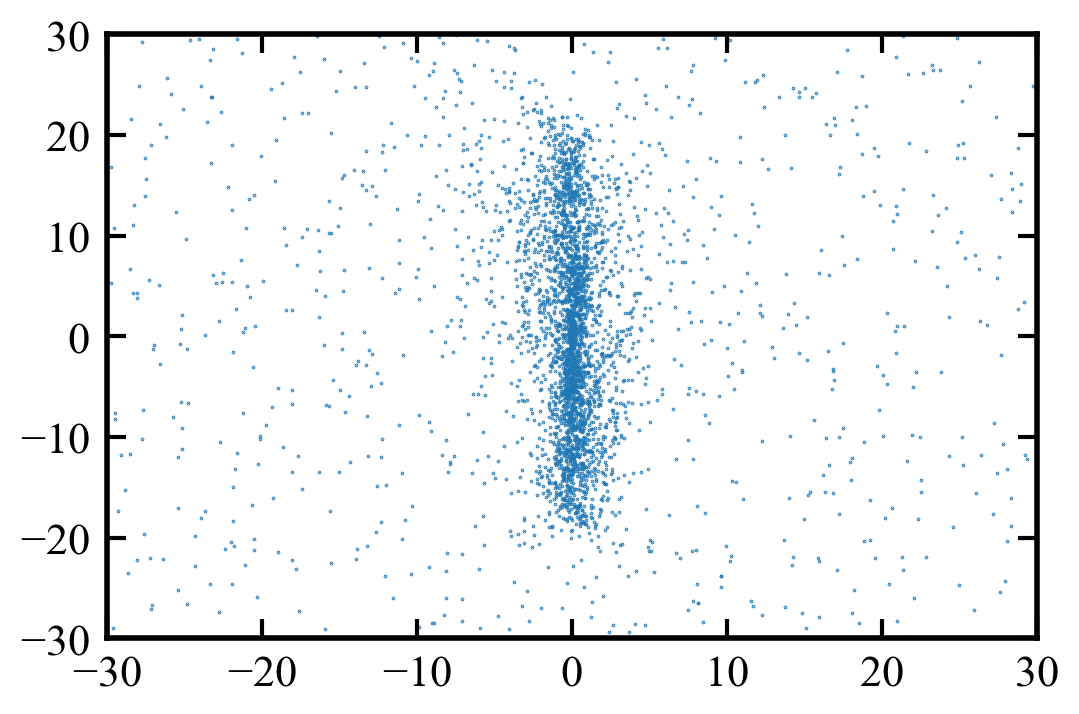

In [73]:
#Do ang mom for the gas

#first center coordinates 
coord_diff_gas = gas_coords-host_pos_train
vel_diff_gas = gas_vel-host_vel_train

#I can actually just do it when I'm calculating L_vec and then go back to the normal
#coordiantes for the transform

dist_gas = np.linalg.norm(coord_diff_gas,axis=1)
galaxy_mask_gas = (dist_gas<20.0)

L_vec_gas =  Calc_average_L_shift(coord_diff_gas[galaxy_mask_gas],
                                  gas_mass[galaxy_mask_gas],
                                  vel_diff_gas[galaxy_mask_gas])

part_rotate_gas, vel_rotate_gas =  Rotate_to_z_axis(coord_diff_gas,vel_diff_gas,L_vec_gas)

coord_cyl_disk_gas, vel_cyl_disk_gas = convert_to_cylindrical(part_rotate_gas,vel_rotate_gas)

print L_vec_gas

plt.scatter(part_rotate_gas[:,0][::1000],part_rotate_gas[:,1][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate_gas[:,1][::1000],part_rotate_gas[:,2][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()

plt.scatter(part_rotate_gas[:,2][::1000],part_rotate_gas[:,0][::1000],s=0.1)

plt.xlim([-30.0,30.0])
plt.ylim([-30.0,30.0])
plt.show()


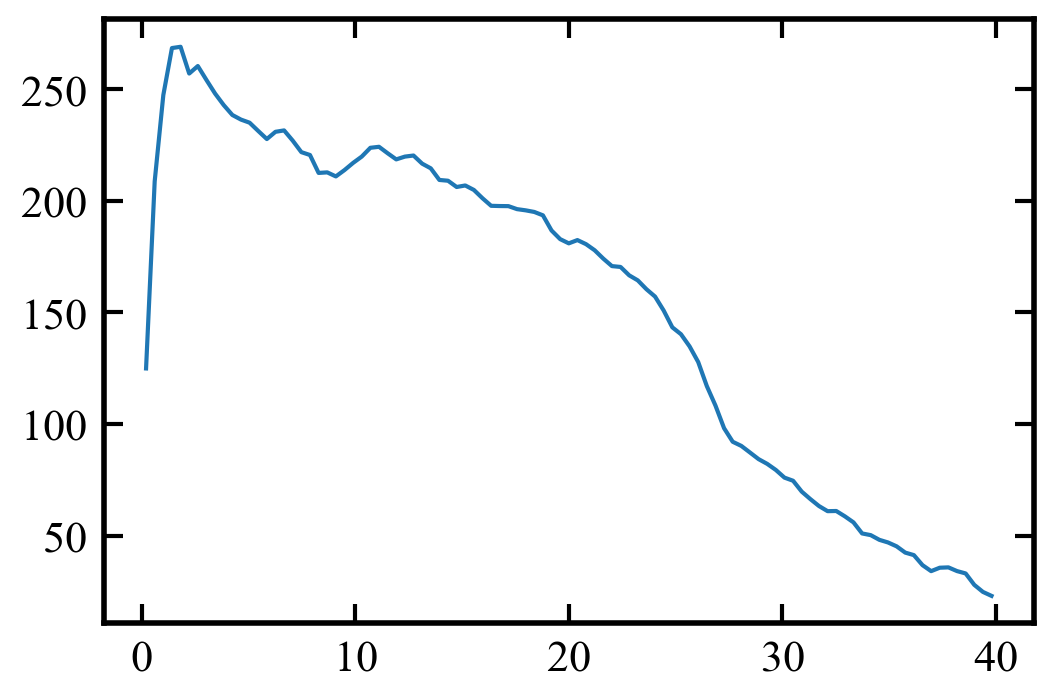

In [82]:
#gas rotation curve

R_xy_gas = coord_cyl_disk_gas[:,0]
#v_phi_gas = np.sqrt(vel_rotate_gas[:,0]**2.0+vel_rotate_gas[:,1]**2.0)
v_phi_gas = vel_cyl_disk_gas[:,1]

z_mask = (coord_cyl_disk_gas[:,2]<5.0)

#print v_phi_gas.shape, coord_cyl_disk_gas[:,2].shape

r_bins = np.linspace(0.0,40.0,100)

R_list_gas,v_list_gas = [],[]

for ii in range(len(r_bins)-1):
    bin_mask = (R_xy_gas>=r_bins[ii])&(R_xy_gas<r_bins[ii+1])
    R_list_gas.append((r_bins[ii]+r_bins[ii+1])/2.0)
    v_list_gas.append(np.mean(v_phi_gas[bin_mask&z_mask]))
    
plt.plot(R_list_gas,v_list_gas)
plt.show()


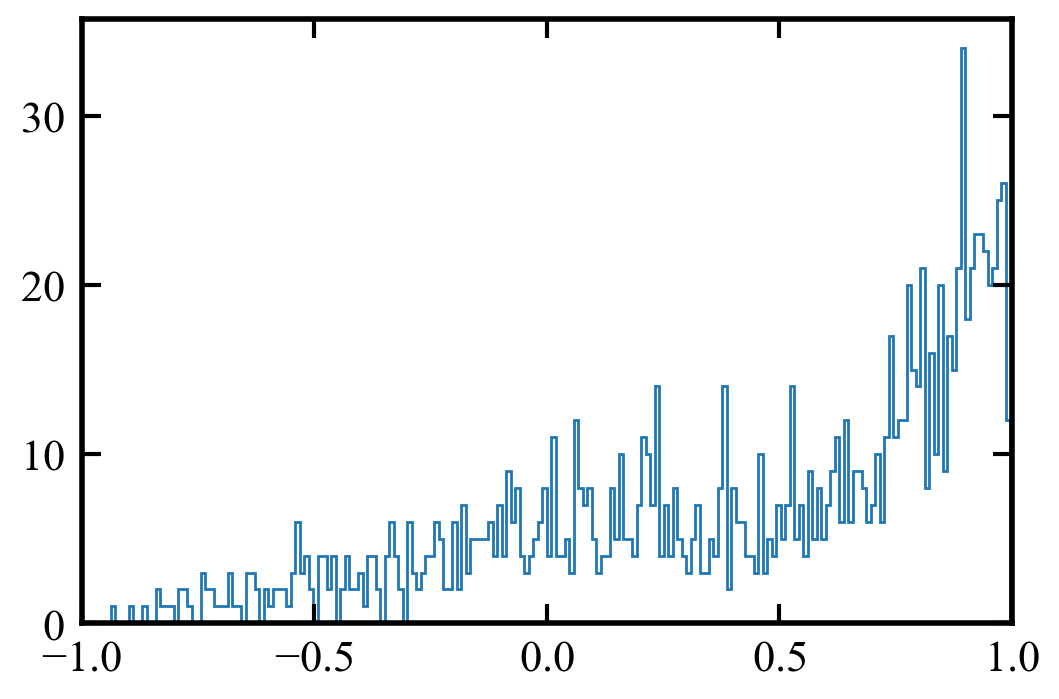

In [89]:
f = np.loadtxt('./saved_models/j_c_list.txt')
j_z = f[:,0]

plt.hist(epsilon,bins=200,histtype='step')
plt.xlim([-1.0,1.0])
plt.show()

In [1]:
#Kareem's code 
#
#Okay here are the modules 
#
#I'm going to paste the modules there and then comment out the various lines

def get_Jc_of_E(radii, mass, coord, vel, r_vs_M_file):
    G = 4.302e-6 # [kpc M_sun^-1 km^2 s^-2]
    
    #Get energy PE_grid, R_grid, and total mass
    E, phi_grid, r_grid, M_tot = get_specific_energies(radii, mass, coord, vel, r_vs_M_file)
    
    #E grid is the circular KE plus the PE
    E_grid = G*M_tot/(2*r_grid) + phi_grid

    #interpolate E, E_grid, and r_grid
    #np interp first element is the values to evaluate at
    #second and third are x and y points for evaluation
    #
    #The energy of a circular orbit only depends on r!
    #
    #so you just have to make an interpolation program that solves
    #E as a function of R and then you're good to go.
    
    circ_r = np.interp(E, E_grid, r_grid)
    
    #Mass within R_c
    this_M = np.interp(circ_r, r_grid, M_tot)
    
    J = np.sqrt(G*this_M*circ_r)
    return J
    
def get_specific_energies(radii, mass, coord, vel, r_vs_M_file):
    vx, vy, vz = vel[:, 0], vel[:, 1], vel[:, 2]
        
    T = 1/2*(vx**2 + vy**2 + vz**2)
    
    #This gives phi, r, and Mtot
    phi, r_grid, M_tot = get_functional_phi_splev(r_vs_M_file, radii = radii, 
            return_M = True)
    #what is the difference between phi and phi_grid
    phi_grid = get_functional_phi_splev(r_vs_M_file, radii = r_grid)
    
    E = phi + T
    
    return E, phi_grid, r_grid, M_tot
    
def get_functional_phi_splev(r_vs_M_file, radii, return_M = False):
    '''
    Faster than other version; uses spline instead of interp1d
    '''
    from scipy.interpolate import splev
    
    if return_M:
        tck, r_grid, M_tot = get_functional_phi_tck(r_vs_M_file, return_M = return_M)
    else:
        tck = get_functional_phi_tck(r_vs_M_file)
    phi = splev(radii, tck)
    if return_M:
        return phi, r_grid, M_tot
    else:
        return phi
def get_functional_phi_tck(r_vs_M_file, return_M = False):
    '''
    Creates the kernel to be called by get_functional_phi_splev
    '''
    from scipy.interpolate import splrep
    from scipy.integrate import cumtrapz
    
    G = 4.302e-6 # [kpc M_sun^-1 km^2 s^-2]
    
    # solve Poisson's equation.
    r_vs_M = np.load(r_vs_M_file) 
    r_grid, Mtot_cum = r_vs_M[0,:], r_vs_M[1,:]
    #phi = G*cumtrapz(Mtot_cum/r_grid**2, x = r_grid)
    #This is the integral of the PE equation
    #and then you just integrate from 0 to some large number presumably
    A = G*cumtrapz(Mtot_cum/r_grid**2, x = r_grid)
    B = A[-1]
    #I don't understand what this is, it's the reversed r
    #plus half of the difference between the elements????
    r = r_grid[:-1] + 0.5*np.diff(r_grid)
    phi = A - B
    phi -= G*Mtot_cum[-1]/r_grid[-1]
    
    # only defined up to an integration constant. we know that at r = r_max,
    # the potential is GM/r_max, so 
    # phi -= (np.max(phi) + G*Mtot_cum[-1]/r_grid[-1])
    
    func_phi = splrep(r, phi)
        
    
    if return_M:
        return func_phi, r_grid, Mtot_cum
    else:
        return func_phi

In [24]:
h = 0.702

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

f = h5py.File('../m12i_res_7100_cdm/snapshot_600.stars_with_j.hdf5')
print f['PartType4'].keys()

pos_halo_train = f_halo['position'][:]/h
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

[u'Coordinates', u'Masses', u'ParticleIDs', u'Velocities', u'circularity']


(0.0, 420000.0)

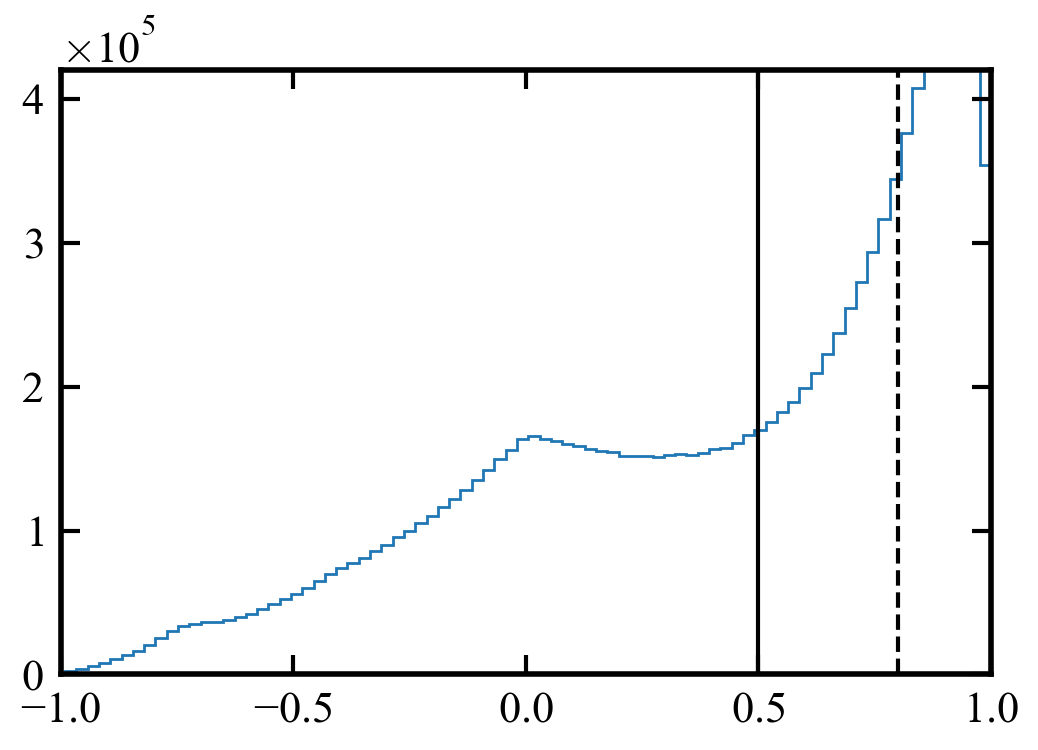

In [25]:
epsilon = f['PartType4']['circularity'][:]

#Generally stars with e > 0.8 are the thin disk
#stars with e > 0.5 are the thick disk

plt.hist(epsilon,bins=200,histtype='step')

plt.plot([0.5,0.5],[0.0,1.0e6],color='k')
plt.plot([0.8,0.8],[0.0,1.0e6],color='k',linestyle='--')

plt.xlim([-1.0,1.0])
plt.ylim([0.0,4.2e5])
#plt.show()

In [26]:
star_coords = f['PartType4']['Coordinates'][:]/h
star_ids = f['PartType4']['ParticleIDs'][:]

print star_coords, host_pos_train

coord_diff = star_coords-host_pos_train
dist = np.linalg.norm(coord_diff,axis=1)
disk_mask = (dist<50.0)

[[59639.23895712 62853.80890745 65898.23308376]
 [59639.26326327 62853.79198181 65898.23093912]
 [59639.24536745 62853.78002834 65898.32623197]
 ...
 [59573.72894801 62854.83373988 65869.99128703]
 [59570.89759185 62858.87539698 65874.00339245]
 [59567.95348023 62860.25829642 65874.54972797]] [59652.074 62852.39  65893.86 ]


In [33]:
star_coords_gal = star_coords[disk_mask]
epsilon_gal = epsilon[disk_mask]

(12399488, 3)


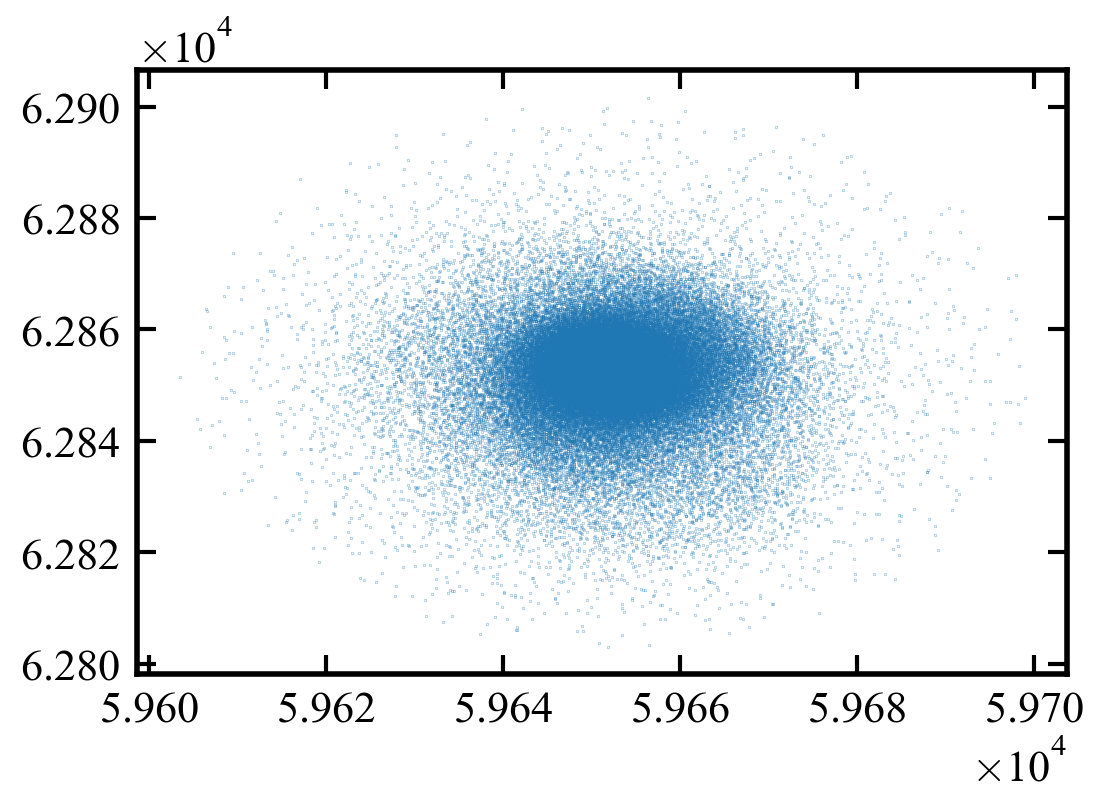

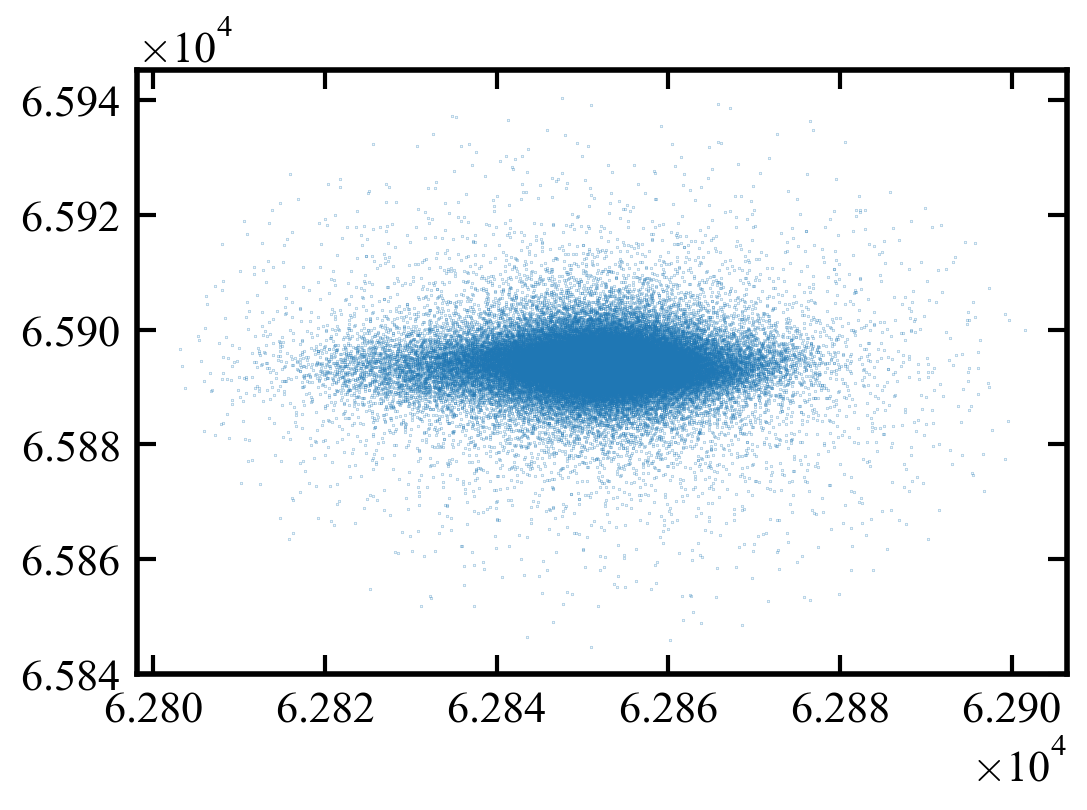

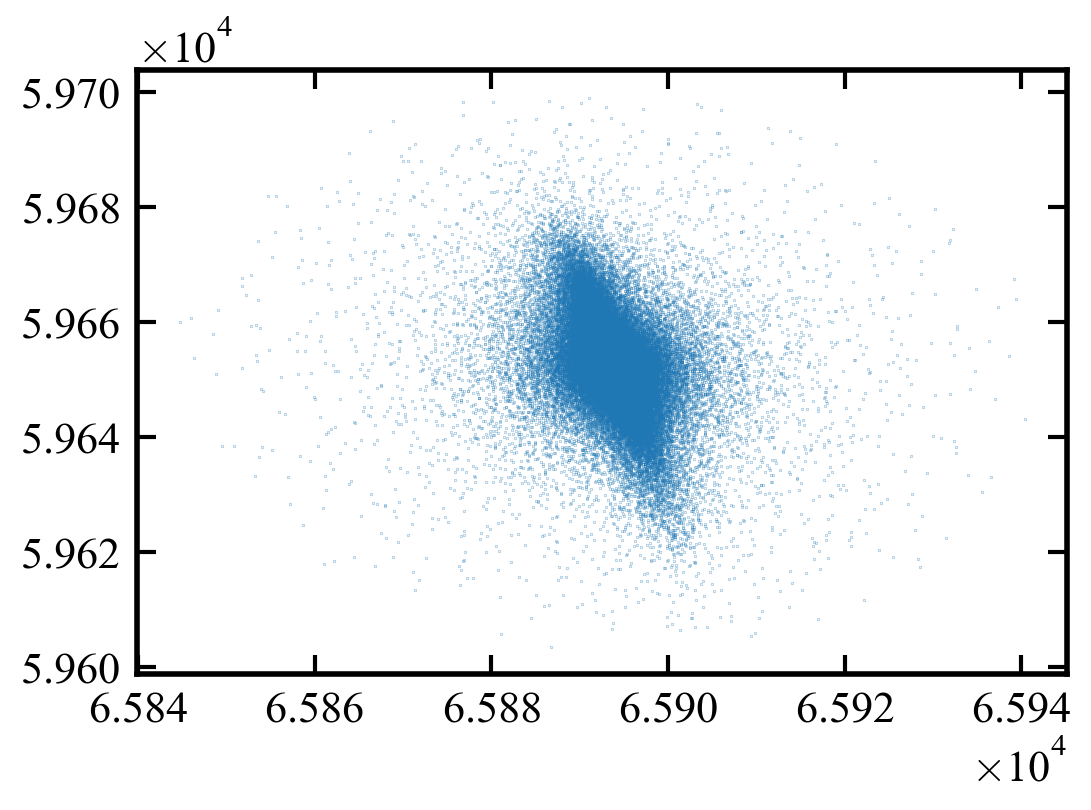

In [28]:
print star_coords_gal.shape

plt.scatter(star_coords_gal[:,0][::100],star_coords_gal[:,1][::100],s=0.01)
plt.show()

plt.scatter(star_coords_gal[:,1][::100],star_coords_gal[:,2][::100],s=0.01)
plt.show()

plt.scatter(star_coords_gal[:,2][::100],star_coords_gal[:,0][::100],s=0.01)
plt.show()

0.0


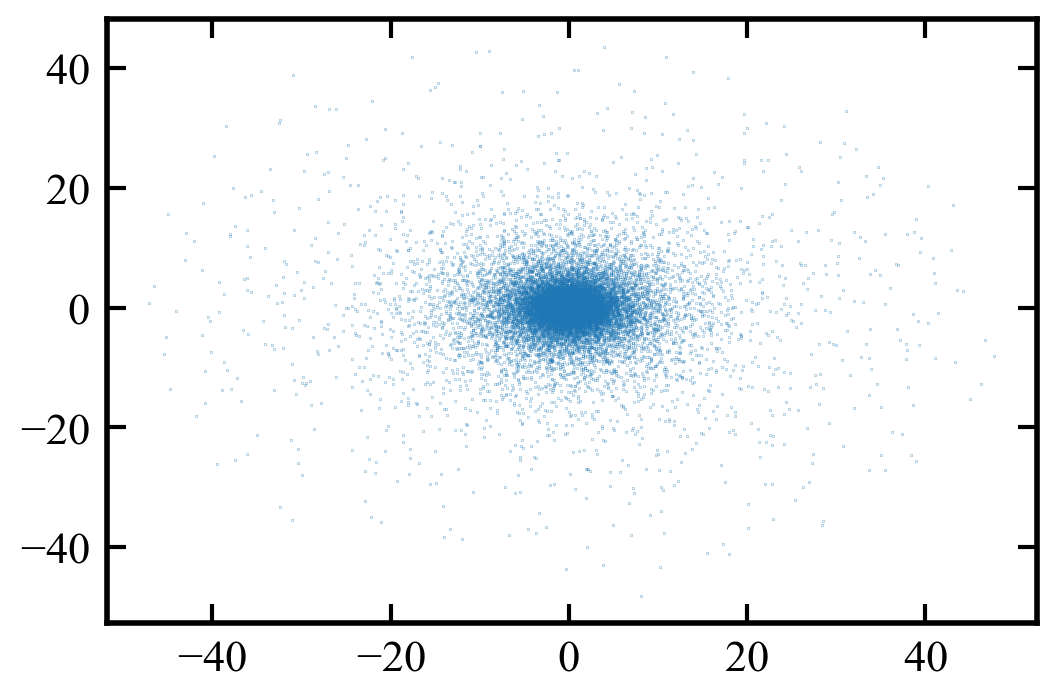

0.2


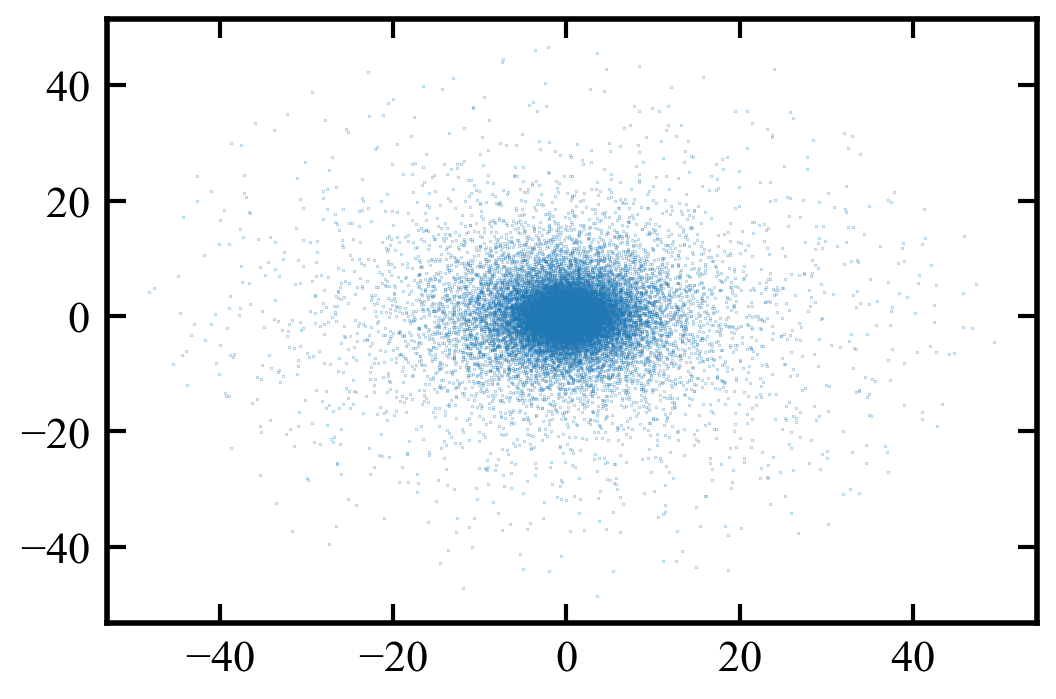

0.5


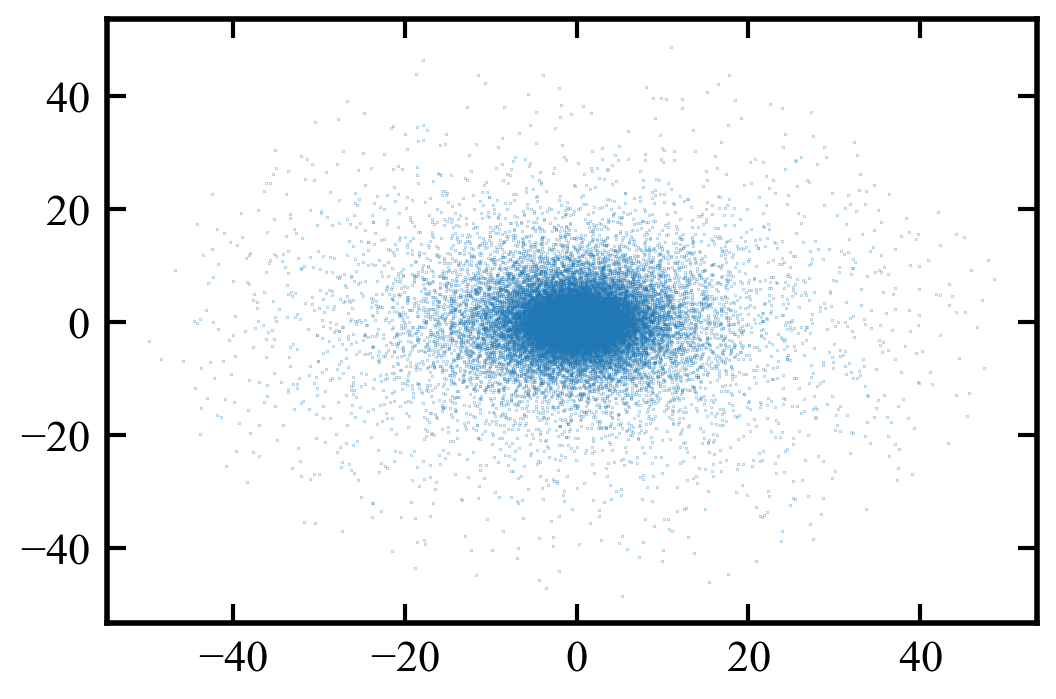

0.8


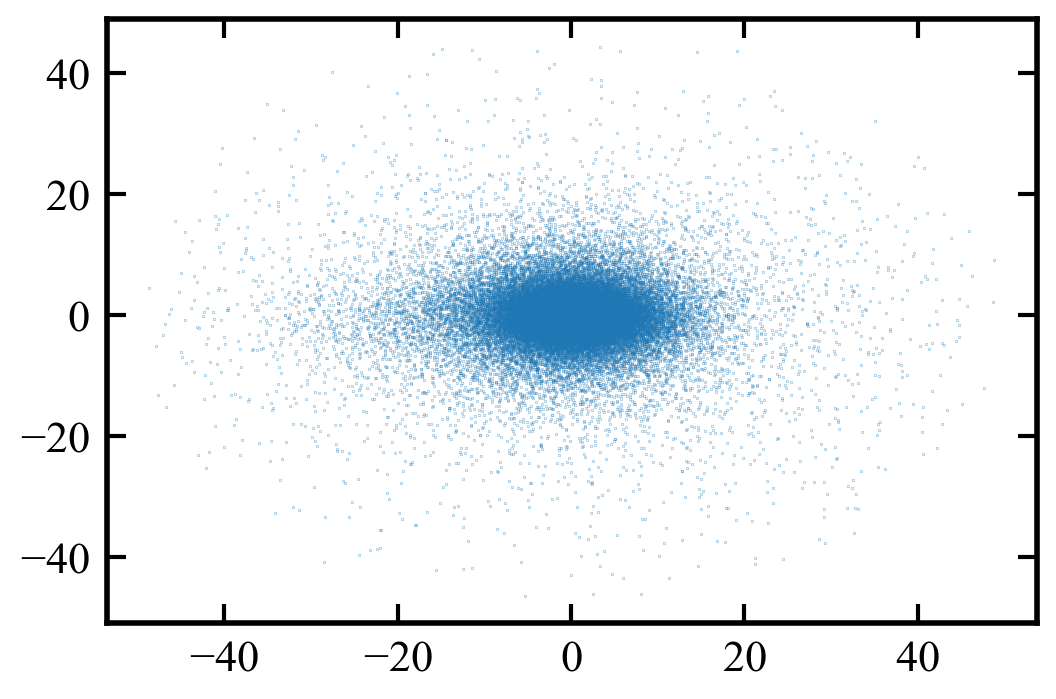

In [34]:
j_cut_list = [0.0,0.2,0.5,0.8]

for j_cut_select in j_cut_list:
    j_mask = (epsilon_gal<j_cut_select)
    
    print(j_cut_select)
    
    plt.scatter(star_coords_gal[:,1][j_mask][::100]-host_pos_train[1],star_coords_gal[:,2][j_mask][::100]-host_pos_train[2],s=0.01)
    plt.show()

0.0


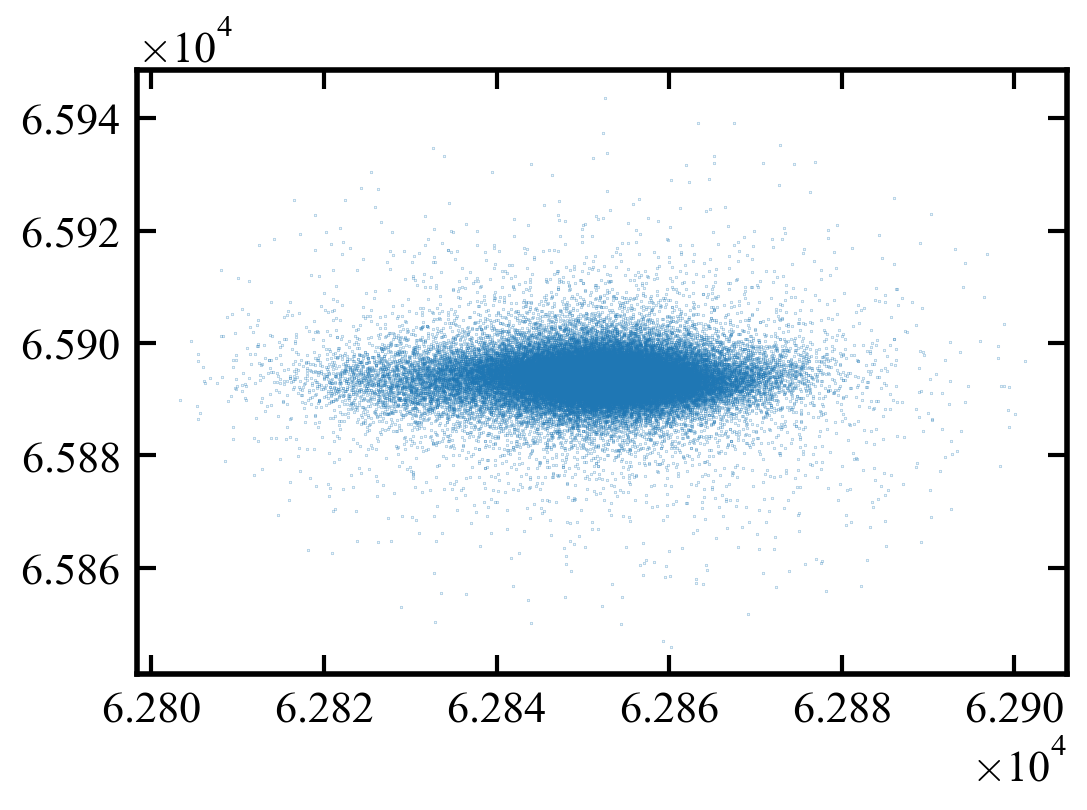

0.2


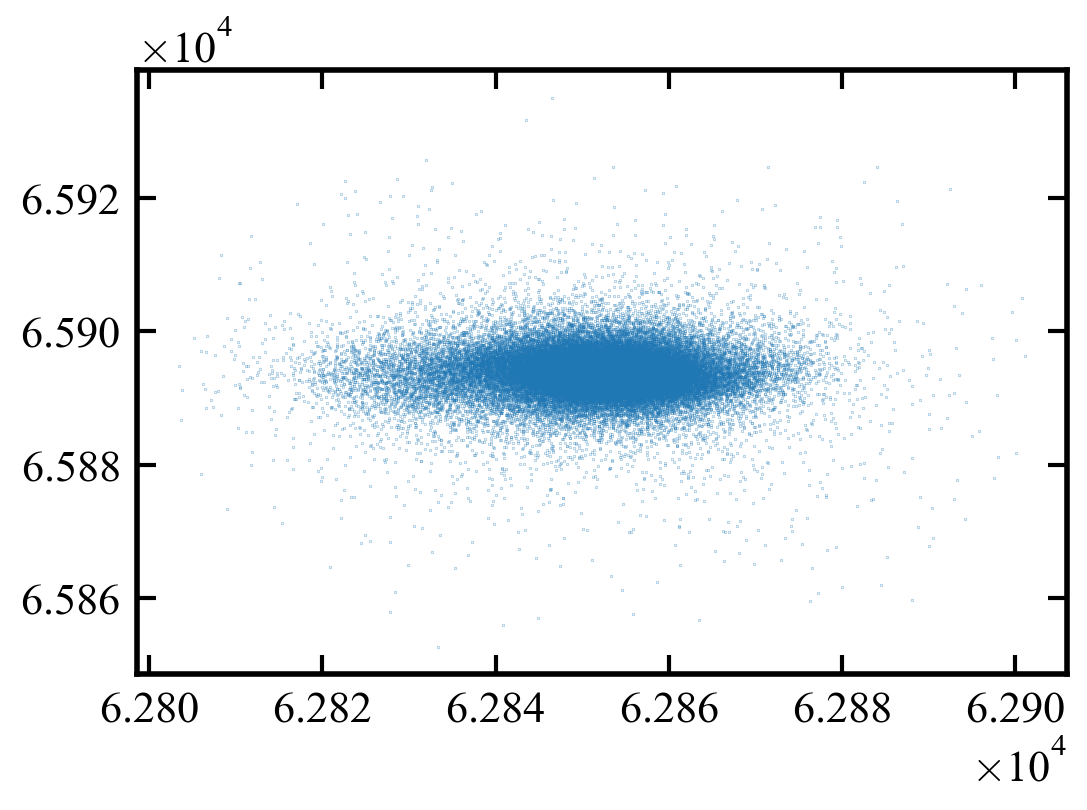

0.5


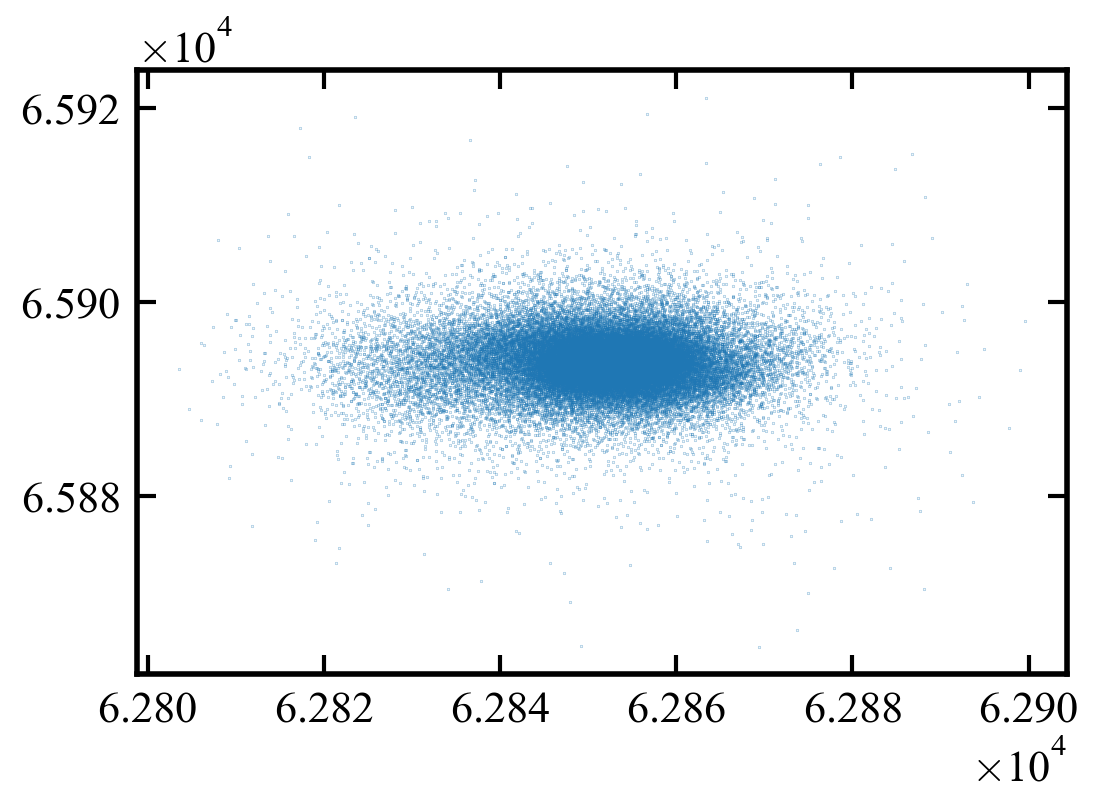

0.8


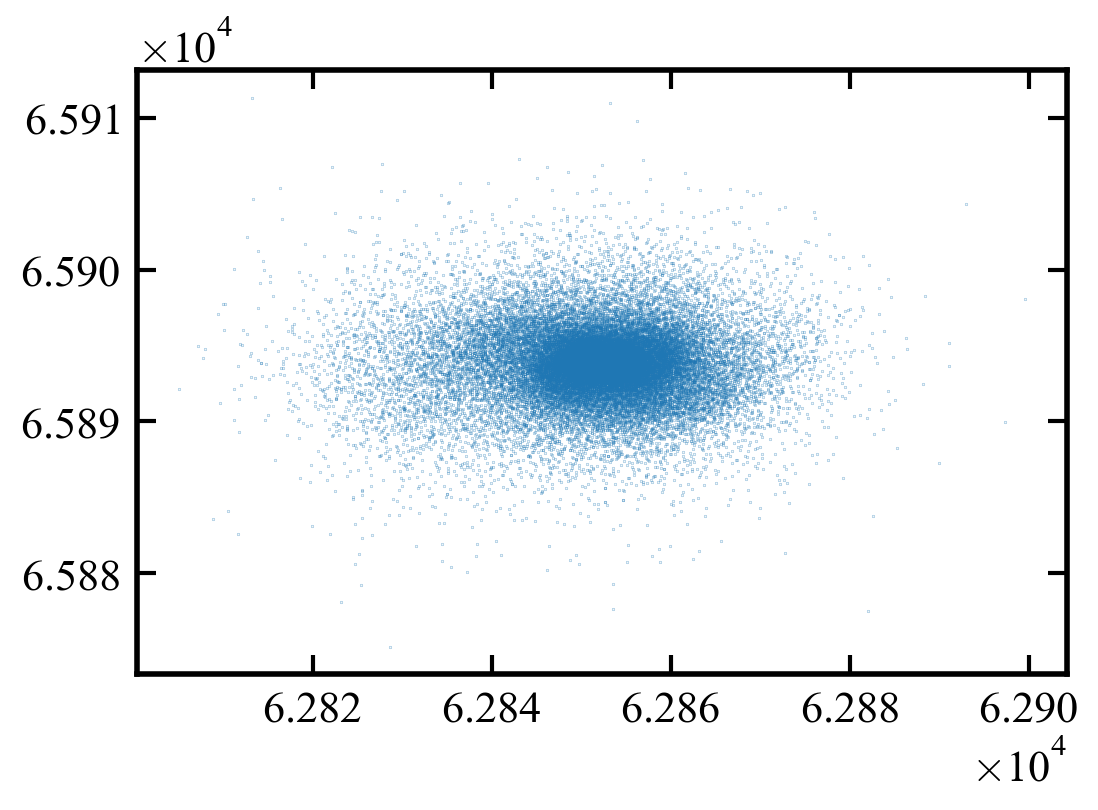

In [35]:
j_cut_list = [0.0,0.2,0.5,0.8]

for j_cut_select in j_cut_list:
    j_mask = (epsilon_gal>j_cut_select)
    
    print(j_cut_select)
    
    plt.scatter(star_coords_gal[:,1][j_mask][::100],star_coords_gal[:,2][j_mask][::100],s=0.01)
    plt.show()